In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import cross_validate, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error as mse
import seaborn as sns
from scipy import stats
import csv
import math as m

# ********* Define the functions *********

In [2]:
# function will split the column in two sets (object type and numerical type) 
# and put it in a two lists (object type and numerical type)
def colType(df):
    list_object = [] # list will contain columns that are 'object' as type
    list_num = [] # list will contain columns that are 'numerical value' as type
    for i in df.columns:
        if df[i].dtypes == 'object':
            list_object.append(i)
        else:
            list_num.append(i)
    return list_object, list_num
# ************************************

# function will replace NaN by a value ( 'unknow' in object type and mean in numerical type)
def replaceNaN_byType(df, obj, num):
    for i in obj:
        df.update(df[i].replace(np.nan, 'unknow'))
    
    for i in num:
        df.update(df[i].replace(np.nan, df[i].mean()))
    
    return df
#******************************

#function will replace y by 1 and n by 0
def YN_to_10(df, col):
    df[col] = df[col] == 'Y'
    return df
        
# function that will execute pd.get_dummies function instead a feature with 2 values (y and n)
def dummies(df, obj, instead):
    obj1 = obj
    obj1.remove(instead) # instead is a column that not be dummies because it have (y and n), so i will replace (0 and 1)
    for i in obj1:
        dum = pd.get_dummies(df[i])
        dum.columns = i+'_'+dum.columns  #rename the column by merge the name of original column and value
        for j in dum.columns:
            df[j] = dum[j]  # update the dataframe origin
        df = df.drop(i, axis=1)  # drop the column origin (column that are used to dummies)
    return df
# *********************************************

# function will group object value and output
def groupby(df, obj):
    for i in obj:
        df_groupby = df.groupby(i)[i]
        print('column : ',i)
        for j in df_groupby:
            print(j[0])
        print()
# ********************************************

#function that we will scale the feature(s)
def scaler_sale(df, feature):
    df[feature] = df[feature] * 0.001
    return df
# *************************


# function that i will split the data into train, validation end test sets
# n_splits is a list with number of splits in train and validation sets
def split_data(df, n_splits):
    kf = KFold(n_splits = n_splits, shuffle = True)
    splits = kf.splits

def plot(x, y):
    model = LinearRegression()
    model.fit(x, y)
    w = model.coef_
    b = model.intercept_
    f_wb = w*x + b
    plt.plot(x, y, '.')
    plt.plot(x, f_wb)
    plt.show()
# ***********************************************


# function will compute cost function
# costJ = 1/m * 𝛴(f_wb - y[i])
def costJ(x, y, w, b):
    m = x.shape[0]
    costJ = 0
    for i in range(m):
        f_wb = np.dot(x[i], w) + b
        err = f_wb - y[i]
        costJ += err**2
    costJ = costJ/m
    return costJ
# ****************************

#function will compute the derivation of function by w and b in LinearRegression
# 𝛛/𝛛wⁱ = 2/m 𝛴(f_wb - y[i]) * wⁱ
# 𝛛/𝛛b = 2/m 𝛴(f_wb - y[i])
def compute_deriv(x, y, w, b):
    m = x.shape[0]
    n = x.shape[1]
    d_dw = np.array([i*0 for i in range(len(w))])
    d_db = 0
    
    for i in range(m):
        f_wb = np.dot(w, x[i]) + b
        err = f_wb - y[i]
        for j in range(n):
            d_dw[j] = d_dw[j] + err * x[i][j]
        d_db += err
    
    d_dw = d_dw/m * 2
    d_db = d_db/m * 2
    return d_dw, d_db
# *********************************

# function will try to find best parameter w, b
def gradient_desc(x, y, w, b, alpha, iterate):
    m = x.shape[0]
    temp_w = np.array([i*0 for i in range(len(w))])
    temp_b = 0
    model = LinearRegression() # we will try to output the score in each step 
    model.fit(x, y)
    # now we will update w and b step by step
    
    for i in range(iterate):
        d_dw, d_db = compute_deriv(x, y, w, b)
        temp_w = w - alpha*d_dw
        temp_b = b - alpha*d_db
        
        print('𝛛/𝛛wⁱ : ',d_dw)
        print('𝛛/𝛛b : ',d_db)
        print('\n')
        w = temp_w
        b = temp_b
        yield w, b        

## read data

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

feature = [i for i in train.columns if i != 'SalePrice']
target = 'SalePrice'

## print information about data

In [4]:
print(train.info())
print(train.head())
print()
isnull = []
print(train.tail())
for i in train.columns:
    null = train[i].isnull().sum()
    if null != 0:
        print(i, ' ', null)
        isnull.append([i, null])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
# after seen the features that have nan and the number of nan, we've decide to drop those features :
# Alley    -------> 1369 nan
# PoolQC   -------> 1453 nan
# Fence    -------> 1179 nan
# MiscFeature ----> 1406 nan
print(train)
train = train.drop(['Id', 'Alley','PoolQC', 'Fence', 'MiscFeature'], axis=1)

        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fe

In [6]:
# after drop some feature, now We will classify the type of features
print(train)
obj, num = colType(train)
num.remove('SalePrice')

      MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
0             60       RL         65.0     8450   Pave      Reg         Lvl   
1             20       RL         80.0     9600   Pave      Reg         Lvl   
2             60       RL         68.0    11250   Pave      IR1         Lvl   
3             70       RL         60.0     9550   Pave      IR1         Lvl   
4             60       RL         84.0    14260   Pave      IR1         Lvl   
...          ...      ...          ...      ...    ...      ...         ...   
1455          60       RL         62.0     7917   Pave      Reg         Lvl   
1456          20       RL         85.0    13175   Pave      Reg         Lvl   
1457          70       RL         66.0     9042   Pave      Reg         Lvl   
1458          20       RL         68.0     9717   Pave      Reg         Lvl   
1459          20       RL         75.0     9937   Pave      Reg         Lvl   

     Utilities LotConfig LandSlope  ... EnclosedPor

In [7]:
print(train[obj].info())
print(train[obj].head())
print()
print(train[obj].tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 39 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1460 non-null   object
 1   Street         1460 non-null   object
 2   LotShape       1460 non-null   object
 3   LandContour    1460 non-null   object
 4   Utilities      1460 non-null   object
 5   LotConfig      1460 non-null   object
 6   LandSlope      1460 non-null   object
 7   Neighborhood   1460 non-null   object
 8   Condition1     1460 non-null   object
 9   Condition2     1460 non-null   object
 10  BldgType       1460 non-null   object
 11  HouseStyle     1460 non-null   object
 12  RoofStyle      1460 non-null   object
 13  RoofMatl       1460 non-null   object
 14  Exterior1st    1460 non-null   object
 15  Exterior2nd    1460 non-null   object
 16  MasVnrType     1452 non-null   object
 17  ExterQual      1460 non-null   object
 18  ExterCond      1460 non-null

In [8]:
print(train[num].info())
print(train[num].head())
print()
print(train[num].tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   LotFrontage    1201 non-null   float64
 2   LotArea        1460 non-null   int64  
 3   OverallQual    1460 non-null   int64  
 4   OverallCond    1460 non-null   int64  
 5   YearBuilt      1460 non-null   int64  
 6   YearRemodAdd   1460 non-null   int64  
 7   MasVnrArea     1452 non-null   float64
 8   BsmtFinSF1     1460 non-null   int64  
 9   BsmtFinSF2     1460 non-null   int64  
 10  BsmtUnfSF      1460 non-null   int64  
 11  TotalBsmtSF    1460 non-null   int64  
 12  1stFlrSF       1460 non-null   int64  
 13  2ndFlrSF       1460 non-null   int64  
 14  LowQualFinSF   1460 non-null   int64  
 15  GrLivArea      1460 non-null   int64  
 16  BsmtFullBath   1460 non-null   int64  
 17  BsmtHalfBath   1460 non-null   int64  
 18  FullBath

In [9]:
groupby(train, obj)

column :  MSZoning
C (all)
FV
RH
RL
RM

column :  Street
Grvl
Pave

column :  LotShape
IR1
IR2
IR3
Reg

column :  LandContour
Bnk
HLS
Low
Lvl

column :  Utilities
AllPub
NoSeWa

column :  LotConfig
Corner
CulDSac
FR2
FR3
Inside

column :  LandSlope
Gtl
Mod
Sev

column :  Neighborhood
Blmngtn
Blueste
BrDale
BrkSide
ClearCr
CollgCr
Crawfor
Edwards
Gilbert
IDOTRR
MeadowV
Mitchel
NAmes
NPkVill
NWAmes
NoRidge
NridgHt
OldTown
SWISU
Sawyer
SawyerW
Somerst
StoneBr
Timber
Veenker

column :  Condition1
Artery
Feedr
Norm
PosA
PosN
RRAe
RRAn
RRNe
RRNn

column :  Condition2
Artery
Feedr
Norm
PosA
PosN
RRAe
RRAn
RRNn

column :  BldgType
1Fam
2fmCon
Duplex
Twnhs
TwnhsE

column :  HouseStyle
1.5Fin
1.5Unf
1Story
2.5Fin
2.5Unf
2Story
SFoyer
SLvl

column :  RoofStyle
Flat
Gable
Gambrel
Hip
Mansard
Shed

column :  RoofMatl
ClyTile
CompShg
Membran
Metal
Roll
Tar&Grv
WdShake
WdShngl

column :  Exterior1st
AsbShng
AsphShn
BrkComm
BrkFace
CBlock
CemntBd
HdBoard
ImStucc
MetalSd
Plywood
Stone
Stucco
VinylSd
Wd

In [10]:
feat_to_scale = []
for i in num:
    print(i)
    print(train[i].max(),', ', train[i].min(),', ', train[i].mean())
    if train[i].max() > 1000:
        feat_to_scale.append(i)
    print()

MSSubClass
190 ,  20 ,  56.897260273972606

LotFrontage
313.0 ,  21.0 ,  70.04995836802665

LotArea
215245 ,  1300 ,  10516.828082191782

OverallQual
10 ,  1 ,  6.0993150684931505

OverallCond
9 ,  1 ,  5.575342465753424

YearBuilt
2010 ,  1872 ,  1971.267808219178

YearRemodAdd
2010 ,  1950 ,  1984.8657534246574

MasVnrArea
1600.0 ,  0.0 ,  103.68526170798899

BsmtFinSF1
5644 ,  0 ,  443.6397260273973

BsmtFinSF2
1474 ,  0 ,  46.54931506849315

BsmtUnfSF
2336 ,  0 ,  567.2404109589041

TotalBsmtSF
6110 ,  0 ,  1057.4294520547944

1stFlrSF
4692 ,  334 ,  1162.626712328767

2ndFlrSF
2065 ,  0 ,  346.99246575342465

LowQualFinSF
572 ,  0 ,  5.844520547945206

GrLivArea
5642 ,  334 ,  1515.463698630137

BsmtFullBath
3 ,  0 ,  0.42534246575342466

BsmtHalfBath
2 ,  0 ,  0.057534246575342465

FullBath
3 ,  0 ,  1.5650684931506849

HalfBath
2 ,  0 ,  0.38287671232876713

BedroomAbvGr
8 ,  0 ,  2.8664383561643834

KitchenAbvGr
3 ,  0 ,  1.0465753424657533

TotRmsAbvGrd
14 ,  2 ,  6.5178082191

In [11]:
print(feat_to_scale)
feat_to_scale.remove('YearBuilt')
feat_to_scale.remove('YearRemodAdd')
feat_to_scale.remove('GarageYrBlt')
feat_to_scale.remove('YrSold')

['LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'MiscVal', 'YrSold']


In [12]:
# here i will scale the features
max_=[]
for i in feat_to_scale:
    max_.append(train[i].max())
    train[i] = train[i]/train[i].max()

#  Apply the functions that are above to change the data

In [13]:
# for train in train.csv
train = replaceNaN_byType(train, obj, num)
train = dummies(train, obj, 'CentralAir')
train = YN_to_10(train, 'CentralAir')
train = scaler_sale(train, 'SalePrice')

In [14]:
obj,num = colType(train)

In [15]:
print(train.head())

   MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0          60         65.0  0.039258            7            5       2003   
1          20         80.0  0.044600            6            8       1976   
2          60         68.0  0.052266            7            5       2001   
3          70         60.0  0.044368            7            5       1915   
4          60         84.0  0.066250            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
0          2003     0.12250    0.125089         0.0  ...               0   
1          1976     0.00000    0.173281         0.0  ...               0   
2          2002     0.10125    0.086109         0.0  ...               0   
3          1970     0.00000    0.038271         0.0  ...               0   
4          2000     0.21875    0.116052         0.0  ...               0   

   SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0          

In [16]:
print(train['CentralAir'])

0       True
1       True
2       True
3       True
4       True
        ... 
1455    True
1456    True
1457    True
1458    True
1459    True
Name: CentralAir, Length: 1460, dtype: bool


FOR THE FEATURE :  MSSubClass
----------------
p_coefficient  -0.08428413512659519
p_value  0.0012664716847503312


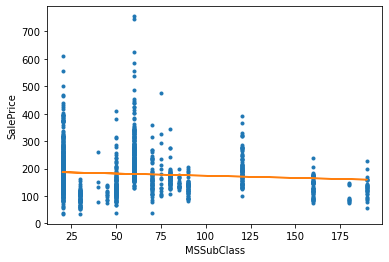




FOR THE FEATURE :  LotFrontage
----------------
p_coefficient  0.33490085154055127
p_value  1.3466505607154999e-39


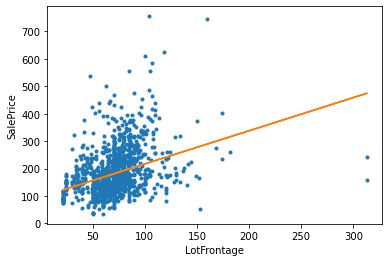




FOR THE FEATURE :  LotArea
----------------
p_coefficient  0.26384335387140495
p_value  1.1231391549198169e-24


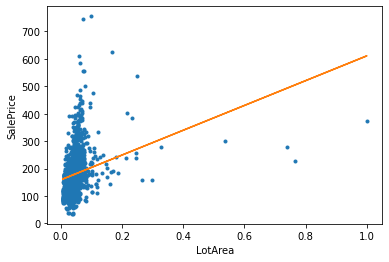




FOR THE FEATURE :  OverallQual
----------------
p_coefficient  0.790981600583805
p_value  2.185675268e-313


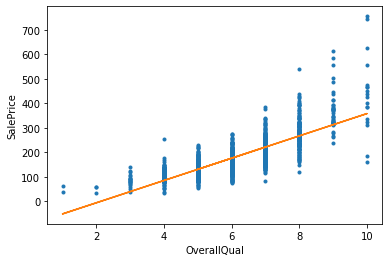




FOR THE FEATURE :  OverallCond
----------------
p_coefficient  -0.07785589404867768
p_value  0.0029123512679174956


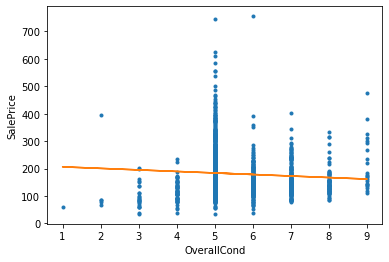




FOR THE FEATURE :  YearBuilt
----------------
p_coefficient  0.5228973328794964
p_value  2.990229099016919e-103


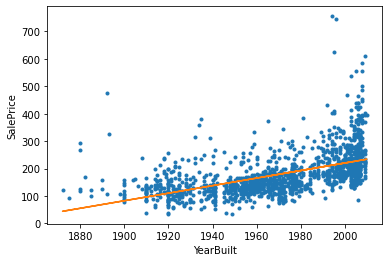




FOR THE FEATURE :  YearRemodAdd
----------------
p_coefficient  0.5071009671113872
p_value  3.1649482419171954e-96


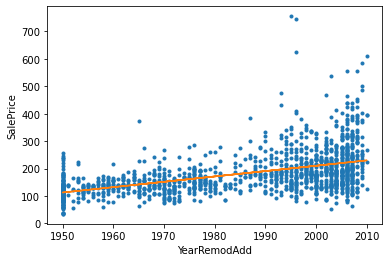




FOR THE FEATURE :  MasVnrArea
----------------
p_coefficient  0.4752413167736671
p_value  3.924711741791994e-83


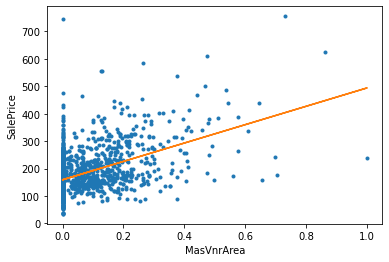




FOR THE FEATURE :  BsmtFinSF1
----------------
p_coefficient  0.3864198062421518
p_value  3.3941098292949995e-53


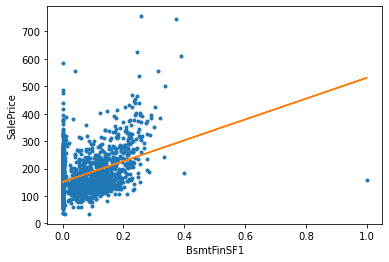




FOR THE FEATURE :  BsmtFinSF2
----------------
p_coefficient  -0.011378121450215257
p_value  0.6639986508345731


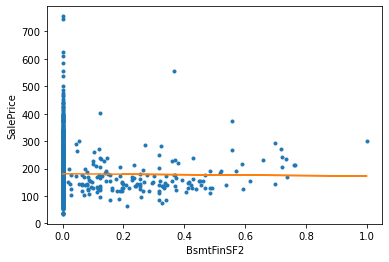




FOR THE FEATURE :  BsmtUnfSF
----------------
p_coefficient  0.21447910554696883
p_value  1.1829757963602225e-16


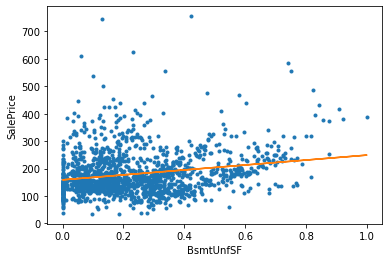




FOR THE FEATURE :  TotalBsmtSF
----------------
p_coefficient  0.6135805515591944
p_value  9.484229391520853e-152


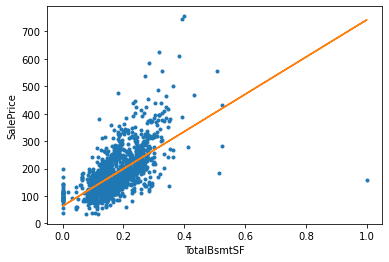




FOR THE FEATURE :  CentralAir
----------------
p_coefficient  0.25132816384015727
p_value  1.8095061559263192e-22


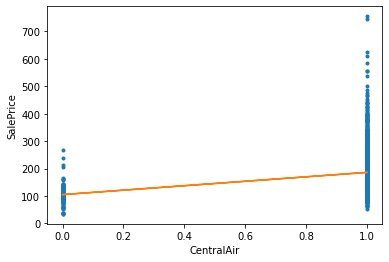




FOR THE FEATURE :  1stFlrSF
----------------
p_coefficient  0.6058521846919155
p_value  5.394710618964537e-147


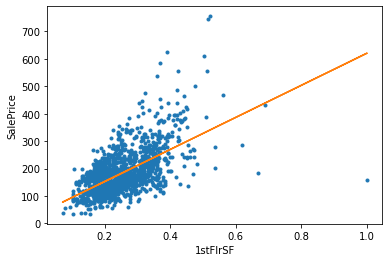




FOR THE FEATURE :  2ndFlrSF
----------------
p_coefficient  0.319333802832067
p_value  5.764335119185027e-36


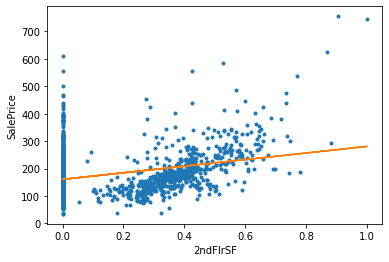




FOR THE FEATURE :  LowQualFinSF
----------------
p_coefficient  -0.025606130000680148
p_value  0.32820730984074636


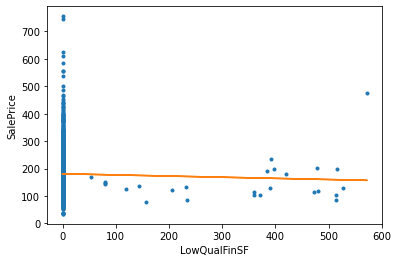




FOR THE FEATURE :  GrLivArea
----------------
p_coefficient  0.7086244776126522
p_value  4.518033646779431e-223


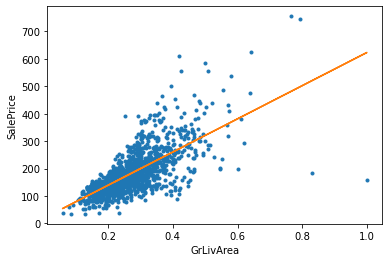




FOR THE FEATURE :  BsmtFullBath
----------------
p_coefficient  0.2271222331314976
p_value  1.5503441372125197e-18


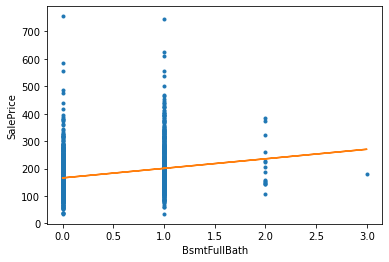




FOR THE FEATURE :  BsmtHalfBath
----------------
p_coefficient  -0.016844154297359294
p_value  0.5201536357280284


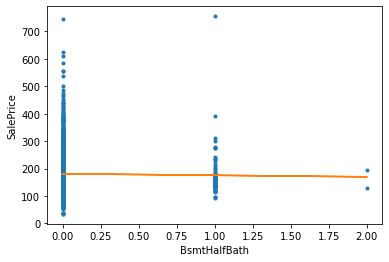




FOR THE FEATURE :  FullBath
----------------
p_coefficient  0.5606637627484461
p_value  1.2364700667602998e-121


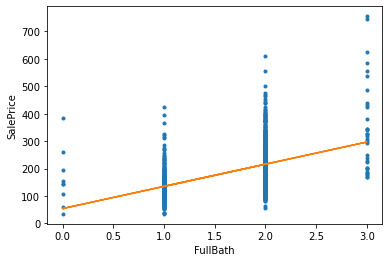




FOR THE FEATURE :  HalfBath
----------------
p_coefficient  0.28410767559477906
p_value  1.6504733955752184e-28


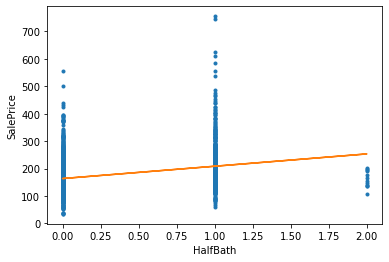




FOR THE FEATURE :  BedroomAbvGr
----------------
p_coefficient  0.16821315430074127
p_value  9.92749732618158e-11


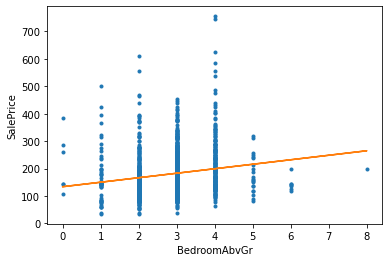




FOR THE FEATURE :  KitchenAbvGr
----------------
p_coefficient  -0.13590737084214188
p_value  1.8604260320762563e-07


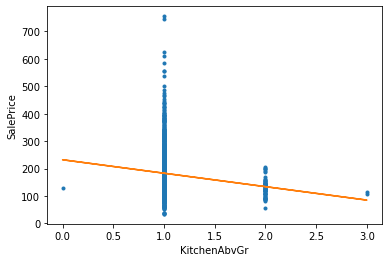




FOR THE FEATURE :  TotRmsAbvGrd
----------------
p_coefficient  0.5337231555820227
p_value  2.772280932975136e-108


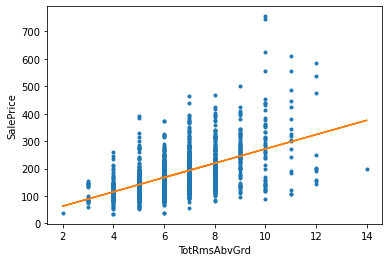




FOR THE FEATURE :  Fireplaces
----------------
p_coefficient  0.4669288367515242
p_value  6.141487461139652e-80


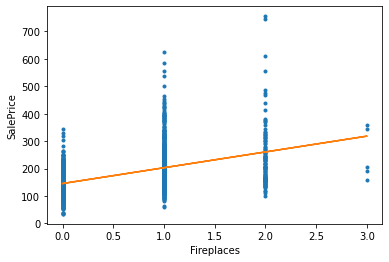




FOR THE FEATURE :  GarageYrBlt
----------------
p_coefficient  0.47017745374048026
p_value  3.550785009570669e-81


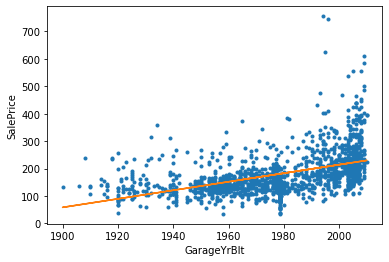




FOR THE FEATURE :  GarageCars
----------------
p_coefficient  0.6404091972583505
p_value  2.4986441671849074e-169


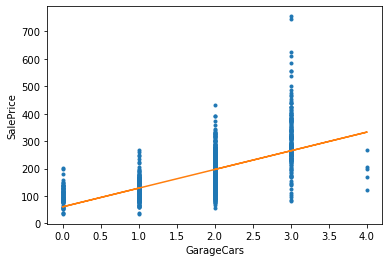




FOR THE FEATURE :  GarageArea
----------------
p_coefficient  0.6234314389183603
p_value  5.265038167990376e-158


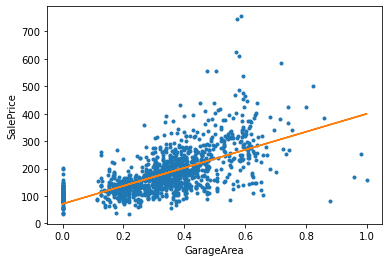




FOR THE FEATURE :  WoodDeckSF
----------------
p_coefficient  0.32441344456813154
p_value  3.972216535625873e-37


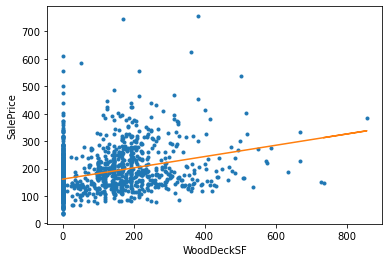




FOR THE FEATURE :  OpenPorchSF
----------------
p_coefficient  0.3158562271160548
p_value  3.4933736230981743e-35


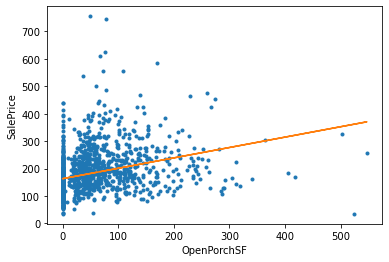




FOR THE FEATURE :  EnclosedPorch
----------------
p_coefficient  -0.12857795792595617
p_value  8.255770475119547e-07


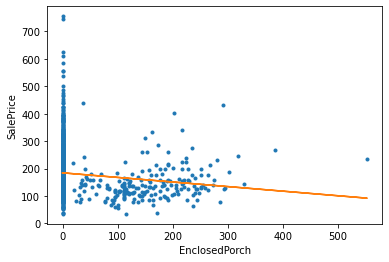




FOR THE FEATURE :  3SsnPorch
----------------
p_coefficient  0.04458366533574793
p_value  0.0885817035806393


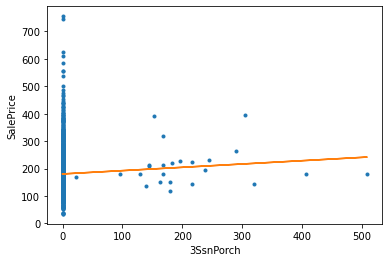




FOR THE FEATURE :  ScreenPorch
----------------
p_coefficient  0.11144657114291048
p_value  1.972140019470455e-05


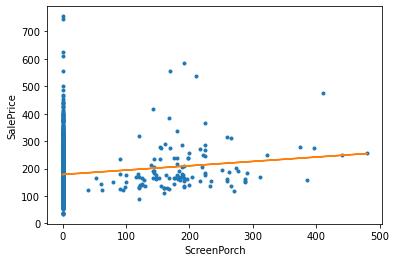




FOR THE FEATURE :  PoolArea
----------------
p_coefficient  0.09240354949187271
p_value  0.00040734896011991486


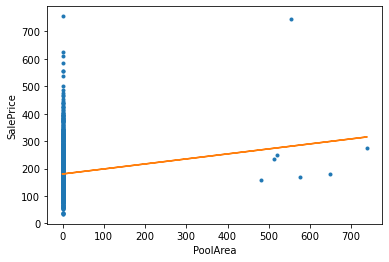




FOR THE FEATURE :  MiscVal
----------------
p_coefficient  -0.021189579640302676
p_value  0.4184863494082921


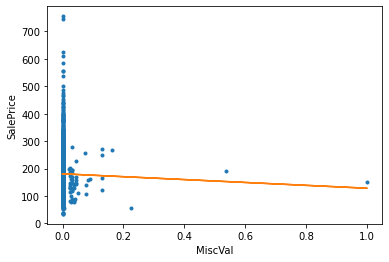




FOR THE FEATURE :  MoSold
----------------
p_coefficient  0.04643224522381911
p_value  0.07612757850609982


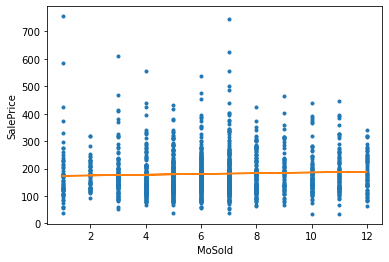




FOR THE FEATURE :  YrSold
----------------
p_coefficient  -0.028922585168730468
p_value  0.2694131932810079


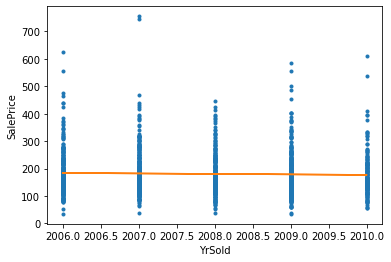




FOR THE FEATURE :  MSZoning_C (all)
----------------
p_coefficient  -0.11125658290808504
p_value  2.0378724002948763e-05


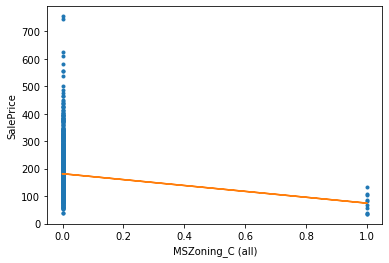




FOR THE FEATURE :  MSZoning_FV
----------------
p_coefficient  0.08994971967036146
p_value  0.0005795528105649701


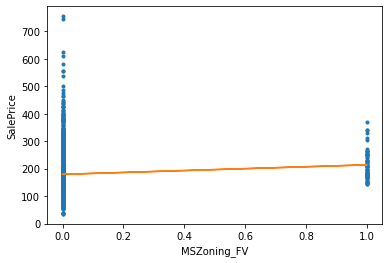




FOR THE FEATURE :  MSZoning_RH
----------------
p_coefficient  -0.06542929310102562
p_value  0.012398724317115816


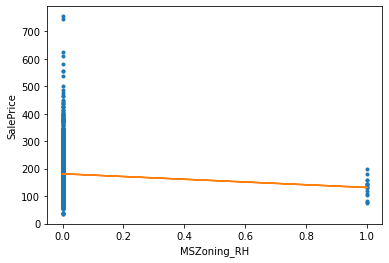




FOR THE FEATURE :  MSZoning_RL
----------------
p_coefficient  0.24506340389709216
p_value  2.077257728424662e-21


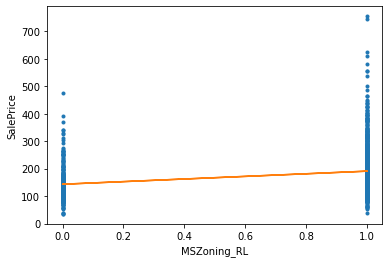




FOR THE FEATURE :  MSZoning_RM
----------------
p_coefficient  -0.2880651218971237
p_value  2.6970981267251774e-29


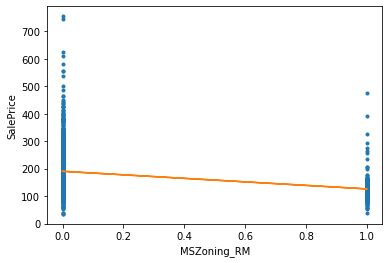




FOR THE FEATURE :  Street_Grvl
----------------
p_coefficient  -0.041035535500049826
p_value  0.11704860406788917


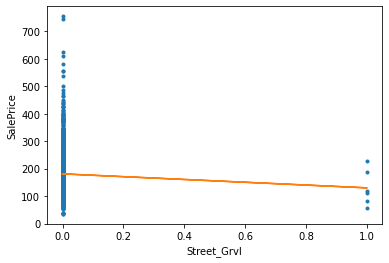




FOR THE FEATURE :  Street_Pave
----------------
p_coefficient  0.04103553550004979
p_value  0.11704860406788917


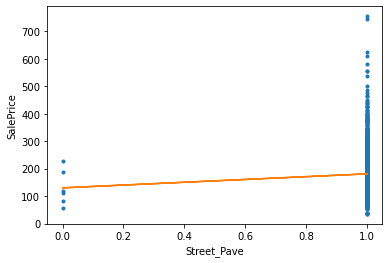




FOR THE FEATURE :  LotShape_IR1
----------------
p_coefficient  0.22328392470489908
p_value  5.9460027738865345e-18


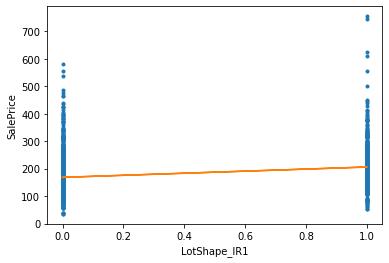




FOR THE FEATURE :  LotShape_IR2
----------------
p_coefficient  0.12609608820325455
p_value  1.3428707345190057e-06


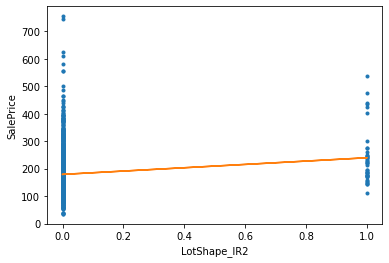




FOR THE FEATURE :  LotShape_IR3
----------------
p_coefficient  0.03672047549953544
p_value  0.16080819023494392


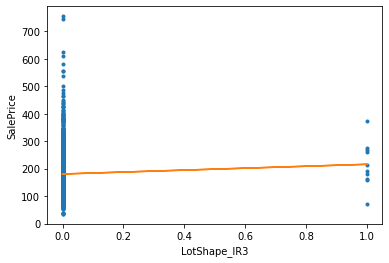




FOR THE FEATURE :  LotShape_Reg
----------------
p_coefficient  -0.2676717602887957
p_value  2.2443743731875487e-25


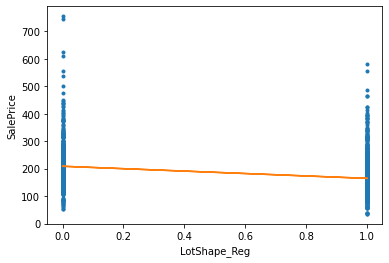




FOR THE FEATURE :  LandContour_Bnk
----------------
p_coefficient  -0.10112449060458731
p_value  0.00010857787443476418


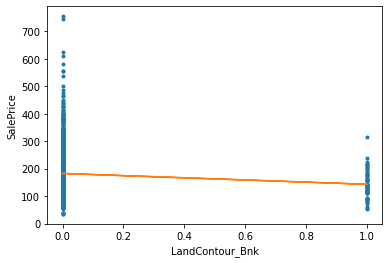




FOR THE FEATURE :  LandContour_HLS
----------------
p_coefficient  0.12001380186770785
p_value  4.2570215060463725e-06


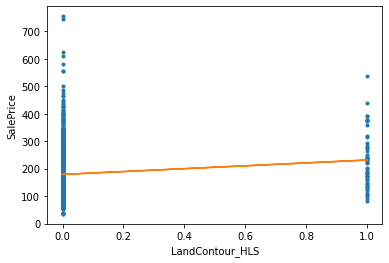




FOR THE FEATURE :  LandContour_Low
----------------
p_coefficient  0.0455282503274953
p_value  0.0820270618317536


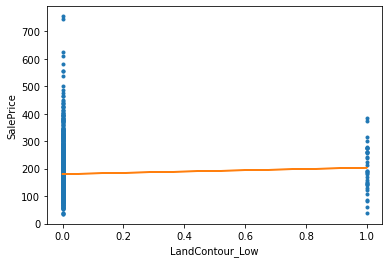




FOR THE FEATURE :  LandContour_Lvl
----------------
p_coefficient  -0.027544579330839154
p_value  0.2929027906400112


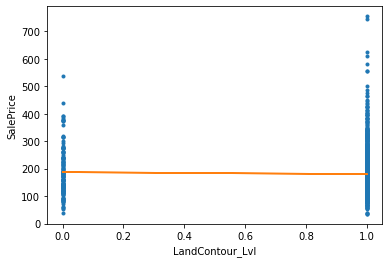




FOR THE FEATURE :  Utilities_AllPub
----------------
p_coefficient  0.014314296147248983
p_value  0.5847167739693384


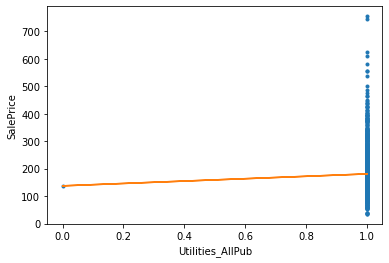




FOR THE FEATURE :  Utilities_NoSeWa
----------------
p_coefficient  -0.01431429614724896
p_value  0.5847167739693384


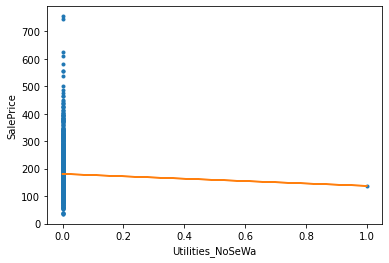




FOR THE FEATURE :  LotConfig_Corner
----------------
p_coefficient  0.004144823294072536
p_value  0.8742688608482646


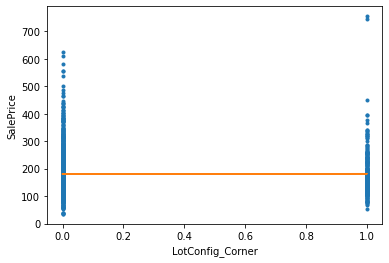




FOR THE FEATURE :  LotConfig_CulDSac
----------------
p_coefficient  0.14181753652525933
p_value  5.27672907572486e-08


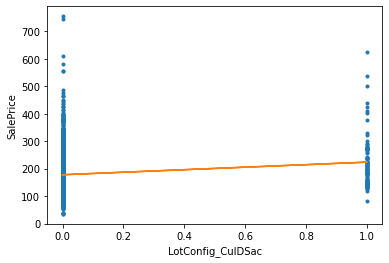




FOR THE FEATURE :  LotConfig_FR2
----------------
p_coefficient  -0.0068588907827759685
p_value  0.7934321095421256


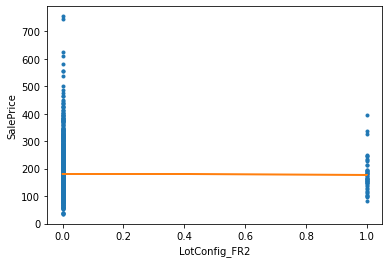




FOR THE FEATURE :  LotConfig_FR3
----------------
p_coefficient  0.01818556247550324
p_value  0.4874742625908078


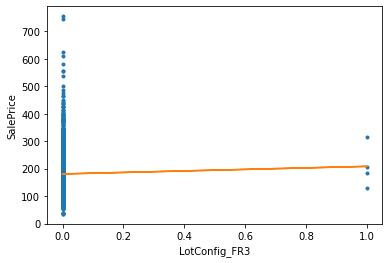




FOR THE FEATURE :  LotConfig_Inside
----------------
p_coefficient  -0.08053786914590598
p_value  0.0020719827477794707


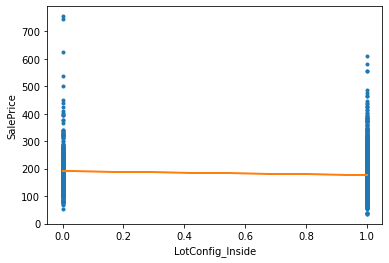




FOR THE FEATURE :  LandSlope_Gtl
----------------
p_coefficient  -0.05111614933705161
p_value  0.050849336921446046


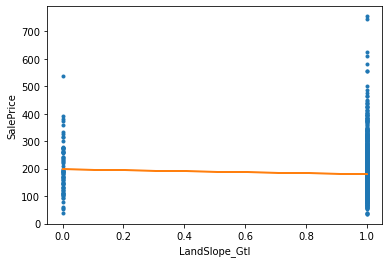




FOR THE FEATURE :  LandSlope_Mod
----------------
p_coefficient  0.0429811599443708
p_value  0.10066052286147514


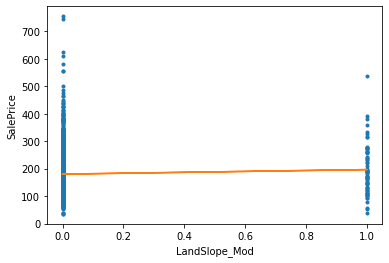




FOR THE FEATURE :  LandSlope_Sev
----------------
p_coefficient  0.027997864142057172
p_value  0.2850290390956411


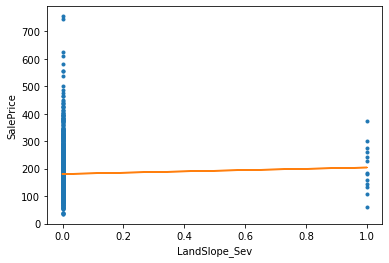




FOR THE FEATURE :  Neighborhood_Blmngtn
----------------
p_coefficient  0.01906564951350561
p_value  0.4666505315213776


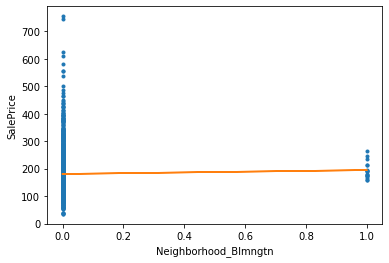




FOR THE FEATURE :  Neighborhood_Blueste
----------------
p_coefficient  -0.020250412762982294
p_value  0.43941365190358345


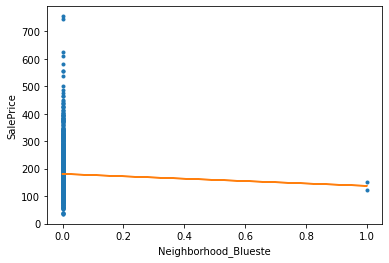




FOR THE FEATURE :  Neighborhood_BrDale
----------------
p_coefficient  -0.10130283618167185
p_value  0.00010556180644894824


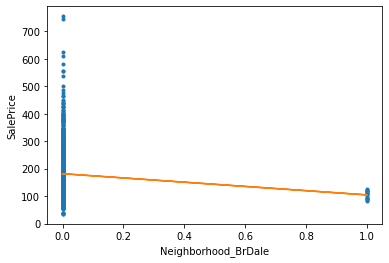




FOR THE FEATURE :  Neighborhood_BrkSide
----------------
p_coefficient  -0.14364786671580496
p_value  3.533923221941283e-08


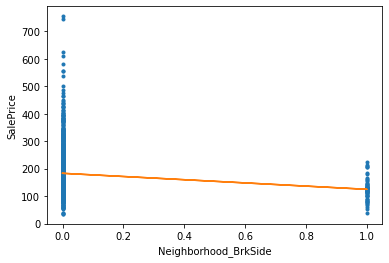




FOR THE FEATURE :  Neighborhood_ClearCr
----------------
p_coefficient  0.05571831053291223
p_value  0.03326882351563423


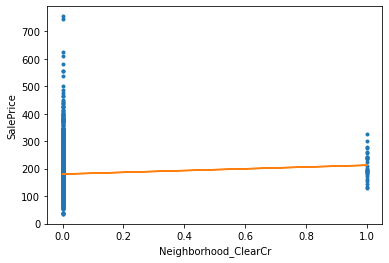




FOR THE FEATURE :  Neighborhood_CollgCr
----------------
p_coefficient  0.07262599312707721
p_value  0.005497717302635493


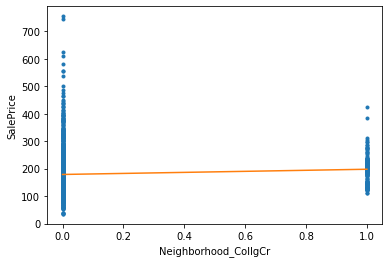




FOR THE FEATURE :  Neighborhood_Crawfor
----------------
p_coefficient  0.07115960252664774
p_value  0.006525733632307605


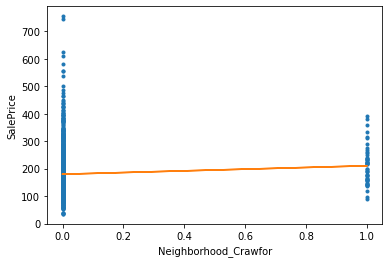




FOR THE FEATURE :  Neighborhood_Edwards
----------------
p_coefficient  -0.17994896448338413
p_value  4.311766347166918e-12


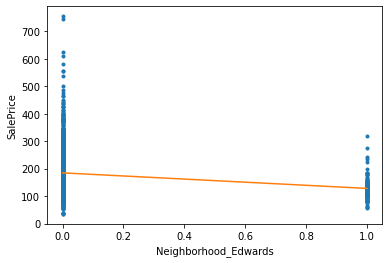




FOR THE FEATURE :  Neighborhood_Gilbert
----------------
p_coefficient  0.035939622294683976
p_value  0.1699021629027166


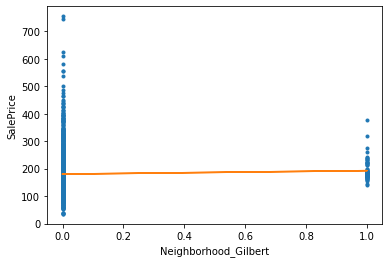




FOR THE FEATURE :  Neighborhood_IDOTRR
----------------
p_coefficient  -0.1640558518909155
p_value  2.8640028533011645e-10


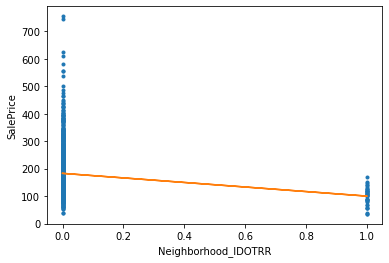




FOR THE FEATURE :  Neighborhood_MeadowV
----------------
p_coefficient  -0.1125441547459997
p_value  1.6301605341877734e-05


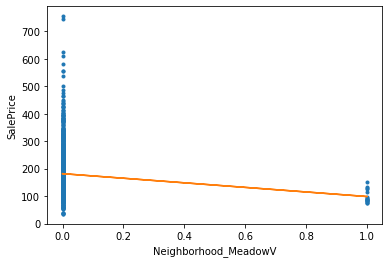




FOR THE FEATURE :  Neighborhood_Mitchel
----------------
p_coefficient  -0.05784505418676325
p_value  0.02709030591378706


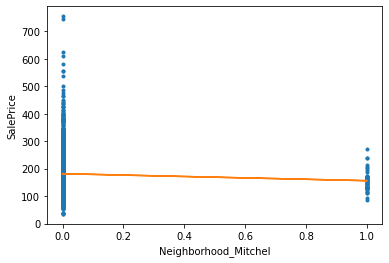




FOR THE FEATURE :  Neighborhood_NAmes
----------------
p_coefficient  -0.18851259699796916
p_value  3.811530316958351e-13


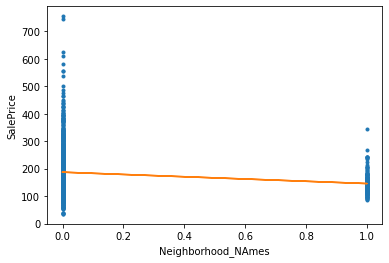




FOR THE FEATURE :  Neighborhood_NPkVill
----------------
p_coefficient  -0.037909739904050374
p_value  0.14767050663638642


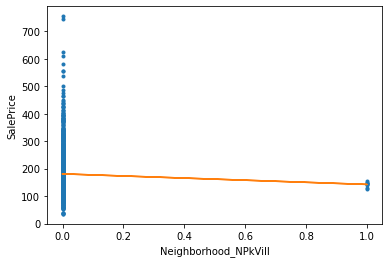




FOR THE FEATURE :  Neighborhood_NWAmes
----------------
p_coefficient  0.023482773020255376
p_value  0.3699160556703009


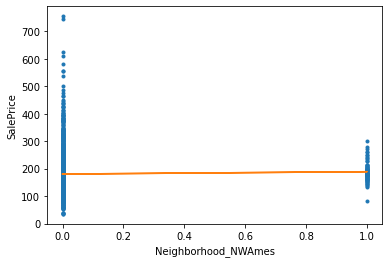




FOR THE FEATURE :  Neighborhood_NoRidge
----------------
p_coefficient  0.3304236257653578
p_value  1.5684929100094902e-38


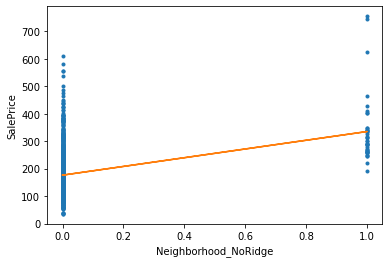




FOR THE FEATURE :  Neighborhood_NridgHt
----------------
p_coefficient  0.4021485981752666
p_value  7.301451183107162e-58


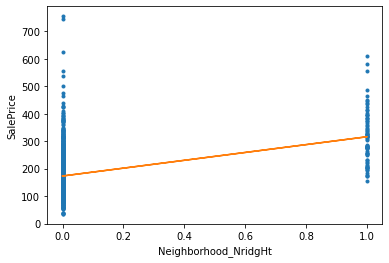




FOR THE FEATURE :  Neighborhood_OldTown
----------------
p_coefficient  -0.19218879886097007
p_value  1.2979245732086467e-13


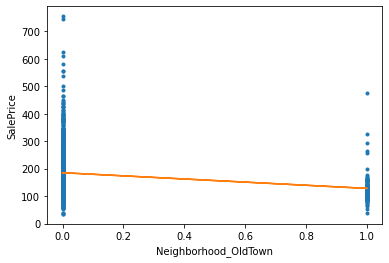




FOR THE FEATURE :  Neighborhood_SWISU
----------------
p_coefficient  -0.06370549244437909
p_value  0.014909423718894825


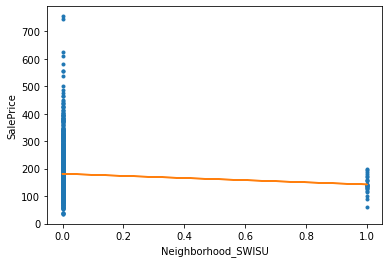




FOR THE FEATURE :  Neighborhood_Sawyer
----------------
p_coefficient  -0.12839406550544274
p_value  8.561462536337024e-07


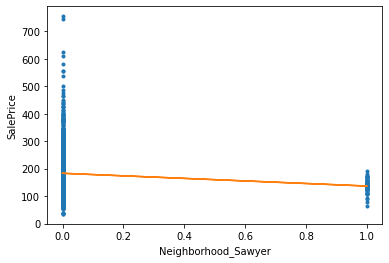




FOR THE FEATURE :  Neighborhood_SawyerW
----------------
p_coefficient  0.014560153318488825
p_value  0.578282202853921


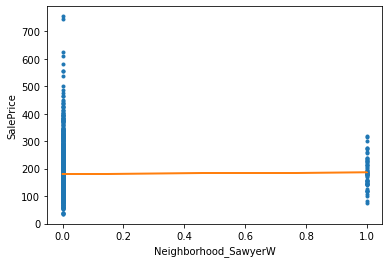




FOR THE FEATURE :  Neighborhood_Somerst
----------------
p_coefficient  0.1400579963436242
p_value  7.720957738402497e-08


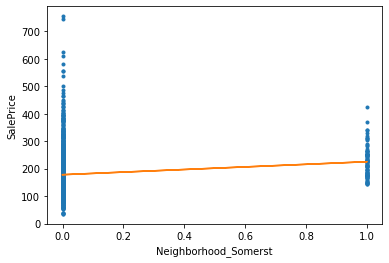




FOR THE FEATURE :  Neighborhood_StoneBr
----------------
p_coefficient  0.2153627227693866
p_value  8.813867236847202e-17


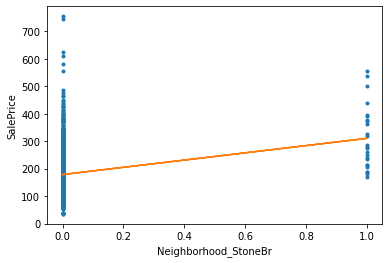




FOR THE FEATURE :  Neighborhood_Timber
----------------
p_coefficient  0.12623630766971225
p_value  1.306782024845222e-06


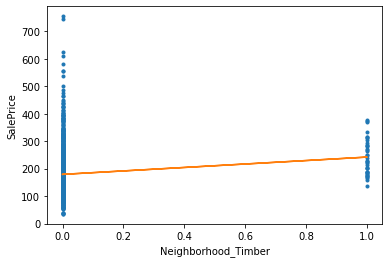




FOR THE FEATURE :  Neighborhood_Veenker
----------------
p_coefficient  0.06347063934055339
p_value  0.015284013379885926


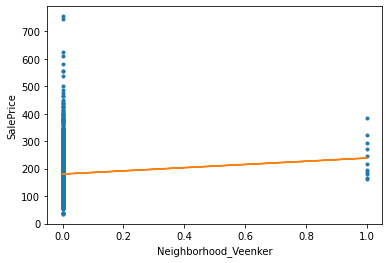




FOR THE FEATURE :  Condition1_Artery
----------------
p_coefficient  -0.1064007109680518
p_value  4.628165653639199e-05


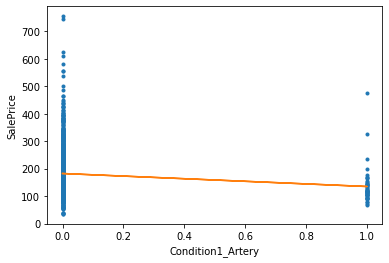




FOR THE FEATURE :  Condition1_Feedr
----------------
p_coefficient  -0.1173286774856823
p_value  6.9630439098165576e-06


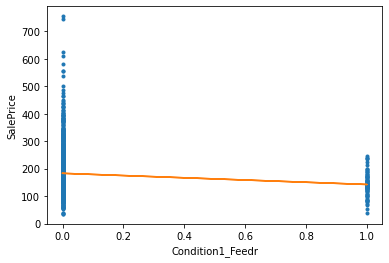




FOR THE FEATURE :  Condition1_Norm
----------------
p_coefficient  0.11296832108736388
p_value  1.5137843886069318e-05


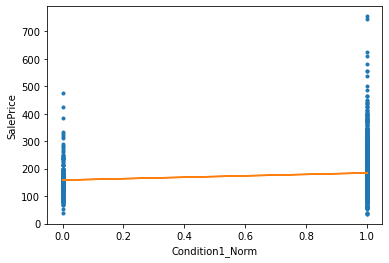




FOR THE FEATURE :  Condition1_PosA
----------------
p_coefficient  0.04201689908541698
p_value  0.1085384714146798


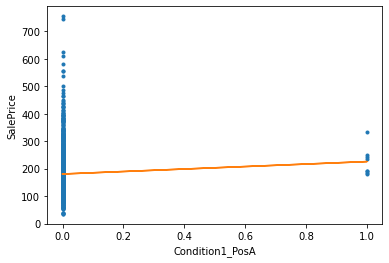




FOR THE FEATURE :  Condition1_PosN
----------------
p_coefficient  0.04954116844794426
p_value  0.05842357283670482


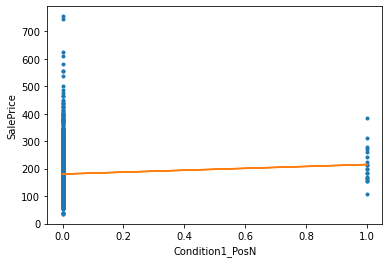




FOR THE FEATURE :  Condition1_RRAe
----------------
p_coefficient  -0.04665127135276236
p_value  0.07475150687375447


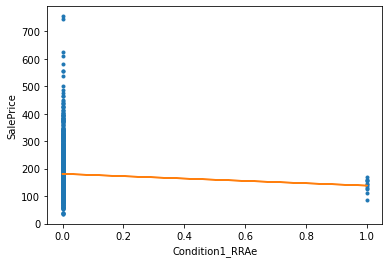




FOR THE FEATURE :  Condition1_RRAn
----------------
p_coefficient  0.0058927117115444355
p_value  0.8220031561219263


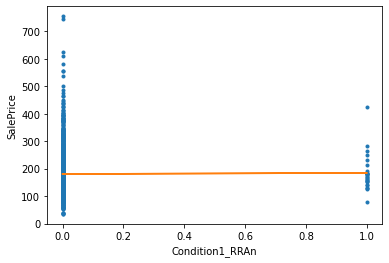




FOR THE FEATURE :  Condition1_RRNe
----------------
p_coefficient  0.004583875135268435
p_value  0.8610792199985275


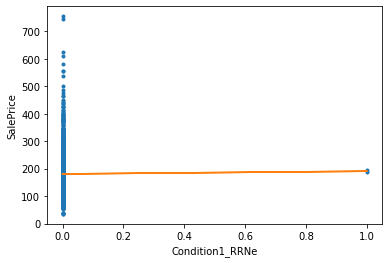




FOR THE FEATURE :  Condition1_RRNn
----------------
p_coefficient  0.023236333124508738
p_value  0.37496134236656536


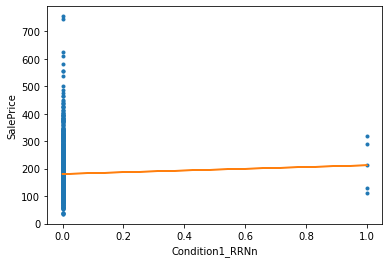




FOR THE FEATURE :  Condition2_Artery
----------------
p_coefficient  -0.03470793247839585
p_value  0.18502138193293802


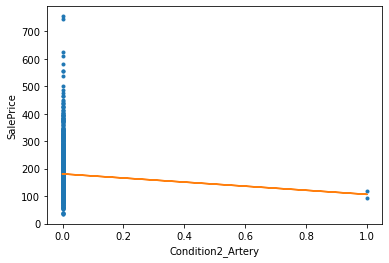




FOR THE FEATURE :  Condition2_Feedr
----------------
p_coefficient  -0.04833482100357337
p_value  0.06483875211290928


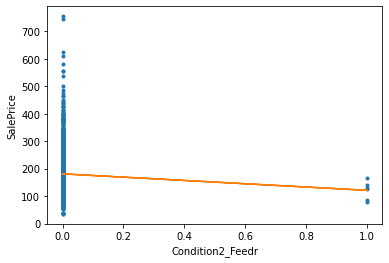




FOR THE FEATURE :  Condition2_Norm
----------------
p_coefficient  0.030676288435637723
p_value  0.24143358397110426


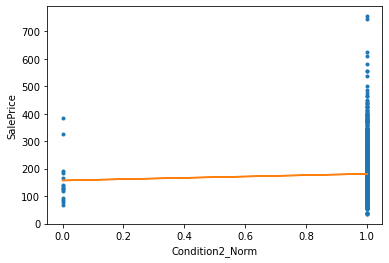




FOR THE FEATURE :  Condition2_PosA
----------------
p_coefficient  0.047497233281444444
p_value  0.06962596446236528


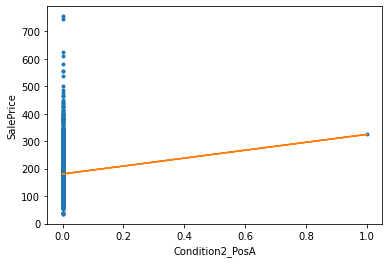




FOR THE FEATURE :  Condition2_PosN
----------------
p_coefficient  0.04848110233569749
p_value  0.06403117724556227


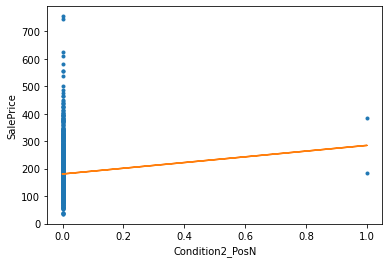




FOR THE FEATURE :  Condition2_RRAe
----------------
p_coefficient  0.002992932092785054
p_value  0.9090300403771862


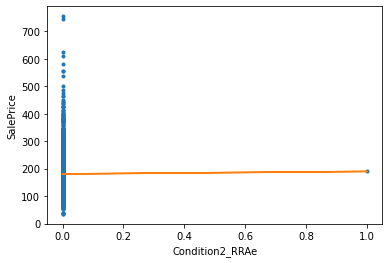




FOR THE FEATURE :  Condition2_RRAn
----------------
p_coefficient  -0.014510444733969327
p_value  0.5795804895999397


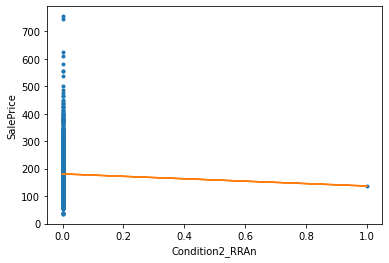




FOR THE FEATURE :  Condition2_RRNn
----------------
p_coefficient  -0.039255055614695236
p_value  0.13381482342701378


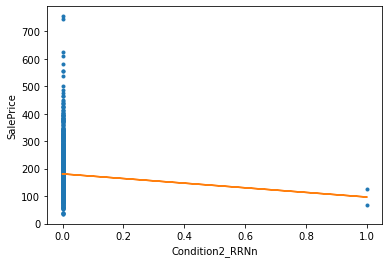




FOR THE FEATURE :  BldgType_1Fam
----------------
p_coefficient  0.13748324869515313
p_value  1.3363539314557269e-07


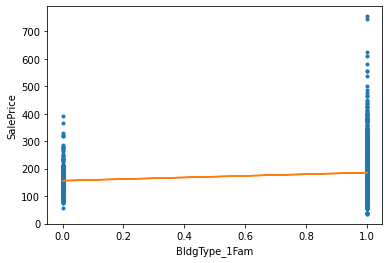




FOR THE FEATURE :  BldgType_2fmCon
----------------
p_coefficient  -0.09734830194128336
p_value  0.00019505331251014937


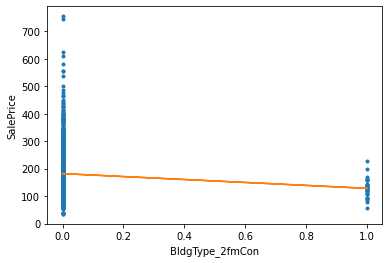




FOR THE FEATURE :  BldgType_Duplex
----------------
p_coefficient  -0.11465483002228388
p_value  1.1247186543396767e-05


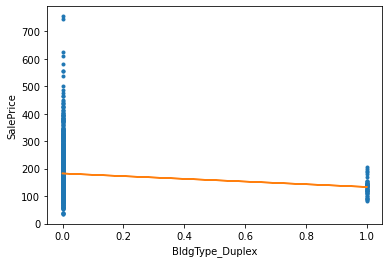




FOR THE FEATURE :  BldgType_Twnhs
----------------
p_coefficient  -0.09873019861048941
p_value  0.00015778907407974524


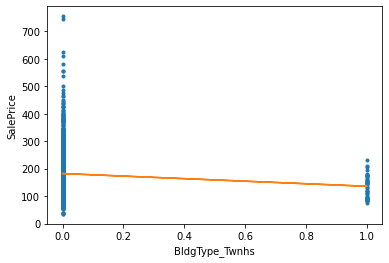




FOR THE FEATURE :  BldgType_TwnhsE
----------------
p_coefficient  0.003804383453308919
p_value  0.8845203529666813


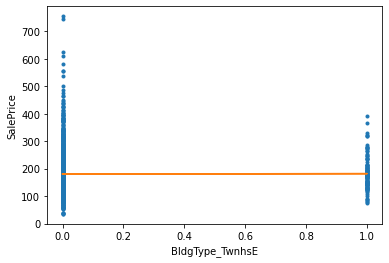




FOR THE FEATURE :  HouseStyle_1.5Fin
----------------
p_coefficient  -0.16346607100995758
p_value  3.3212984253532867e-10


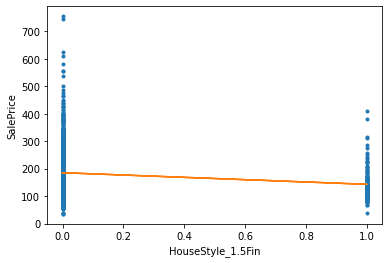




FOR THE FEATURE :  HouseStyle_1.5Unf
----------------
p_coefficient  -0.08768640584636372
p_value  0.0007962779476539839


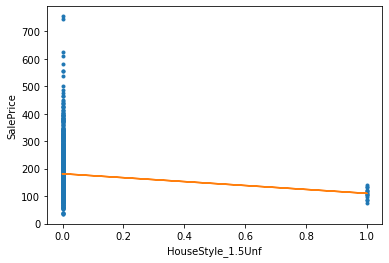




FOR THE FEATURE :  HouseStyle_1Story
----------------
p_coefficient  -0.06181110053588833
p_value  0.01817494075612611


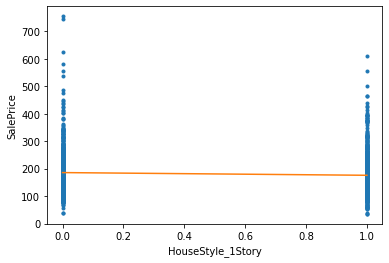




FOR THE FEATURE :  HouseStyle_2.5Fin
----------------
p_coefficient  0.036525722375987384
p_value  0.1630411788363029


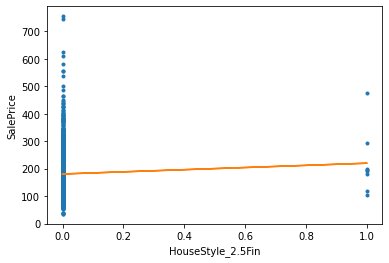




FOR THE FEATURE :  HouseStyle_2.5Unf
----------------
p_coefficient  -0.025855674595624423
p_value  0.32351381970721493


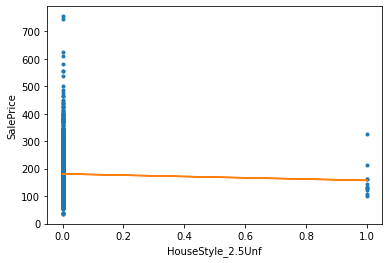




FOR THE FEATURE :  HouseStyle_2Story
----------------
p_coefficient  0.24288002726854013
p_value  4.785582335505818e-21


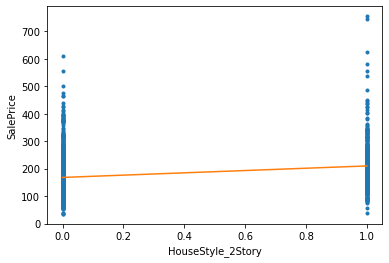




FOR THE FEATURE :  HouseStyle_SFoyer
----------------
p_coefficient  -0.0930898746822511
p_value  0.0003685333163872232


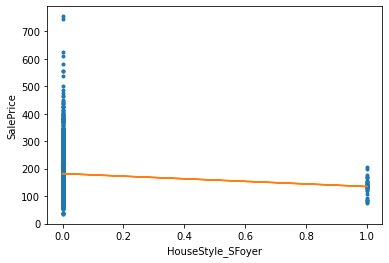




FOR THE FEATURE :  HouseStyle_SLvl
----------------
p_coefficient  -0.0386454334936104
p_value  0.13996361648451133


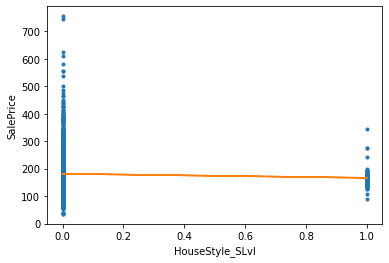




FOR THE FEATURE :  RoofStyle_Flat
----------------
p_coefficient  0.01643347828794214
p_value  0.530379456739671


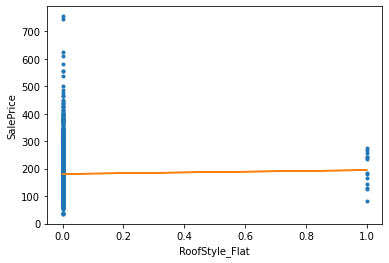




FOR THE FEATURE :  RoofStyle_Gable
----------------
p_coefficient  -0.22474411621309393
p_value  3.5760328081863556e-18


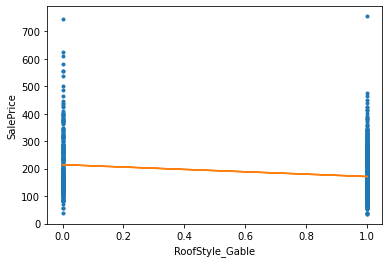




FOR THE FEATURE :  RoofStyle_Gambrel
----------------
p_coefficient  -0.035121434493649045
p_value  0.17983848652314016


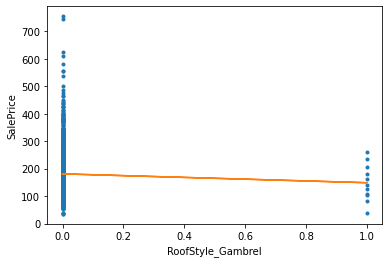




FOR THE FEATURE :  RoofStyle_Hip
----------------
p_coefficient  0.23589691866460114
p_value  6.534124449108714e-20


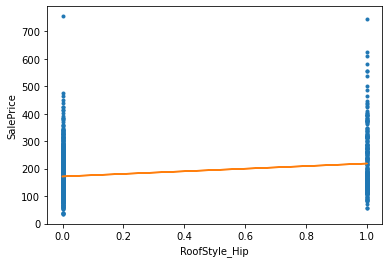




FOR THE FEATURE :  RoofStyle_Mansard
----------------
p_coefficient  -0.00030831909381732396
p_value  0.9906085044169727


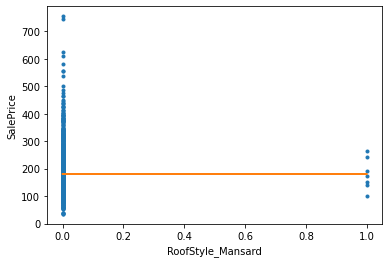




FOR THE FEATURE :  RoofStyle_Shed
----------------
p_coefficient  0.020557102562781884
p_value  0.4325145743746945


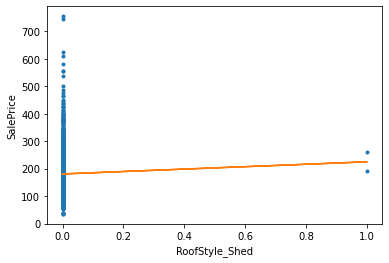




FOR THE FEATURE :  RoofMatl_ClyTile
----------------
p_coefficient  -0.0068969126158057404
p_value  0.7923131339893849


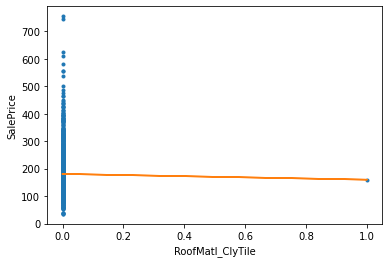




FOR THE FEATURE :  RoofMatl_CompShg
----------------
p_coefficient  -0.10450516998584047
p_value  6.316189362576108e-05


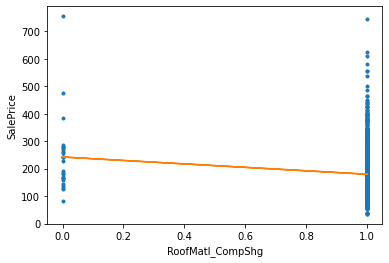




FOR THE FEATURE :  RoofMatl_Membran
----------------
p_coefficient  0.019970498842533133
p_value  0.44576513039897736


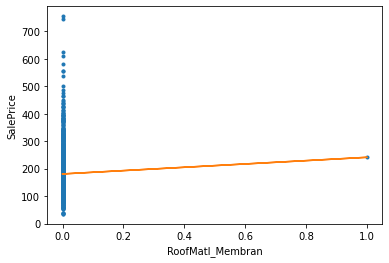




FOR THE FEATURE :  RoofMatl_Metal
----------------
p_coefficient  -0.00030368281007855783
p_value  0.9907497206937822


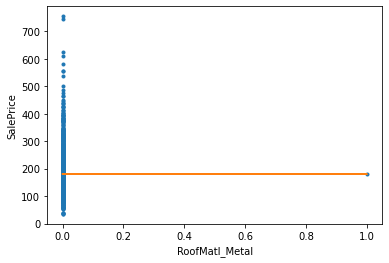




FOR THE FEATURE :  RoofMatl_Roll
----------------
p_coefficient  -0.014479126892392022
p_value  0.5803991485219843


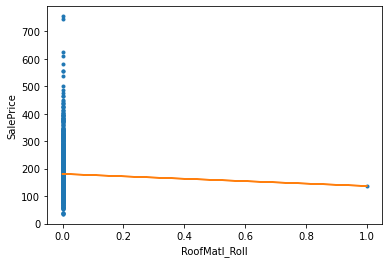




FOR THE FEATURE :  RoofMatl_Tar&Grv
----------------
p_coefficient  0.004920811214208715
p_value  0.8509832429116507


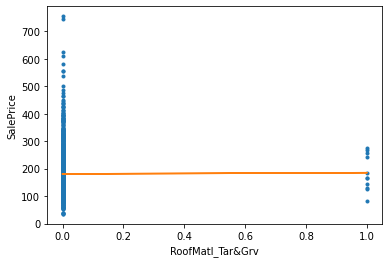




FOR THE FEATURE :  RoofMatl_WdShake
----------------
p_coefficient  0.0446429170044055
p_value  0.08815851140782816


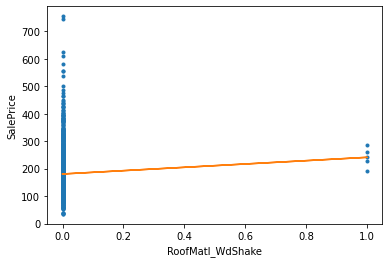




FOR THE FEATURE :  RoofMatl_WdShngl
----------------
p_coefficient  0.16932390580208284
p_value  7.446037898558203e-11


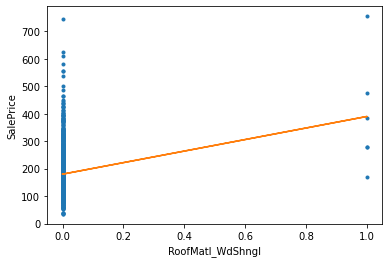




FOR THE FEATURE :  Exterior1st_AsbShng
----------------
p_coefficient  -0.1091258216420073
p_value  2.9330282135738653e-05


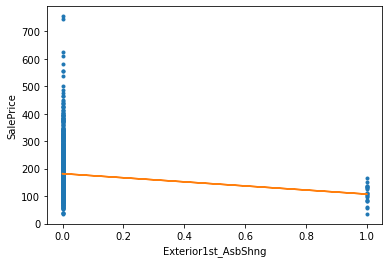




FOR THE FEATURE :  Exterior1st_AsphShn
----------------
p_coefficient  -0.02667660203298748
p_value  0.3083835189825153


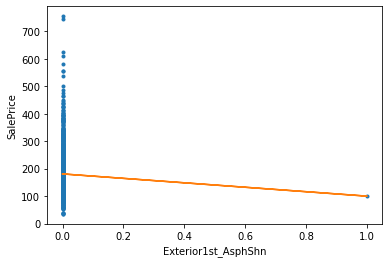




FOR THE FEATURE :  Exterior1st_BrkComm
----------------
p_coefficient  -0.05126412441056306
p_value  0.05018198450300821


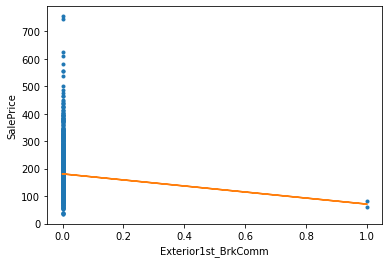




FOR THE FEATURE :  Exterior1st_BrkFace
----------------
p_coefficient  0.032371390691589993
p_value  0.21639402191874954


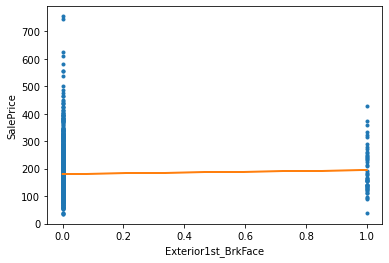




FOR THE FEATURE :  Exterior1st_CBlock
----------------
p_coefficient  -0.025028294581555473
p_value  0.3392438399289361


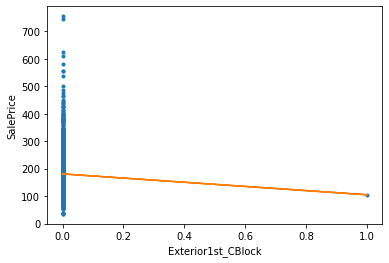




FOR THE FEATURE :  Exterior1st_CemntBd
----------------
p_coefficient  0.13349176235033558
p_value  3.067177836075591e-07


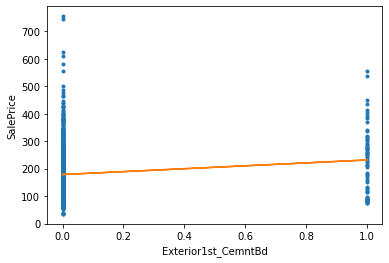




FOR THE FEATURE :  Exterior1st_HdBoard
----------------
p_coefficient  -0.09514764583955283
p_value  0.0002718609965495623


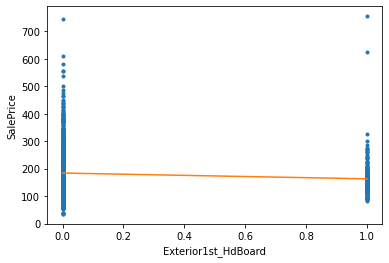




FOR THE FEATURE :  Exterior1st_ImStucc
----------------
p_coefficient  0.026728559393403052
p_value  0.3074418991362615


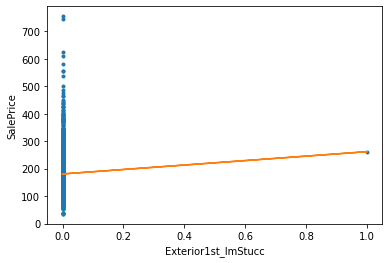




FOR THE FEATURE :  Exterior1st_MetalSd
----------------
p_coefficient  -0.16706804265413472
p_value  1.3327392145260475e-10


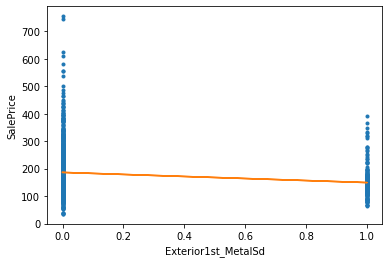




FOR THE FEATURE :  Exterior1st_Plywood
----------------
p_coefficient  -0.01771925649284024
p_value  0.49870734450780524


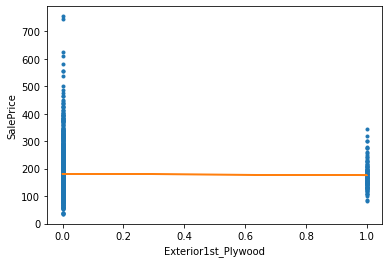




FOR THE FEATURE :  Exterior1st_Stone
----------------
p_coefficient  0.03618055128750293
p_value  0.16705608572648625


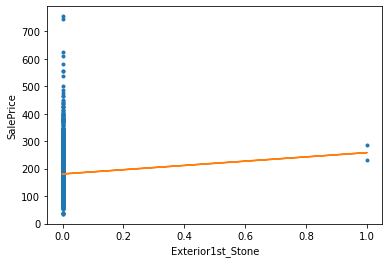




FOR THE FEATURE :  Exterior1st_Stucco
----------------
p_coefficient  -0.029802258156837916
p_value  0.2551120809411086


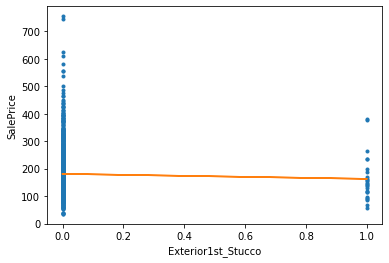




FOR THE FEATURE :  Exterior1st_VinylSd
----------------
p_coefficient  0.3050088024776275
p_value  8.278133715173136e-33


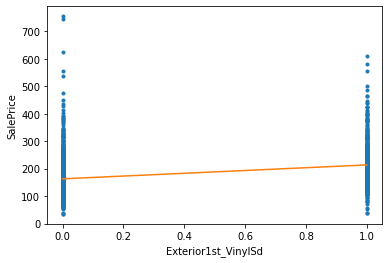




FOR THE FEATURE :  Exterior1st_Wd Sdng
----------------
p_coefficient  -0.1586190816510717
p_value  1.0994777058416348e-09


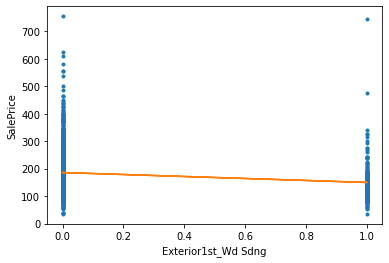




FOR THE FEATURE :  Exterior1st_WdShing
----------------
p_coefficient  -0.05131740614312045
p_value  0.04994349210066954


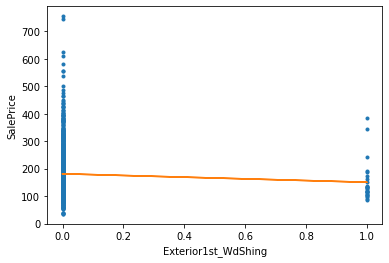




FOR THE FEATURE :  Exterior2nd_AsbShng
----------------
p_coefficient  -0.09922021939101264
p_value  0.00014626570741458776


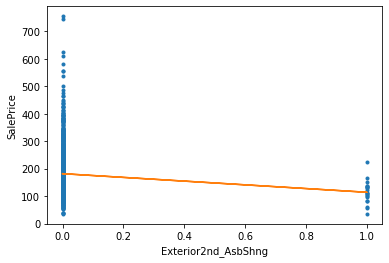




FOR THE FEATURE :  Exterior2nd_AsphShn
----------------
p_coefficient  -0.024524407793441304
p_value  0.3490597986781287


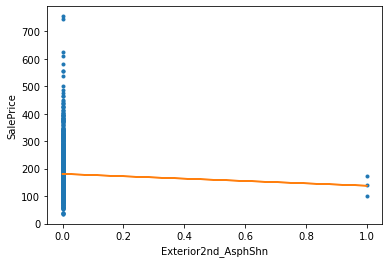




FOR THE FEATURE :  Exterior2nd_Brk Cmn
----------------
p_coefficient  -0.04737690972154201
p_value  0.0703369039871522


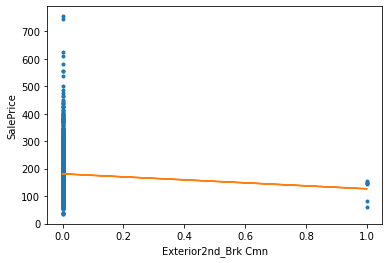




FOR THE FEATURE :  Exterior2nd_BrkFace
----------------
p_coefficient  0.02475899569103643
p_value  0.34446770229361473


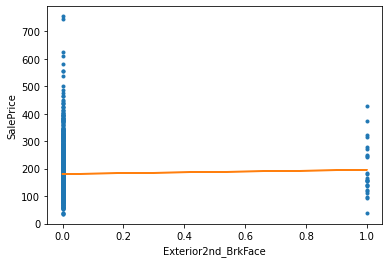




FOR THE FEATURE :  Exterior2nd_CBlock
----------------
p_coefficient  -0.025028294581555473
p_value  0.3392438399289361


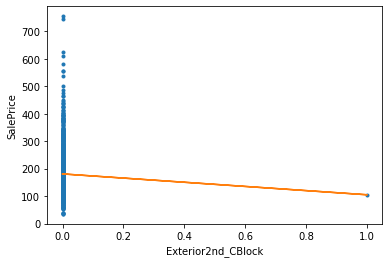




FOR THE FEATURE :  Exterior2nd_CmentBd
----------------
p_coefficient  0.12818316002692498
p_value  8.925468841647316e-07


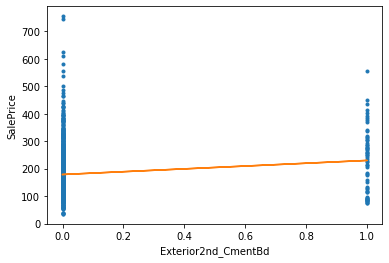




FOR THE FEATURE :  Exterior2nd_HdBoard
----------------
p_coefficient  -0.06786360534380856
p_value  0.009491218916545802


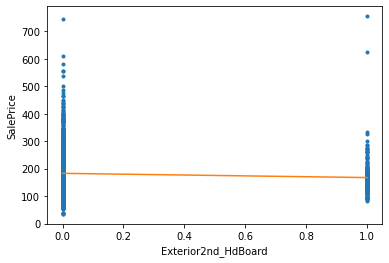




FOR THE FEATURE :  Exterior2nd_ImStucc
----------------
p_coefficient  0.07440111895297474
p_value  0.004449924009678522


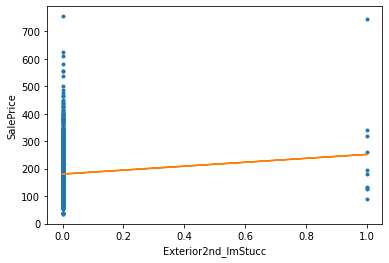




FOR THE FEATURE :  Exterior2nd_MetalSd
----------------
p_coefficient  -0.16238867058442932
p_value  4.3473971456771284e-10


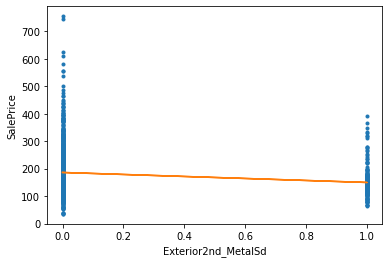




FOR THE FEATURE :  Exterior2nd_Other
----------------
p_coefficient  0.04551926433972624
p_value  0.08208751278245542


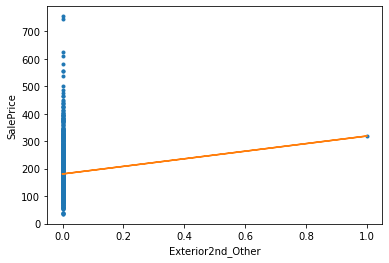




FOR THE FEATURE :  Exterior2nd_Plywood
----------------
p_coefficient  -0.052940868975969856
p_value  0.043119193652604915


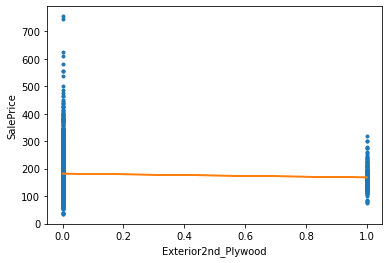




FOR THE FEATURE :  Exterior2nd_Stone
----------------
p_coefficient  -0.016753527668945736
p_value  0.5224014735380291


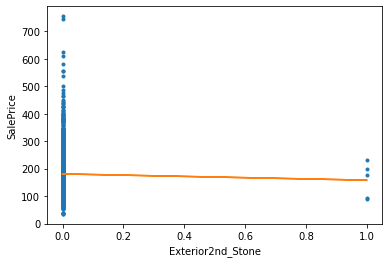




FOR THE FEATURE :  Exterior2nd_Stucco
----------------
p_coefficient  -0.042415692314699154
p_value  0.10522319725414639


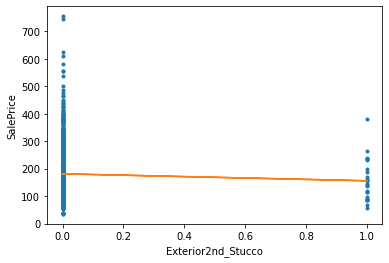




FOR THE FEATURE :  Exterior2nd_VinylSd
----------------
p_coefficient  0.30638888087148436
p_value  4.1813926084977454e-33


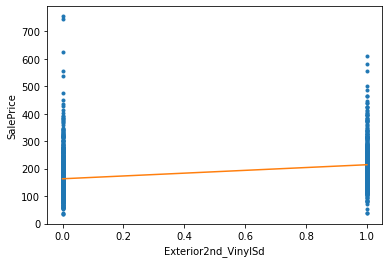




FOR THE FEATURE :  Exterior2nd_Wd Sdng
----------------
p_coefficient  -0.1618004951731796
p_value  5.031880322887711e-10


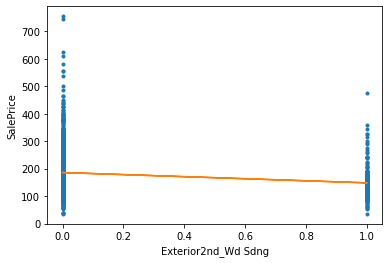




FOR THE FEATURE :  Exterior2nd_Wd Shng
----------------
p_coefficient  -0.04032943564551995
p_value  0.12348910624435222


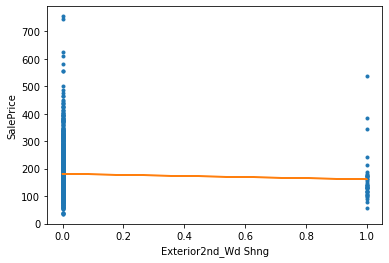




FOR THE FEATURE :  MasVnrType_BrkCmn
----------------
p_coefficient  -0.044393863680548054
p_value  0.0899483421655357


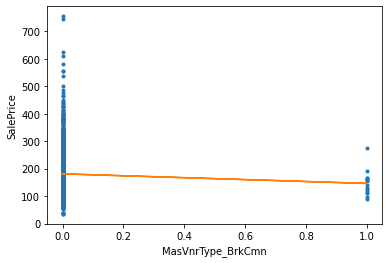




FOR THE FEATURE :  MasVnrType_BrkFace
----------------
p_coefficient  0.19819120620063635
p_value  2.1334385336479874e-14


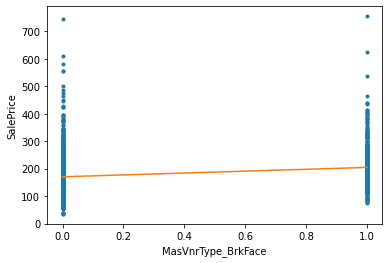




FOR THE FEATURE :  MasVnrType_None
----------------
p_coefficient  -0.3744676734554557
p_value  8.145421031458332e-50


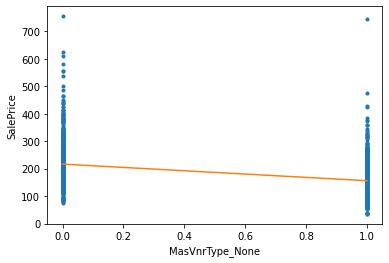




FOR THE FEATURE :  MasVnrType_Stone
----------------
p_coefficient  0.3304756465434074
p_value  1.5247401637353435e-38


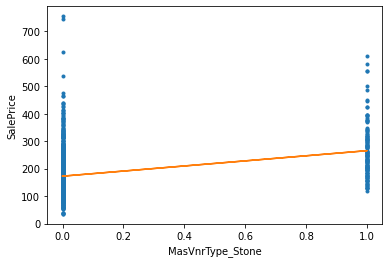




FOR THE FEATURE :  MasVnrType_unknow
----------------
p_coefficient  0.05193302955427022
p_value  0.047256115632923174


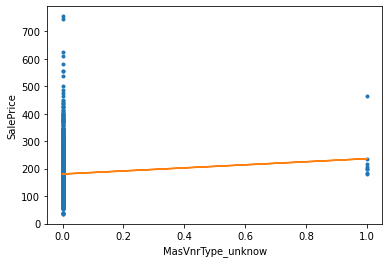




FOR THE FEATURE :  ExterQual_Ex
----------------
p_coefficient  0.451164330222753
p_value  4.067723705115161e-74


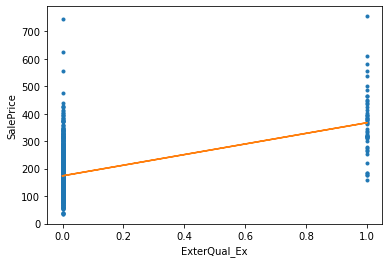




FOR THE FEATURE :  ExterQual_Fa
----------------
p_coefficient  -0.11514885538091939
p_value  1.0301714520733479e-05


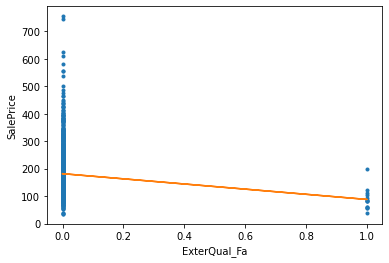




FOR THE FEATURE :  ExterQual_Gd
----------------
p_coefficient  0.45246612784479184
p_value  1.3808580052669518e-74


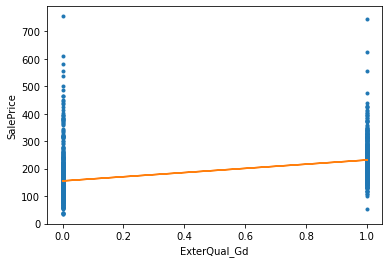




FOR THE FEATURE :  ExterQual_TA
----------------
p_coefficient  -0.5890435234097635
p_value  4.309567397252333e-137


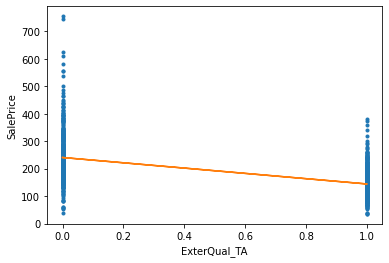




FOR THE FEATURE :  ExterCond_Ex
----------------
p_coefficient  0.01166313221710201
p_value  0.6561166227694873


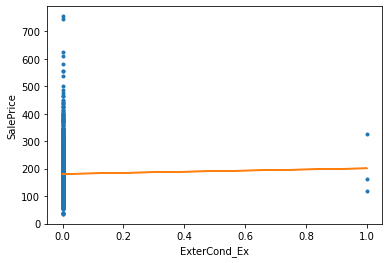




FOR THE FEATURE :  ExterCond_Fa
----------------
p_coefficient  -0.1379143994331372
p_value  1.219907516896575e-07


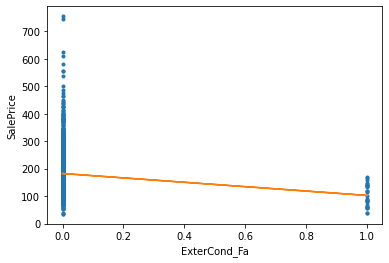




FOR THE FEATURE :  ExterCond_Gd
----------------
p_coefficient  -0.05046730552645428
p_value  0.053863837749816686


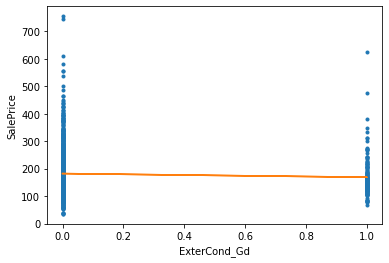




FOR THE FEATURE :  ExterCond_Po
----------------
p_coefficient  -0.03442364705471771
p_value  0.18864816045175248


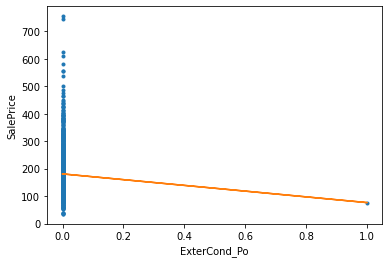




FOR THE FEATURE :  ExterCond_TA
----------------
p_coefficient  0.10522203398149478
p_value  5.618844102270956e-05


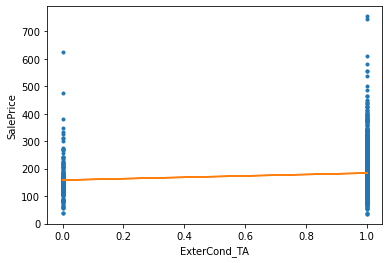




FOR THE FEATURE :  Foundation_BrkTil
----------------
p_coefficient  -0.2041173657826988
p_value  3.3886491752503356e-15


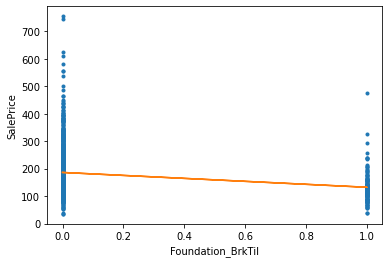




FOR THE FEATURE :  Foundation_CBlock
----------------
p_coefficient  -0.34326299944464994
p_value  1.2301562341803228e-41


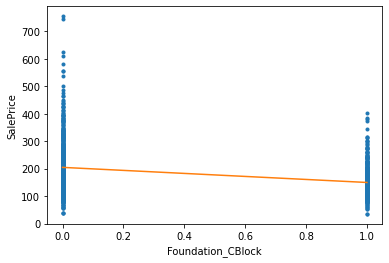




FOR THE FEATURE :  Foundation_PConc
----------------
p_coefficient  0.49773375258694347
p_value  3.1247035109724295e-92


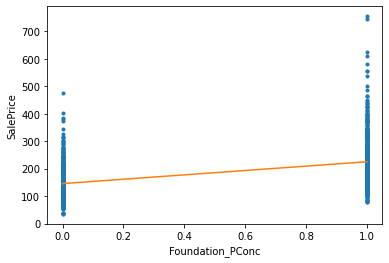




FOR THE FEATURE :  Foundation_Slab
----------------
p_coefficient  -0.11974016023648018
p_value  4.4780961034340505e-06


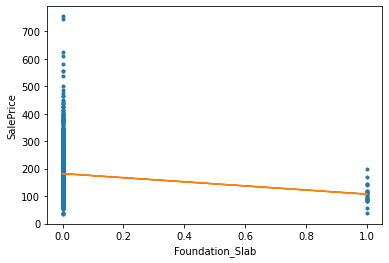




FOR THE FEATURE :  Foundation_Stone
----------------
p_coefficient  -0.012102630775853286
p_value  0.6440370656221419


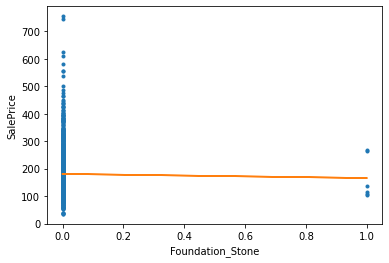




FOR THE FEATURE :  Foundation_Wood
----------------
p_coefficient  0.0027114775829149983
p_value  0.9175527650464534


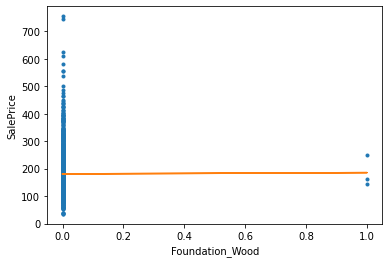




FOR THE FEATURE :  BsmtQual_Ex
----------------
p_coefficient  0.5531048470089426
p_value  9.157709122309411e-118


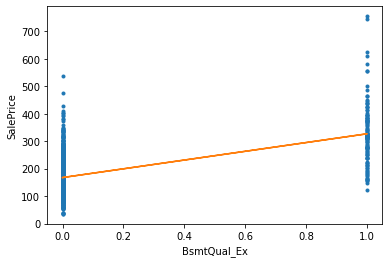




FOR THE FEATURE :  BsmtQual_Fa
----------------
p_coefficient  -0.12872541129366064
p_value  8.018265786606537e-07


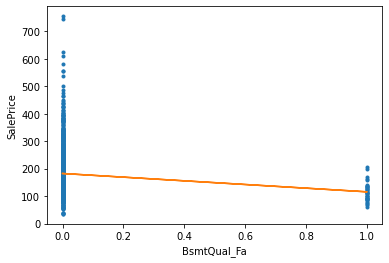




FOR THE FEATURE :  BsmtQual_Gd
----------------
p_coefficient  0.23482172845401858
p_value  9.69967195109226e-20


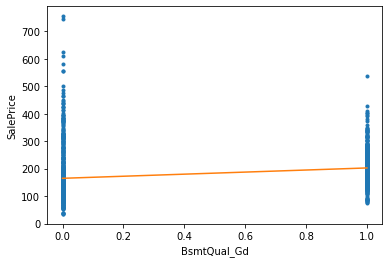




FOR THE FEATURE :  BsmtQual_TA
----------------
p_coefficient  -0.4523935323501031
p_value  1.4667902438137903e-74


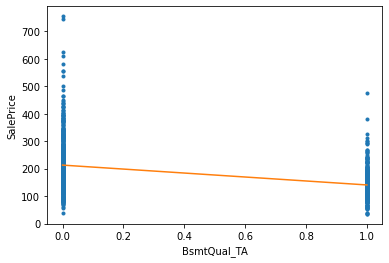




FOR THE FEATURE :  BsmtQual_unknow
----------------
p_coefficient  -0.15282922324994463
p_value  4.381564599226358e-09


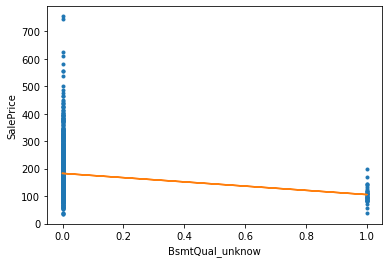




FOR THE FEATURE :  BsmtCond_Fa
----------------
p_coefficient  -0.13273855172329796
p_value  3.578221973637565e-07


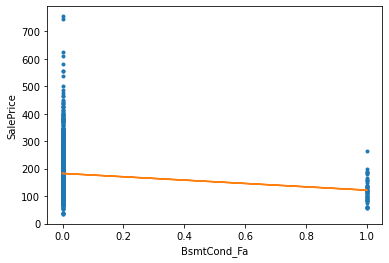




FOR THE FEATURE :  BsmtCond_Gd
----------------
p_coefficient  0.08882400808170247
p_value  0.0006793716983122161


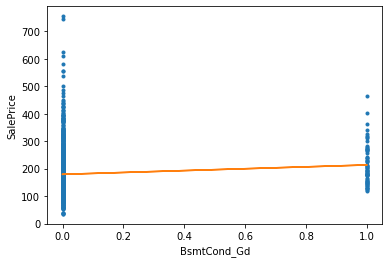




FOR THE FEATURE :  BsmtCond_Po
----------------
p_coefficient  -0.0545287256366241
p_value  0.037223415356518616


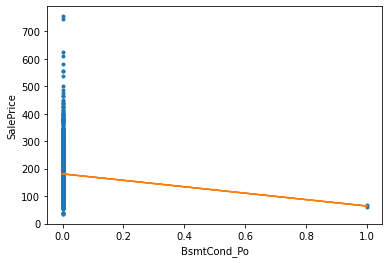




FOR THE FEATURE :  BsmtCond_TA
----------------
p_coefficient  0.10127486495836965
p_value  0.00010602955770174107


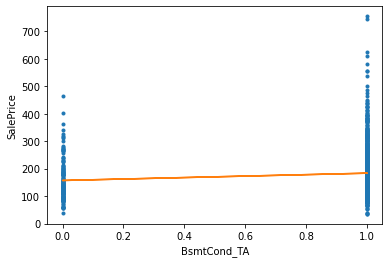




FOR THE FEATURE :  BsmtCond_unknow
----------------
p_coefficient  -0.15282922324994463
p_value  4.381564599226358e-09


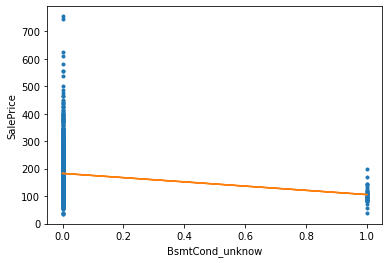




FOR THE FEATURE :  BsmtExposure_Av
----------------
p_coefficient  0.1367933164209502
p_value  1.545359021685937e-07


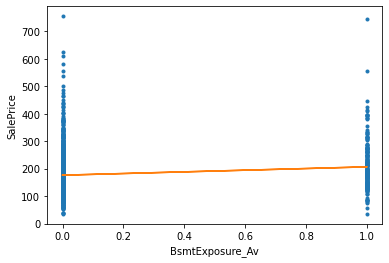




FOR THE FEATURE :  BsmtExposure_Gd
----------------
p_coefficient  0.30729831458669854
p_value  2.66065625179679e-33


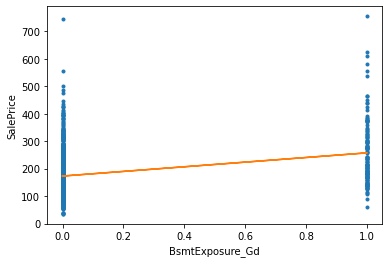




FOR THE FEATURE :  BsmtExposure_Mn
----------------
p_coefficient  0.043493083940889056
p_value  0.09666704058114148


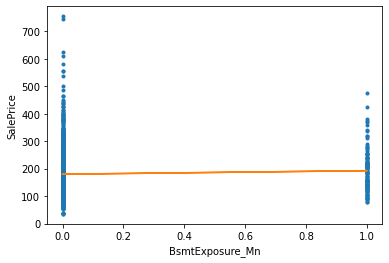




FOR THE FEATURE :  BsmtExposure_No
----------------
p_coefficient  -0.26360041187142064
p_value  1.2428742118654617e-24


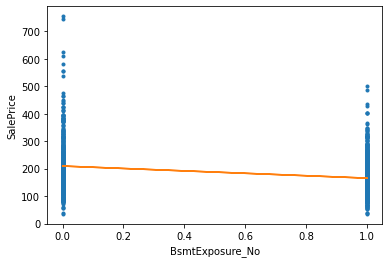




FOR THE FEATURE :  BsmtExposure_unknow
----------------
p_coefficient  -0.1502307048448762
p_value  8.014403944929107e-09


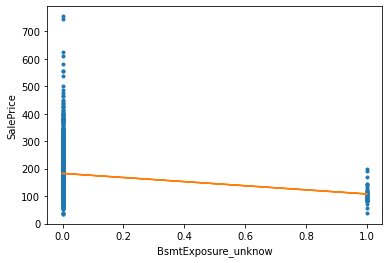




FOR THE FEATURE :  BsmtFinType1_ALQ
----------------
p_coefficient  -0.10262077890522307
p_value  8.560167458684695e-05


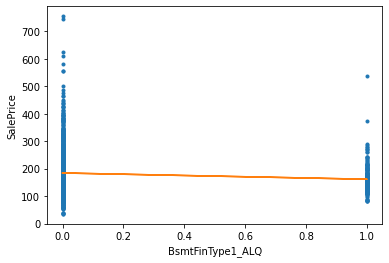




FOR THE FEATURE :  BsmtFinType1_BLQ
----------------
p_coefficient  -0.1329138378257025
p_value  3.4524279272180156e-07


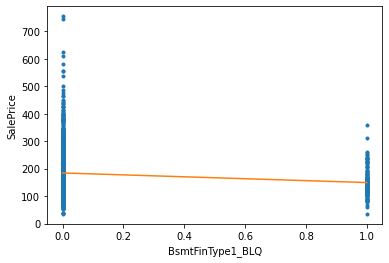




FOR THE FEATURE :  BsmtFinType1_GLQ
----------------
p_coefficient  0.43459734688277724
p_value  2.5449861137815995e-68


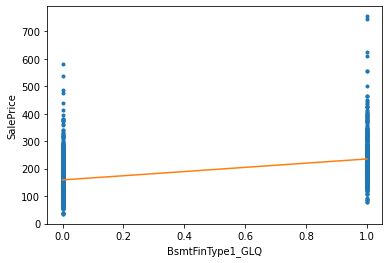




FOR THE FEATURE :  BsmtFinType1_LwQ
----------------
p_coefficient  -0.08457706852755623
p_value  0.0012176443771339048


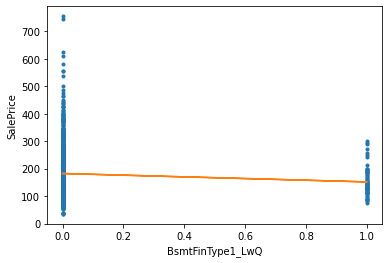




FOR THE FEATURE :  BsmtFinType1_Rec
----------------
p_coefficient  -0.1356666273433359
p_value  1.956237421263163e-07


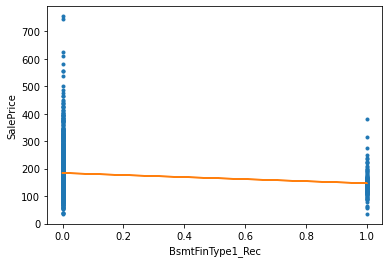




FOR THE FEATURE :  BsmtFinType1_Unf
----------------
p_coefficient  -0.08339914089154482
p_value  0.0014251667387035433


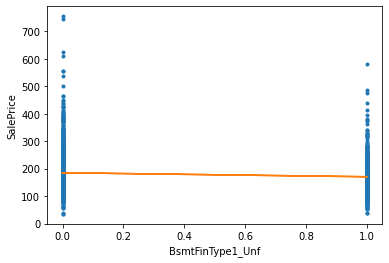




FOR THE FEATURE :  BsmtFinType1_unknow
----------------
p_coefficient  -0.15282922324994463
p_value  4.381564599226358e-09


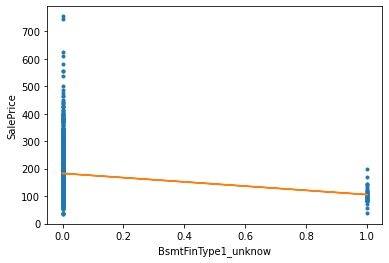




FOR THE FEATURE :  BsmtFinType2_ALQ
----------------
p_coefficient  0.041961566284397046
p_value  0.10900491978405841


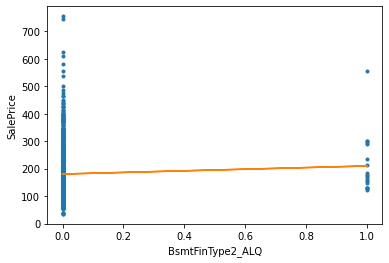




FOR THE FEATURE :  BsmtFinType2_BLQ
----------------
p_coefficient  -0.057102002531656086
p_value  0.029126070587884474


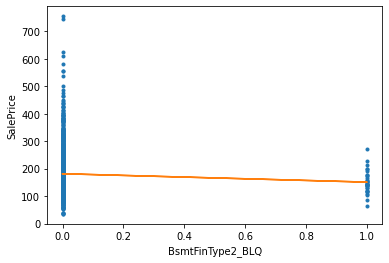




FOR THE FEATURE :  BsmtFinType2_GLQ
----------------
p_coefficient  7.551406179757066e-05
p_value  0.9976997682914682


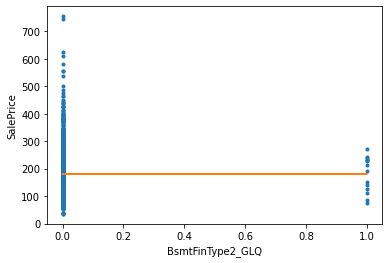




FOR THE FEATURE :  BsmtFinType2_LwQ
----------------
p_coefficient  -0.03760394773113771
p_value  0.15096760242139903


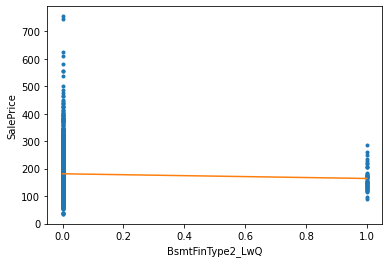




FOR THE FEATURE :  BsmtFinType2_Rec
----------------
p_coefficient  -0.039493936531656025
p_value  0.13146314195187397


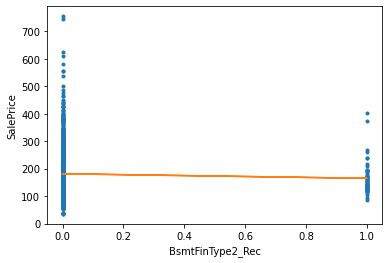




FOR THE FEATURE :  BsmtFinType2_Unf
----------------
p_coefficient  0.11790149415647323
p_value  6.274755969969344e-06


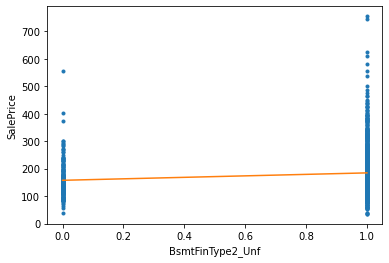




FOR THE FEATURE :  BsmtFinType2_unknow
----------------
p_coefficient  -0.14527420198499913
p_value  2.4643943739310623e-08


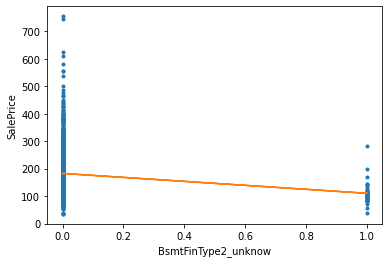




FOR THE FEATURE :  Heating_Floor
----------------
p_coefficient  -0.035742293015862237
p_value  0.17226012328655485


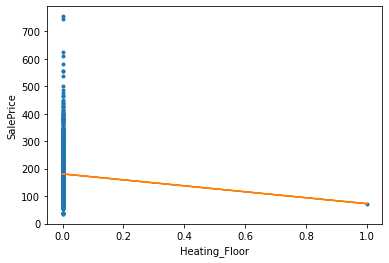




FOR THE FEATURE :  Heating_GasA
----------------
p_coefficient  0.09252891316304189
p_value  0.00039998562653741315


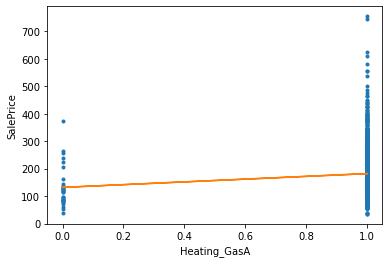




FOR THE FEATURE :  Heating_GasW
----------------
p_coefficient  -0.020102599035433613
p_value  0.4427611787811376


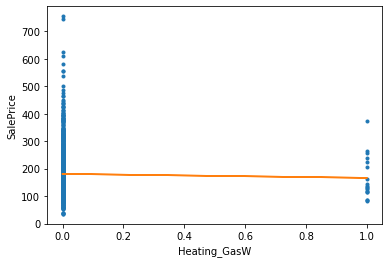




FOR THE FEATURE :  Heating_Grav
----------------
p_coefficient  -0.09233803351104615
p_value  0.00041124723083922556


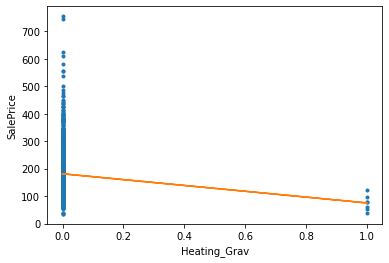




FOR THE FEATURE :  Heating_OthW
----------------
p_coefficient  -0.025730279106727816
p_value  0.32586679749929676


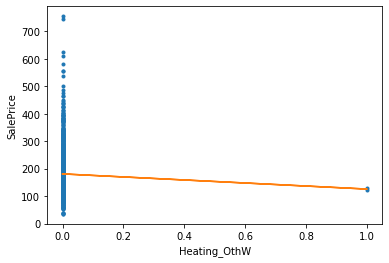




FOR THE FEATURE :  Heating_Wall
----------------
p_coefficient  -0.058622156149097944
p_value  0.025093688709243063


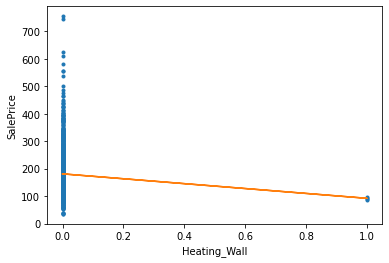




FOR THE FEATURE :  HeatingQC_Ex
----------------
p_coefficient  0.43454323853246696
p_value  2.655183758356968e-68


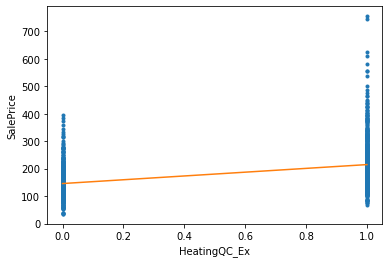




FOR THE FEATURE :  HeatingQC_Fa
----------------
p_coefficient  -0.1337575333426303
p_value  2.90426012339113e-07


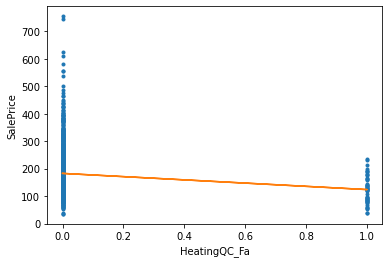




FOR THE FEATURE :  HeatingQC_Gd
----------------
p_coefficient  -0.13472249330663577
p_value  2.380061192327949e-07


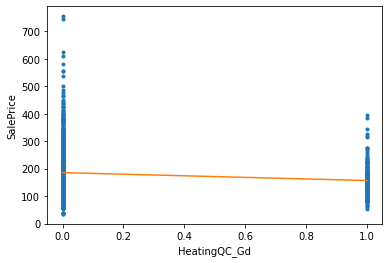




FOR THE FEATURE :  HeatingQC_Po
----------------
p_coefficient  -0.030962201406710688
p_value  0.23707311374946366


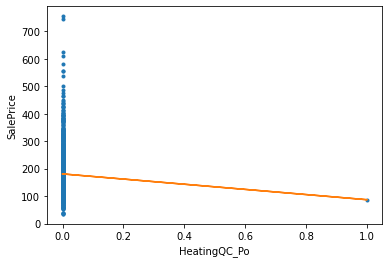




FOR THE FEATURE :  HeatingQC_TA
----------------
p_coefficient  -0.3126770454351807
p_value  1.7764321121507641e-34


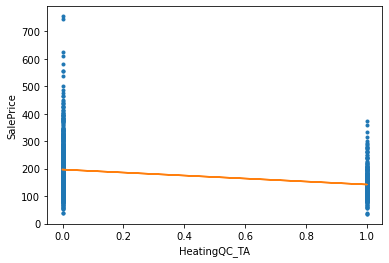




FOR THE FEATURE :  Electrical_FuseA
----------------
p_coefficient  -0.19397792356662547
p_value  7.623441910084123e-14


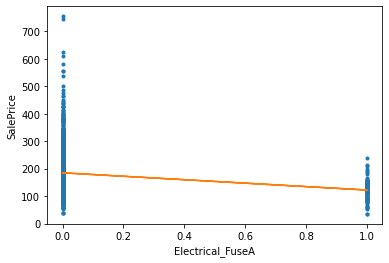




FOR THE FEATURE :  Electrical_FuseF
----------------
p_coefficient  -0.12660098635768127
p_value  1.2172341995053213e-06


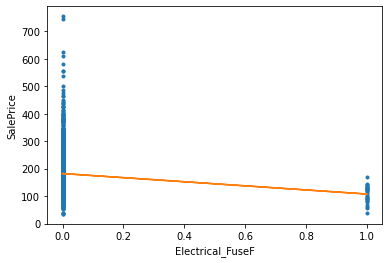




FOR THE FEATURE :  Electrical_FuseP
----------------
p_coefficient  -0.04776061769494804
p_value  0.06809030167682434


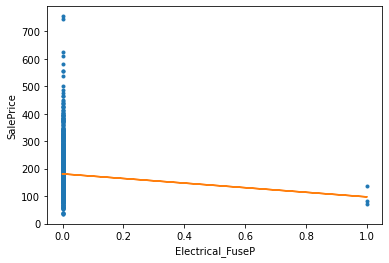




FOR THE FEATURE :  Electrical_Mix
----------------
p_coefficient  -0.03755543121243805
p_value  0.15149582608733997


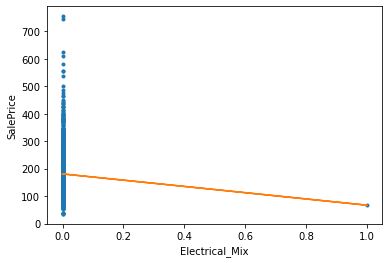




FOR THE FEATURE :  Electrical_SBrkr
----------------
p_coefficient  0.24189604705962817
p_value  6.951959173962046e-21


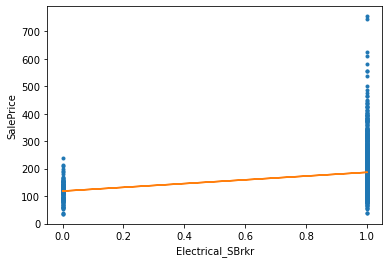




FOR THE FEATURE :  Electrical_unknow
----------------
p_coefficient  -0.004424451438658031
p_value  0.8658642238833446


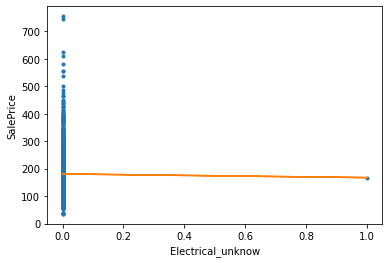




FOR THE FEATURE :  KitchenQual_Ex
----------------
p_coefficient  0.5040936759052951
p_value  6.256631383371697e-95


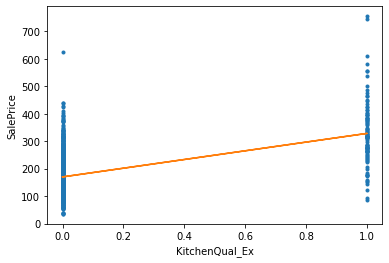




FOR THE FEATURE :  KitchenQual_Fa
----------------
p_coefficient  -0.15719868628269343
p_value  1.5508047884776215e-09


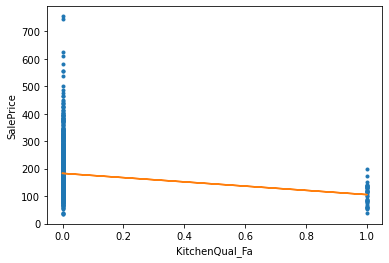




FOR THE FEATURE :  KitchenQual_Gd
----------------
p_coefficient  0.3216411088189493
p_value  1.7212163713049047e-36


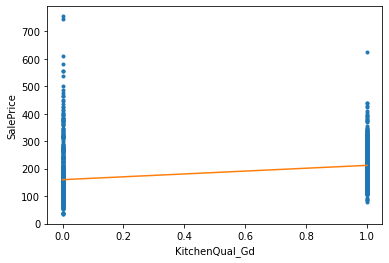




FOR THE FEATURE :  KitchenQual_TA
----------------
p_coefficient  -0.5192978536548851
p_value  1.2856089420578816e-101


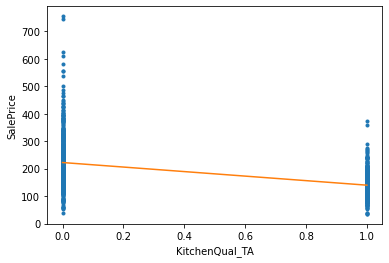




FOR THE FEATURE :  Functional_Maj1
----------------
p_coefficient  -0.03341995349143352
p_value  0.20187161486301464


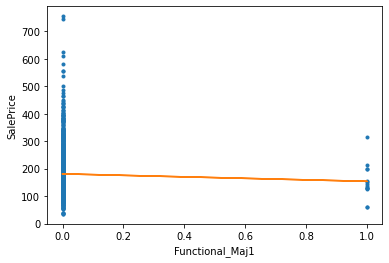




FOR THE FEATURE :  Functional_Maj2
----------------
p_coefficient  -0.07021447788221274
p_value  0.007276746373368094


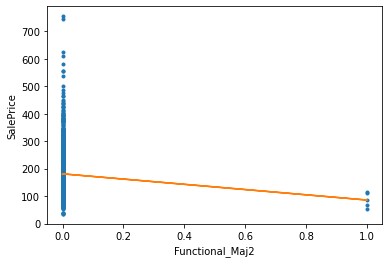




FOR THE FEATURE :  Functional_Min1
----------------
p_coefficient  -0.06405145656743245
p_value  0.014372332930391564


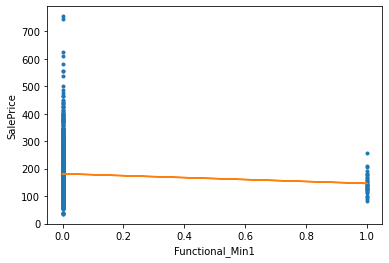




FOR THE FEATURE :  Functional_Min2
----------------
p_coefficient  -0.07132000820499279
p_value  0.006405423057908905


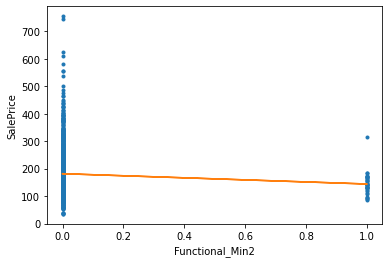




FOR THE FEATURE :  Functional_Mod
----------------
p_coefficient  -0.0160725412713806
p_value  0.5394502238732652


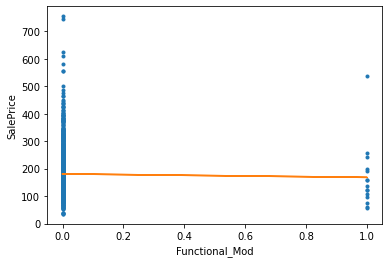




FOR THE FEATURE :  Functional_Sev
----------------
p_coefficient  -0.017116418814683124
p_value  0.5134306710714353


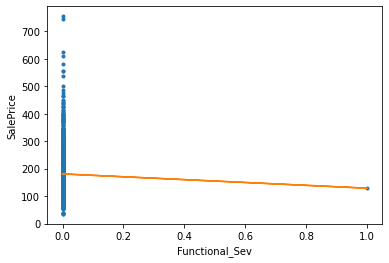




FOR THE FEATURE :  Functional_Typ
----------------
p_coefficient  0.116462040218004
p_value  8.143129270443283e-06


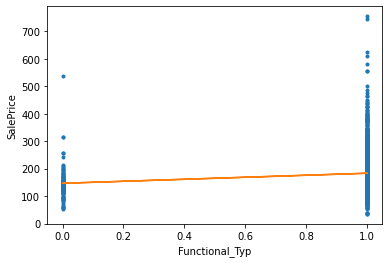




FOR THE FEATURE :  FireplaceQu_Ex
----------------
p_coefficient  0.2552385312288608
p_value  3.8093918083290545e-23


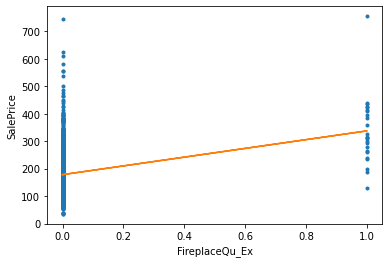




FOR THE FEATURE :  FireplaceQu_Fa
----------------
p_coefficient  -0.026085813898165007
p_value  0.31922423337551725


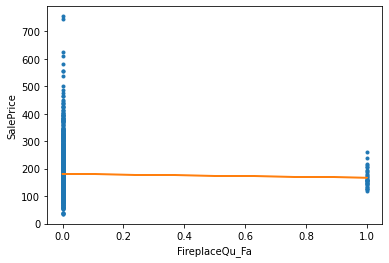




FOR THE FEATURE :  FireplaceQu_Gd
----------------
p_coefficient  0.33932872327044494
p_value  1.1408835171848025e-40


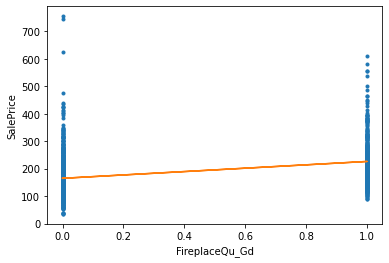




FOR THE FEATURE :  FireplaceQu_Po
----------------
p_coefficient  -0.07591630695524935
p_value  0.0037024120867202442


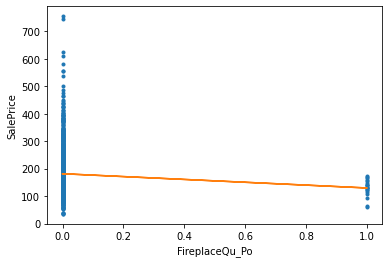




FOR THE FEATURE :  FireplaceQu_TA
----------------
p_coefficient  0.1631466482099496
p_value  3.5979369796718363e-10


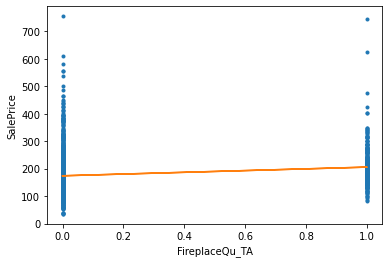




FOR THE FEATURE :  FireplaceQu_unknow
----------------
p_coefficient  -0.4719080685164925
p_value  7.680089360253177e-82


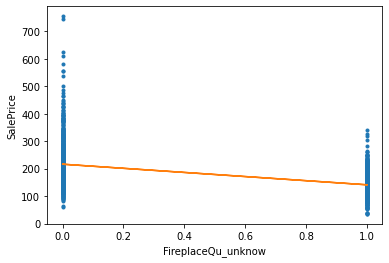




FOR THE FEATURE :  GarageType_2Types
----------------
p_coefficient  -0.02397376065437425
p_value  0.35999055859474866


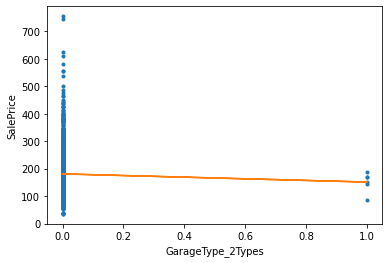




FOR THE FEATURE :  GarageType_Attchd
----------------
p_coefficient  0.33596064720954777
p_value  7.486283069199315e-40


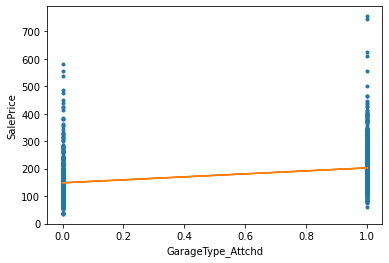




FOR THE FEATURE :  GarageType_Basment
----------------
p_coefficient  -0.02942496852213696
p_value  0.2611798832180398


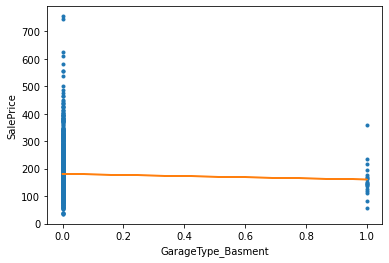




FOR THE FEATURE :  GarageType_BuiltIn
----------------
p_coefficient  0.23544865016730646
p_value  7.705883974693705e-20


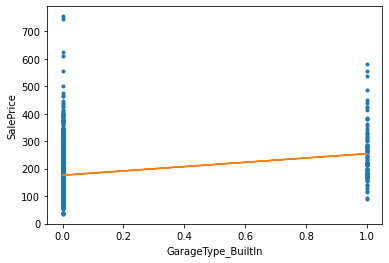




FOR THE FEATURE :  GarageType_CarPort
----------------
p_coefficient  -0.07037062648692732
p_value  0.007147558237279599


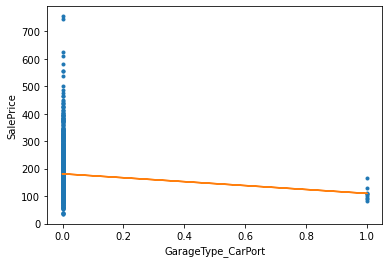




FOR THE FEATURE :  GarageType_Detchd
----------------
p_coefficient  -0.3541407884127017
p_value  2.1987906127518105e-44


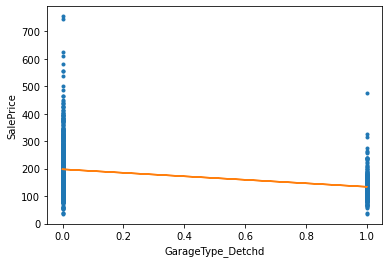




FOR THE FEATURE :  GarageType_unknow
----------------
p_coefficient  -0.23683171182004567
p_value  4.627259402062822e-20


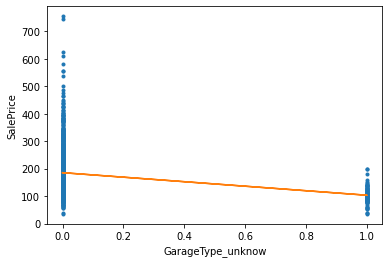




FOR THE FEATURE :  GarageFinish_Fin
----------------
p_coefficient  0.4196779678180175
p_value  2.2742041144979052e-63


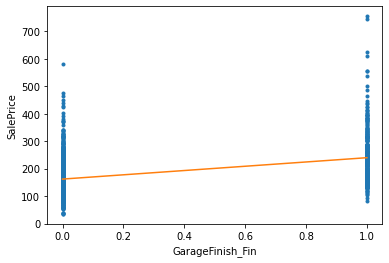




FOR THE FEATURE :  GarageFinish_RFn
----------------
p_coefficient  0.16979152720952193
p_value  6.593059398278521e-11


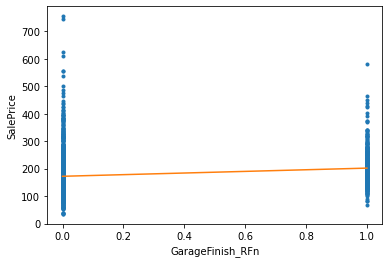




FOR THE FEATURE :  GarageFinish_Unf
----------------
p_coefficient  -0.4106083112916715
p_value  1.765709904533942e-60


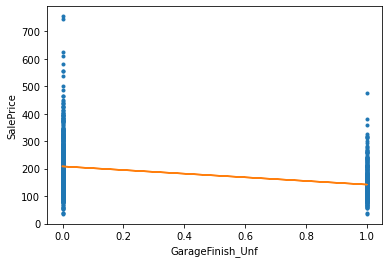




FOR THE FEATURE :  GarageFinish_unknow
----------------
p_coefficient  -0.23683171182004567
p_value  4.627259402062822e-20


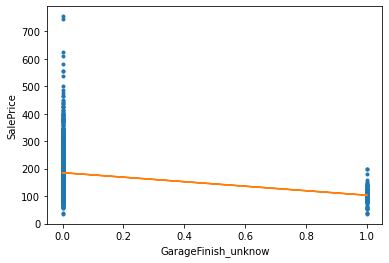




FOR THE FEATURE :  GarageQual_Ex
----------------
p_coefficient  0.034327959907916185
p_value  0.18988059738730037


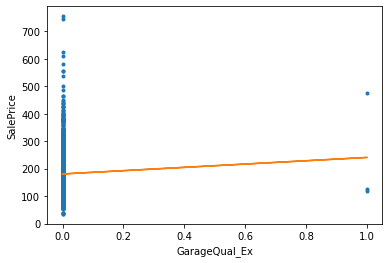




FOR THE FEATURE :  GarageQual_Fa
----------------
p_coefficient  -0.1331423480721318
p_value  3.2948275580047456e-07


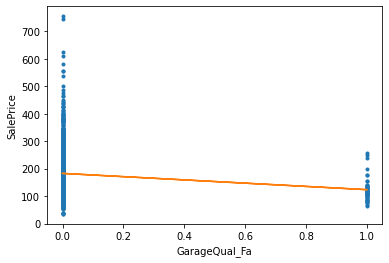




FOR THE FEATURE :  GarageQual_Gd
----------------
p_coefficient  0.043290504724990984
p_value  0.09823194140380462


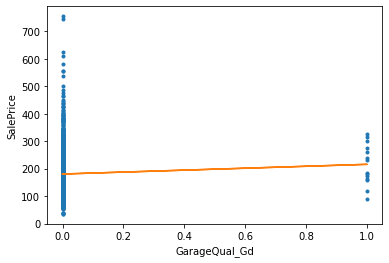




FOR THE FEATURE :  GarageQual_Po
----------------
p_coefficient  -0.046141701431318426
p_value  0.07798475263051959


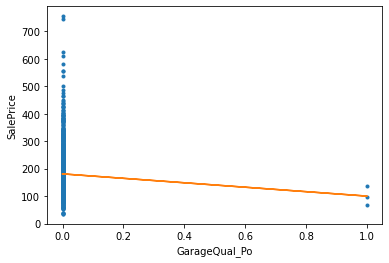




FOR THE FEATURE :  GarageQual_TA
----------------
p_coefficient  0.24534631715662966
p_value  1.863218777974911e-21


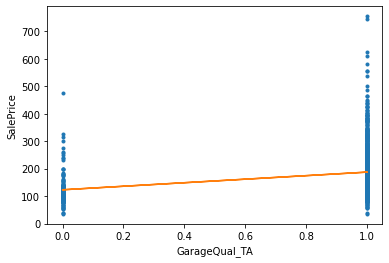




FOR THE FEATURE :  GarageQual_unknow
----------------
p_coefficient  -0.23683171182004567
p_value  4.627259402062822e-20


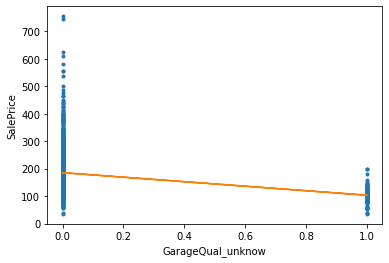




FOR THE FEATURE :  GarageCond_Ex
----------------
p_coefficient  -0.026546429413243013
p_value  0.3107509878374145


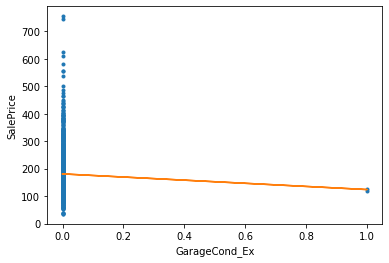




FOR THE FEATURE :  GarageCond_Fa
----------------
p_coefficient  -0.13077383506503001
p_value  5.327445783978943e-07


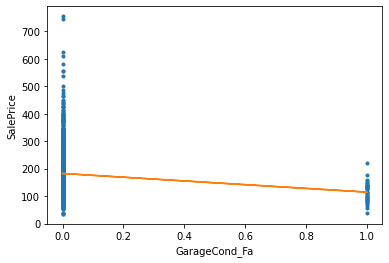




FOR THE FEATURE :  GarageCond_Gd
----------------
p_coefficient  -0.000982975978289872
p_value  0.9700645742473607


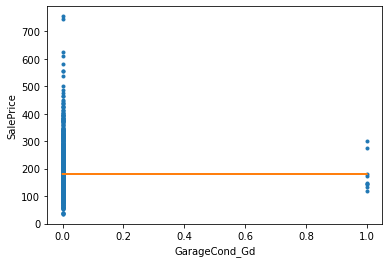




FOR THE FEATURE :  GarageCond_Po
----------------
p_coefficient  -0.06329621903329452
p_value  0.015567544996814226


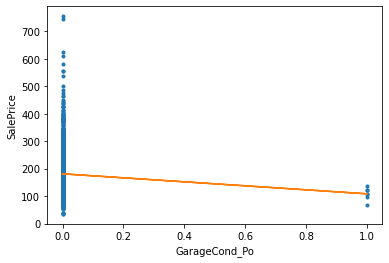




FOR THE FEATURE :  GarageCond_TA
----------------
p_coefficient  0.27587200180506544
p_value  6.523849679026881e-27


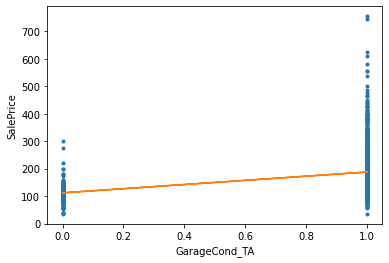




FOR THE FEATURE :  GarageCond_unknow
----------------
p_coefficient  -0.23683171182004567
p_value  4.627259402062822e-20


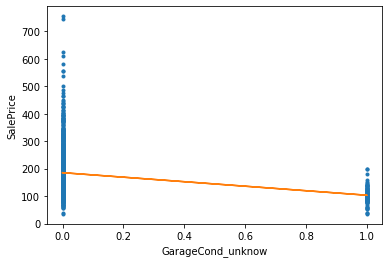




FOR THE FEATURE :  PavedDrive_N
----------------
p_coefficient  -0.21262978253141193
p_value  2.18098097425581e-16


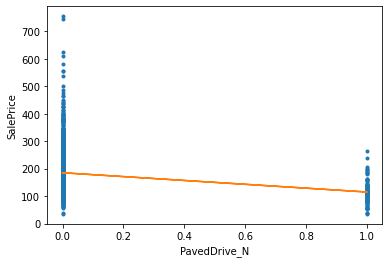




FOR THE FEATURE :  PavedDrive_P
----------------
p_coefficient  -0.08862292093317171
p_value  0.0006988018924944264


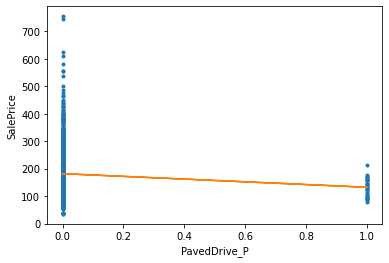




FOR THE FEATURE :  PavedDrive_Y
----------------
p_coefficient  0.23196803451041814
p_value  2.7414143021031745e-19


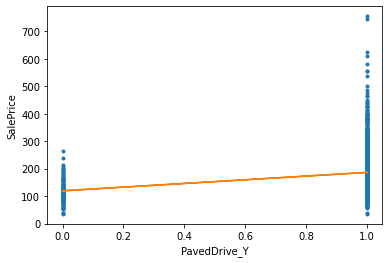




FOR THE FEATURE :  SaleType_COD
----------------
p_coefficient  -0.08104671129791154
p_value  0.0019401938941831709


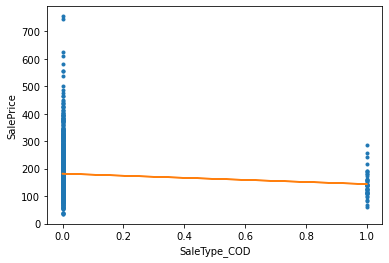




FOR THE FEATURE :  SaleType_CWD
----------------
p_coefficient  0.019588066467574456
p_value  0.4545267122894363


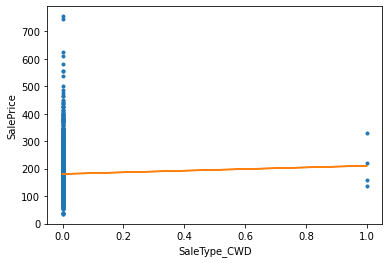




FOR THE FEATURE :  SaleType_Con
----------------
p_coefficient  0.04135727608882842
p_value  0.1142027111523226


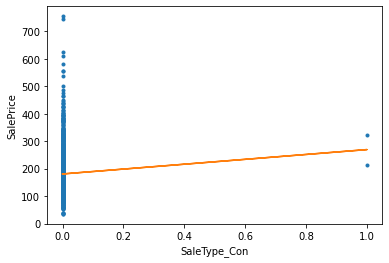




FOR THE FEATURE :  SaleType_ConLD
----------------
p_coefficient  -0.04179084064107932
p_value  0.11045410217550186


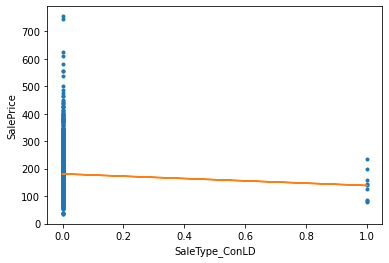




FOR THE FEATURE :  SaleType_ConLI
----------------
p_coefficient  0.014371054765972275
p_value  0.5832283382021348


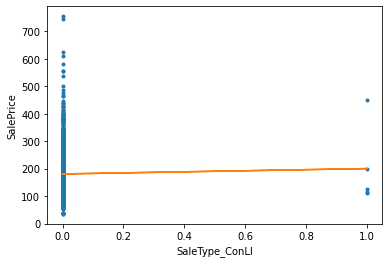




FOR THE FEATURE :  SaleType_ConLw
----------------
p_coefficient  -0.027475125928901747
p_value  0.2941219911059679


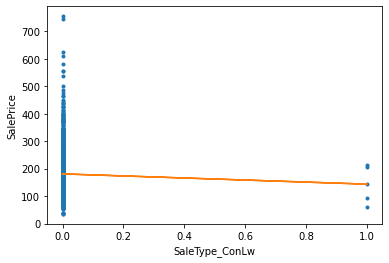




FOR THE FEATURE :  SaleType_New
----------------
p_coefficient  0.35750940508319645
p_value  2.9451467216496274e-45


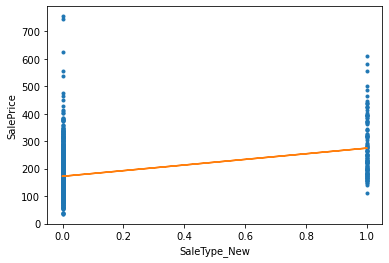




FOR THE FEATURE :  SaleType_Oth
----------------
p_coefficient  -0.03489499491751531
p_value  0.18266320040396128


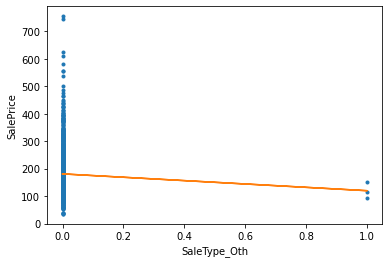




FOR THE FEATURE :  SaleType_WD
----------------
p_coefficient  -0.24259751727294787
p_value  5.3280749505374384e-21


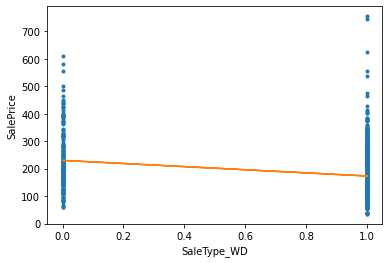




FOR THE FEATURE :  SaleCondition_Abnorml
----------------
p_coefficient  -0.11806923061460149
p_value  6.085845075189089e-06


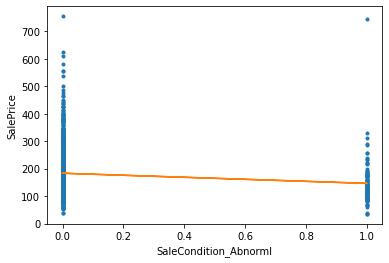




FOR THE FEATURE :  SaleCondition_AdjLand
----------------
p_coefficient  -0.05068563355867175
p_value  0.05283327582639817


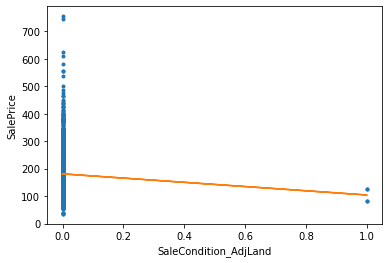




FOR THE FEATURE :  SaleCondition_Alloca
----------------
p_coefficient  -0.015525374015420017
p_value  0.553347580980062


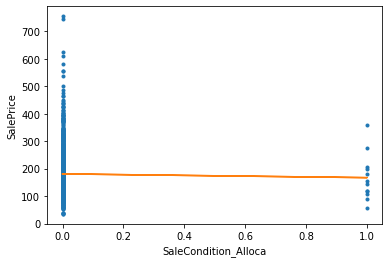




FOR THE FEATURE :  SaleCondition_Family
----------------
p_coefficient  -0.04648019603234434
p_value  0.07582456712071753


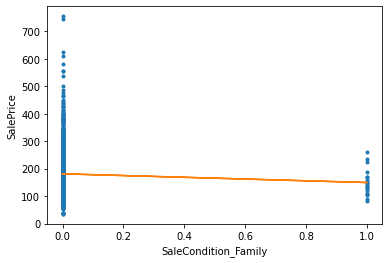




FOR THE FEATURE :  SaleCondition_Normal
----------------
p_coefficient  -0.15398979048536718
p_value  3.3347146907429616e-09


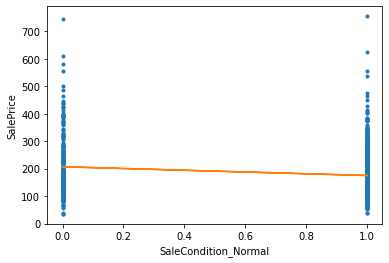




FOR THE FEATURE :  SaleCondition_Partial
----------------
p_coefficient  0.3520598546714335
p_value  7.520572440332955e-44


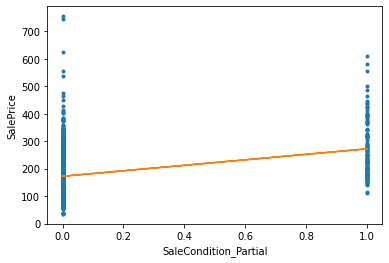

In [17]:
feature = [i for i in train.columns if i != 'SalePrice']
target = 'SalePrice'
X = train[feature]
y = train[target]
model = LinearRegression()
for i in feature:
    model.fit(X[[i]], y)
    w = model.coef_
    b = model.intercept_
    f_wb = w*X[i] + b
    p_coef, p_value = stats.pearsonr(X[i], y)
    print('FOR THE FEATURE : ',i)
    print('----------------')
    print('p_coefficient ',p_coef)
    print('p_value ',p_value)
    plt.plot(X[i], y, '.')
    plt.plot(X[i], f_wb)
    plt.xlabel(i)
    plt.ylabel(target)
    plt.show()
    print('\n\n')

In [18]:
# HERE WE WILL CLASSIFY THE P_VALUE INTO 4 SETS AND THEN WE WILL PLOT THE EACH FEATURE AGAINST TARGET BY CATEGORIES
# OF P_VALUE
strong = []
moderate = []
weak = []
no = []

for i in feature:
    p_coef, p_value = stats.pearsonr(X[i], y)
    if p_value < 0.0001:
        strong.append(i)
    elif p_value >=0.0001 and p_value <0.05:
        moderate.append(i)
    elif p_value >=0.05 and p_value <0.1:
        weak.append(i)
    else:
        no.append(i)
        

FOR FEATURES WICH HAVE STRONG RELATIONSHIP
------------------------------------------
feature  LotFrontage
--------
p_coef  0.33490085154055127
p_value  1.3466505607154999e-39


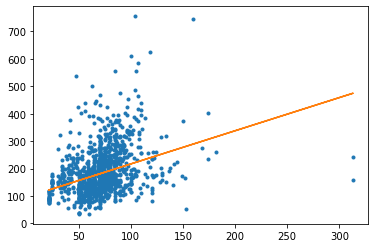

feature  LotArea
--------
p_coef  0.26384335387140495
p_value  1.1231391549198169e-24


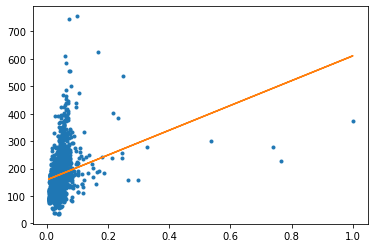

feature  OverallQual
--------
p_coef  0.790981600583805
p_value  2.185675268e-313


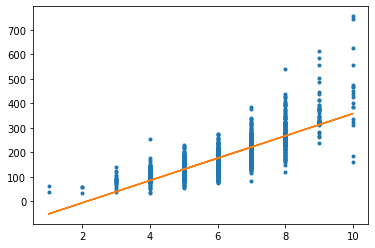

feature  YearBuilt
--------
p_coef  0.5228973328794964
p_value  2.990229099016919e-103


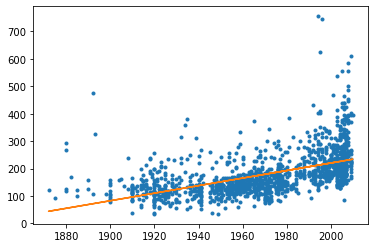

feature  YearRemodAdd
--------
p_coef  0.5071009671113872
p_value  3.1649482419171954e-96


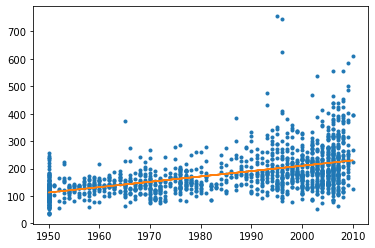

feature  MasVnrArea
--------
p_coef  0.4752413167736671
p_value  3.924711741791994e-83


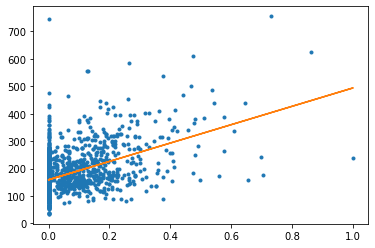

feature  BsmtFinSF1
--------
p_coef  0.3864198062421518
p_value  3.3941098292949995e-53


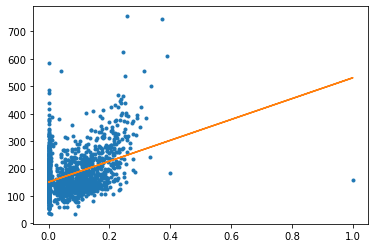

feature  BsmtUnfSF
--------
p_coef  0.21447910554696883
p_value  1.1829757963602225e-16


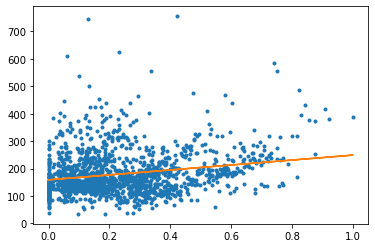

feature  TotalBsmtSF
--------
p_coef  0.6135805515591944
p_value  9.484229391520853e-152


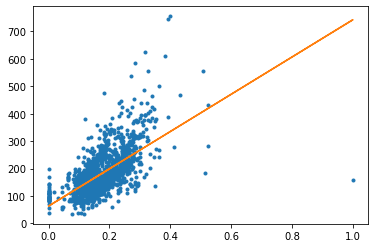

feature  CentralAir
--------
p_coef  0.25132816384015727
p_value  1.8095061559263192e-22


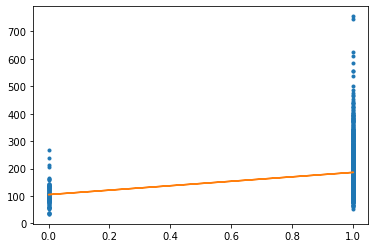

feature  1stFlrSF
--------
p_coef  0.6058521846919155
p_value  5.394710618964537e-147


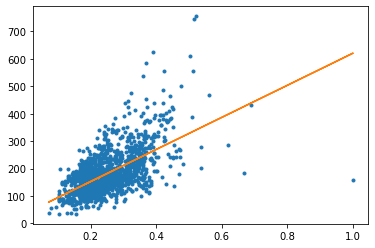

feature  2ndFlrSF
--------
p_coef  0.319333802832067
p_value  5.764335119185027e-36


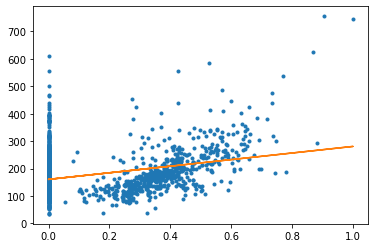

feature  GrLivArea
--------
p_coef  0.7086244776126522
p_value  4.518033646779431e-223


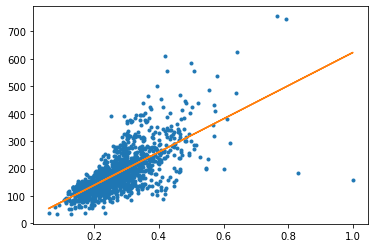

feature  BsmtFullBath
--------
p_coef  0.2271222331314976
p_value  1.5503441372125197e-18


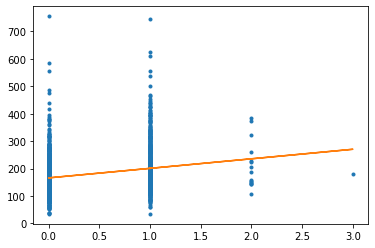

feature  FullBath
--------
p_coef  0.5606637627484461
p_value  1.2364700667602998e-121


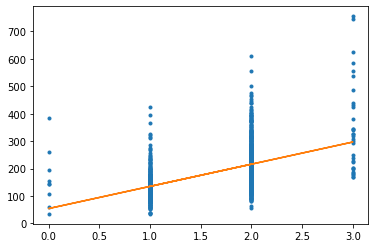

feature  HalfBath
--------
p_coef  0.28410767559477906
p_value  1.6504733955752184e-28


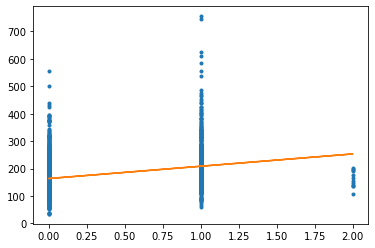

feature  BedroomAbvGr
--------
p_coef  0.16821315430074127
p_value  9.92749732618158e-11


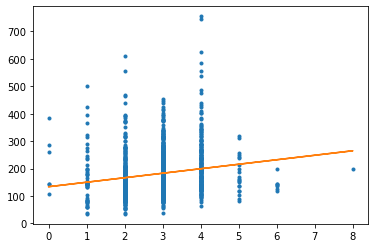

feature  KitchenAbvGr
--------
p_coef  -0.13590737084214188
p_value  1.8604260320762563e-07


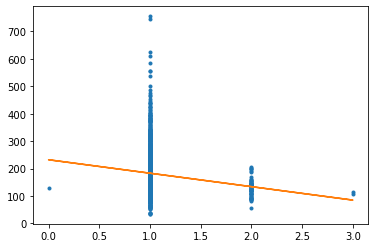

feature  TotRmsAbvGrd
--------
p_coef  0.5337231555820227
p_value  2.772280932975136e-108


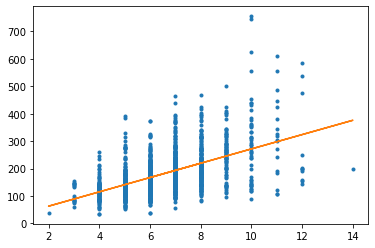

feature  Fireplaces
--------
p_coef  0.4669288367515242
p_value  6.141487461139652e-80


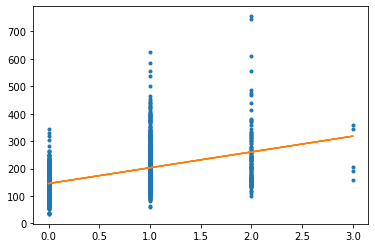

feature  GarageYrBlt
--------
p_coef  0.47017745374048026
p_value  3.550785009570669e-81


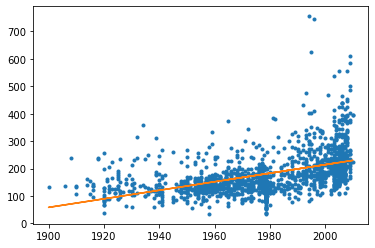

feature  GarageCars
--------
p_coef  0.6404091972583505
p_value  2.4986441671849074e-169


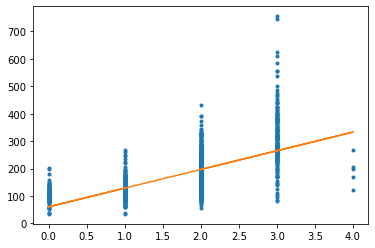

feature  GarageArea
--------
p_coef  0.6234314389183603
p_value  5.265038167990376e-158


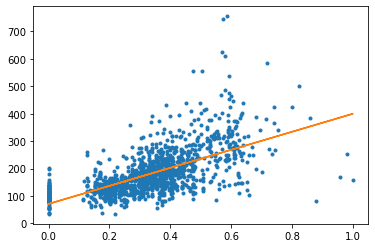

feature  WoodDeckSF
--------
p_coef  0.32441344456813154
p_value  3.972216535625873e-37


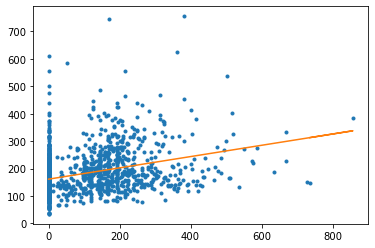

feature  OpenPorchSF
--------
p_coef  0.3158562271160548
p_value  3.4933736230981743e-35


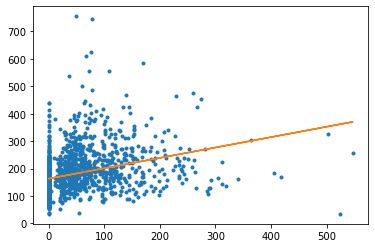

feature  EnclosedPorch
--------
p_coef  -0.12857795792595617
p_value  8.255770475119547e-07


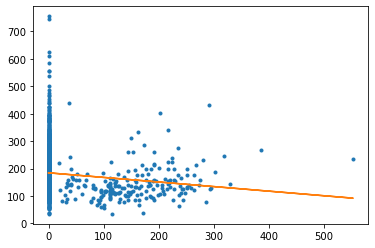

feature  ScreenPorch
--------
p_coef  0.11144657114291048
p_value  1.972140019470455e-05


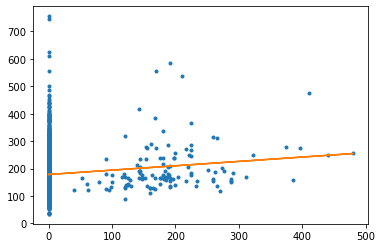

feature  MSZoning_C (all)
--------
p_coef  -0.11125658290808504
p_value  2.0378724002948763e-05


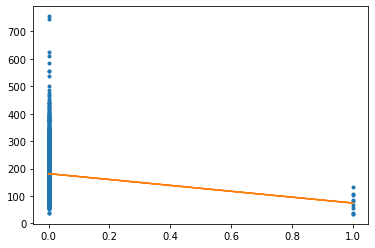

feature  MSZoning_RL
--------
p_coef  0.24506340389709216
p_value  2.077257728424662e-21


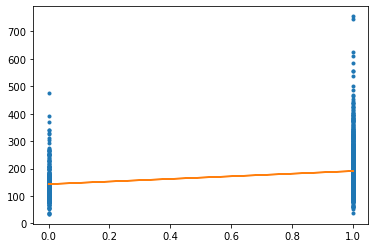

feature  MSZoning_RM
--------
p_coef  -0.2880651218971237
p_value  2.6970981267251774e-29


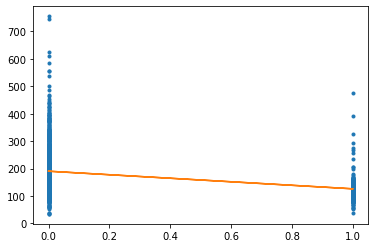

feature  LotShape_IR1
--------
p_coef  0.22328392470489908
p_value  5.9460027738865345e-18


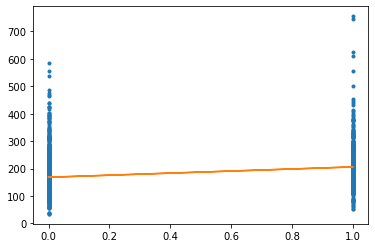

feature  LotShape_IR2
--------
p_coef  0.12609608820325455
p_value  1.3428707345190057e-06


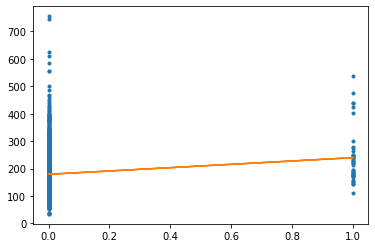

feature  LotShape_Reg
--------
p_coef  -0.2676717602887957
p_value  2.2443743731875487e-25


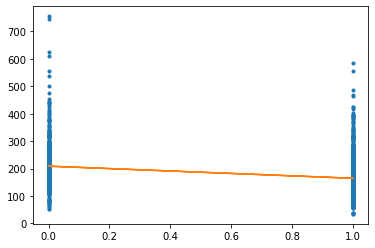

feature  LandContour_HLS
--------
p_coef  0.12001380186770785
p_value  4.2570215060463725e-06


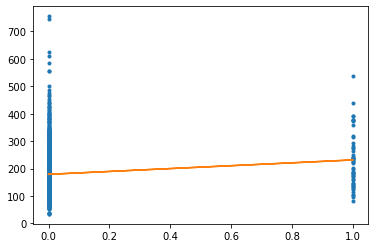

feature  LotConfig_CulDSac
--------
p_coef  0.14181753652525933
p_value  5.27672907572486e-08


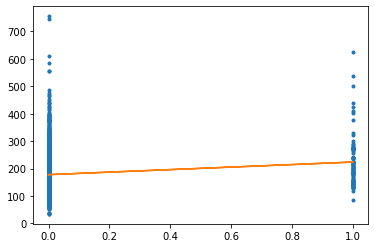

feature  Neighborhood_BrkSide
--------
p_coef  -0.14364786671580496
p_value  3.533923221941283e-08


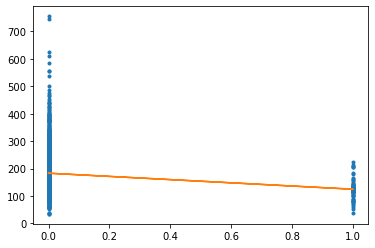

feature  Neighborhood_Edwards
--------
p_coef  -0.17994896448338413
p_value  4.311766347166918e-12


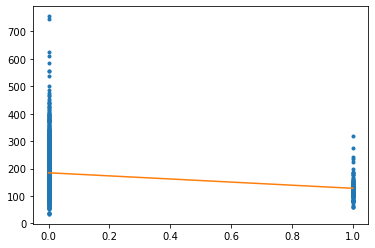

feature  Neighborhood_IDOTRR
--------
p_coef  -0.1640558518909155
p_value  2.8640028533011645e-10


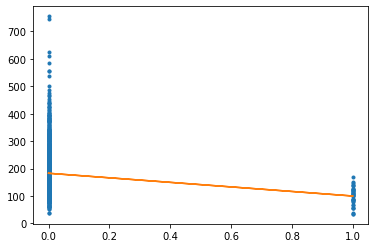

feature  Neighborhood_MeadowV
--------
p_coef  -0.1125441547459997
p_value  1.6301605341877734e-05


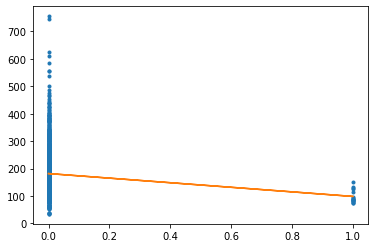

feature  Neighborhood_NAmes
--------
p_coef  -0.18851259699796916
p_value  3.811530316958351e-13


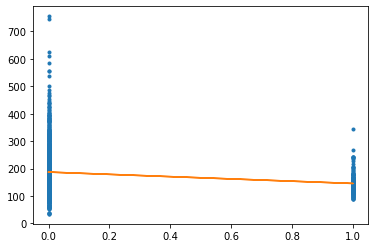

feature  Neighborhood_NoRidge
--------
p_coef  0.3304236257653578
p_value  1.5684929100094902e-38


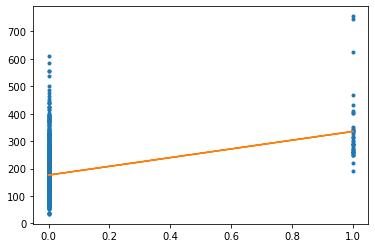

feature  Neighborhood_NridgHt
--------
p_coef  0.4021485981752666
p_value  7.301451183107162e-58


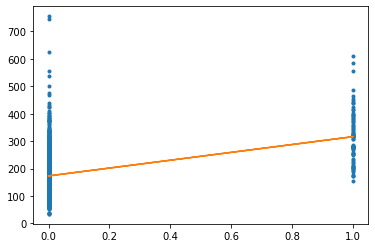

feature  Neighborhood_OldTown
--------
p_coef  -0.19218879886097007
p_value  1.2979245732086467e-13


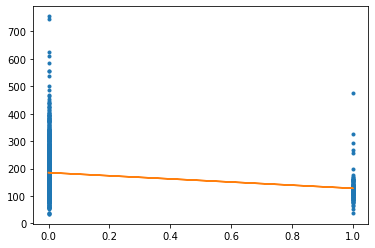

feature  Neighborhood_Sawyer
--------
p_coef  -0.12839406550544274
p_value  8.561462536337024e-07


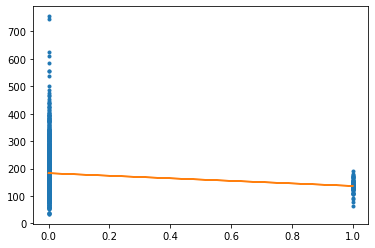

feature  Neighborhood_Somerst
--------
p_coef  0.1400579963436242
p_value  7.720957738402497e-08


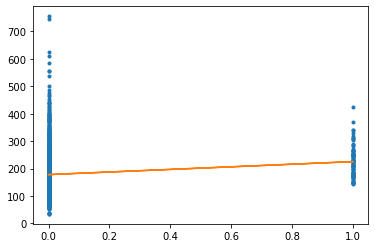

feature  Neighborhood_StoneBr
--------
p_coef  0.2153627227693866
p_value  8.813867236847202e-17


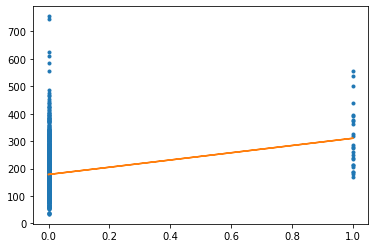

feature  Neighborhood_Timber
--------
p_coef  0.12623630766971225
p_value  1.306782024845222e-06


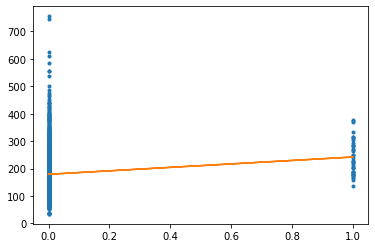

feature  Condition1_Artery
--------
p_coef  -0.1064007109680518
p_value  4.628165653639199e-05


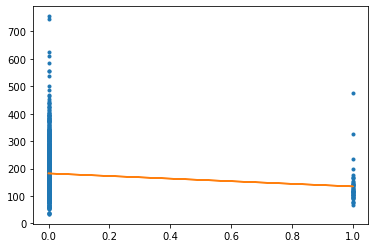

feature  Condition1_Feedr
--------
p_coef  -0.1173286774856823
p_value  6.9630439098165576e-06


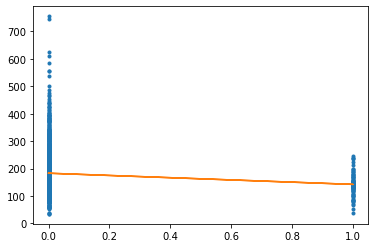

feature  Condition1_Norm
--------
p_coef  0.11296832108736388
p_value  1.5137843886069318e-05


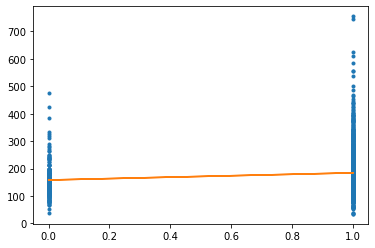

feature  BldgType_1Fam
--------
p_coef  0.13748324869515313
p_value  1.3363539314557269e-07


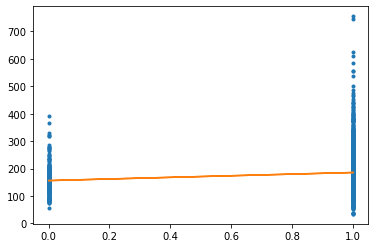

feature  BldgType_Duplex
--------
p_coef  -0.11465483002228388
p_value  1.1247186543396767e-05


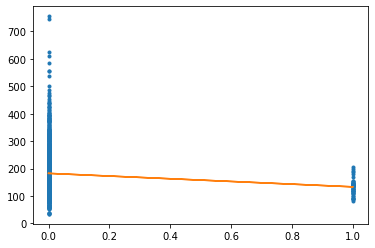

feature  HouseStyle_1.5Fin
--------
p_coef  -0.16346607100995758
p_value  3.3212984253532867e-10


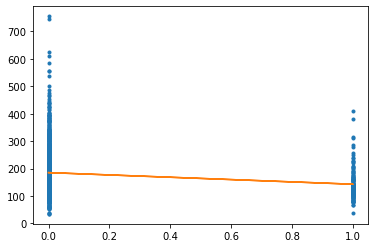

feature  HouseStyle_2Story
--------
p_coef  0.24288002726854013
p_value  4.785582335505818e-21


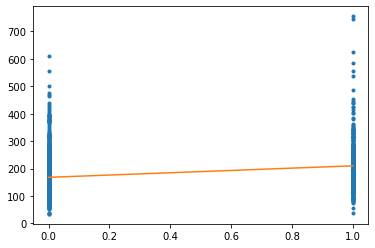

feature  RoofStyle_Gable
--------
p_coef  -0.22474411621309393
p_value  3.5760328081863556e-18


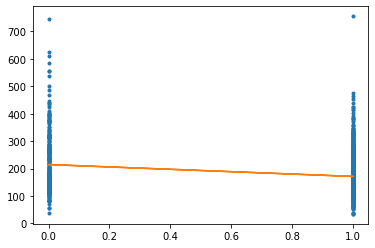

feature  RoofStyle_Hip
--------
p_coef  0.23589691866460114
p_value  6.534124449108714e-20


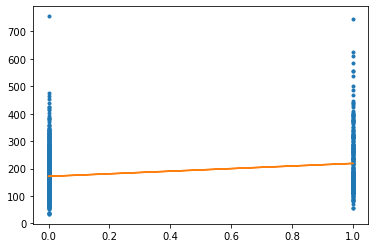

feature  RoofMatl_CompShg
--------
p_coef  -0.10450516998584047
p_value  6.316189362576108e-05


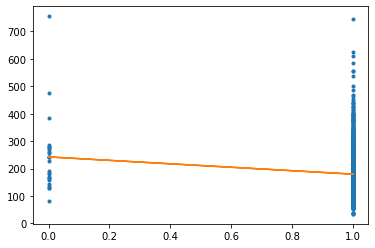

feature  RoofMatl_WdShngl
--------
p_coef  0.16932390580208284
p_value  7.446037898558203e-11


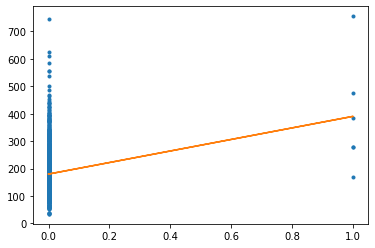

feature  Exterior1st_AsbShng
--------
p_coef  -0.1091258216420073
p_value  2.9330282135738653e-05


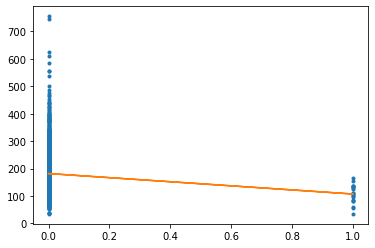

feature  Exterior1st_CemntBd
--------
p_coef  0.13349176235033558
p_value  3.067177836075591e-07


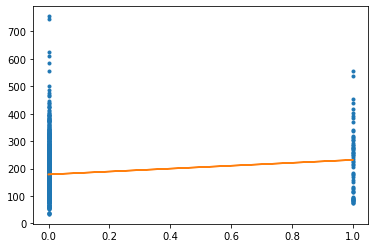

feature  Exterior1st_MetalSd
--------
p_coef  -0.16706804265413472
p_value  1.3327392145260475e-10


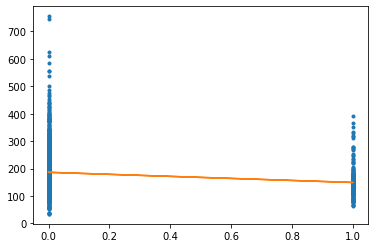

feature  Exterior1st_VinylSd
--------
p_coef  0.3050088024776275
p_value  8.278133715173136e-33


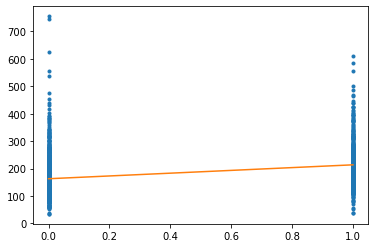

feature  Exterior1st_Wd Sdng
--------
p_coef  -0.1586190816510717
p_value  1.0994777058416348e-09


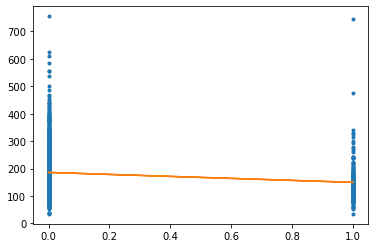

feature  Exterior2nd_CmentBd
--------
p_coef  0.12818316002692498
p_value  8.925468841647316e-07


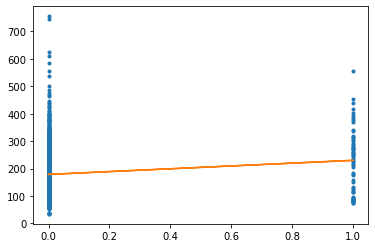

feature  Exterior2nd_MetalSd
--------
p_coef  -0.16238867058442932
p_value  4.3473971456771284e-10


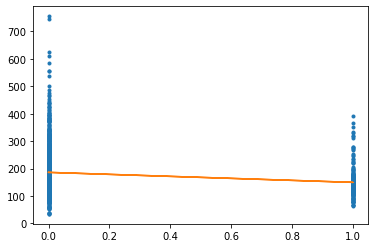

feature  Exterior2nd_VinylSd
--------
p_coef  0.30638888087148436
p_value  4.1813926084977454e-33


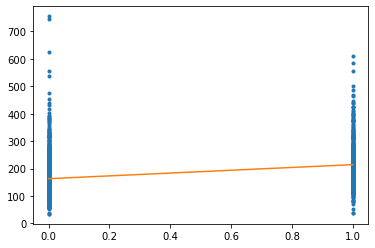

feature  Exterior2nd_Wd Sdng
--------
p_coef  -0.1618004951731796
p_value  5.031880322887711e-10


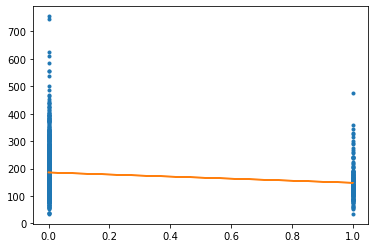

feature  MasVnrType_BrkFace
--------
p_coef  0.19819120620063635
p_value  2.1334385336479874e-14


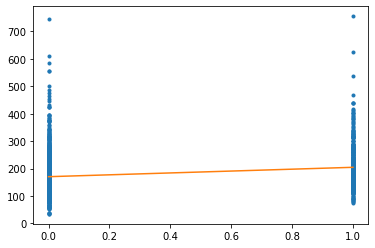

feature  MasVnrType_None
--------
p_coef  -0.3744676734554557
p_value  8.145421031458332e-50


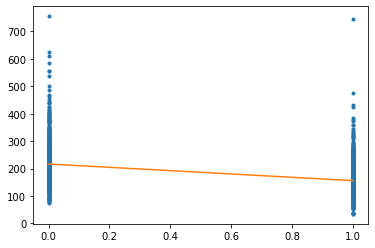

feature  MasVnrType_Stone
--------
p_coef  0.3304756465434074
p_value  1.5247401637353435e-38


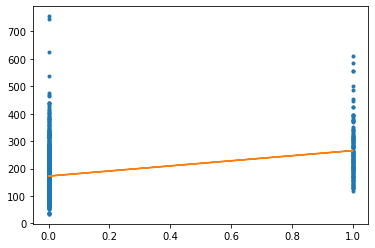

feature  ExterQual_Ex
--------
p_coef  0.451164330222753
p_value  4.067723705115161e-74


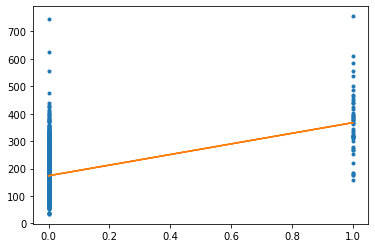

feature  ExterQual_Fa
--------
p_coef  -0.11514885538091939
p_value  1.0301714520733479e-05


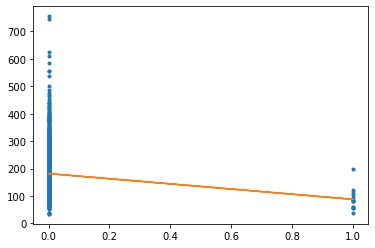

feature  ExterQual_Gd
--------
p_coef  0.45246612784479184
p_value  1.3808580052669518e-74


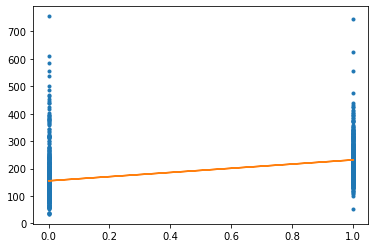

feature  ExterQual_TA
--------
p_coef  -0.5890435234097635
p_value  4.309567397252333e-137


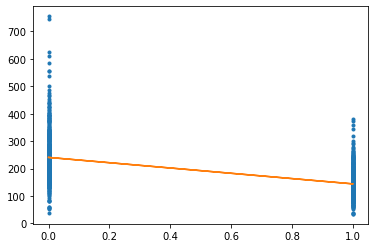

feature  ExterCond_Fa
--------
p_coef  -0.1379143994331372
p_value  1.219907516896575e-07


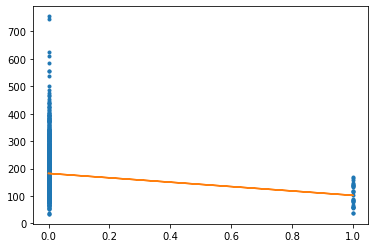

feature  ExterCond_TA
--------
p_coef  0.10522203398149478
p_value  5.618844102270956e-05


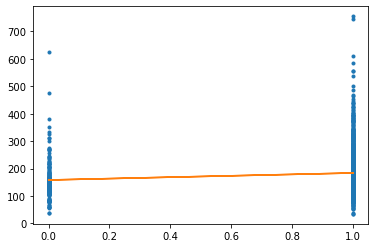

feature  Foundation_BrkTil
--------
p_coef  -0.2041173657826988
p_value  3.3886491752503356e-15


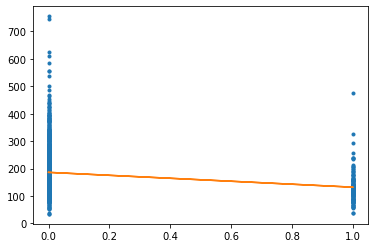

feature  Foundation_CBlock
--------
p_coef  -0.34326299944464994
p_value  1.2301562341803228e-41


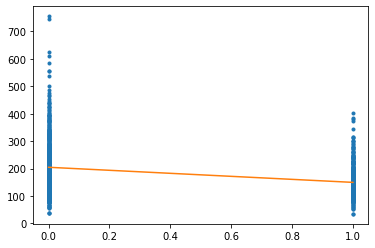

feature  Foundation_PConc
--------
p_coef  0.49773375258694347
p_value  3.1247035109724295e-92


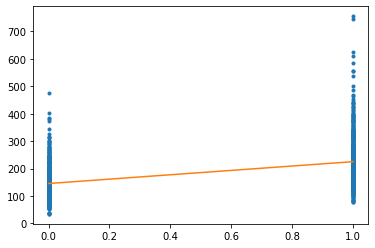

feature  Foundation_Slab
--------
p_coef  -0.11974016023648018
p_value  4.4780961034340505e-06


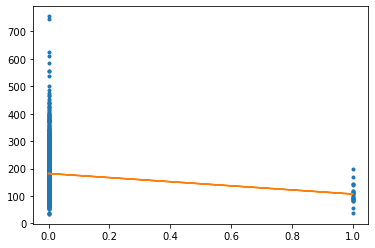

feature  BsmtQual_Ex
--------
p_coef  0.5531048470089426
p_value  9.157709122309411e-118


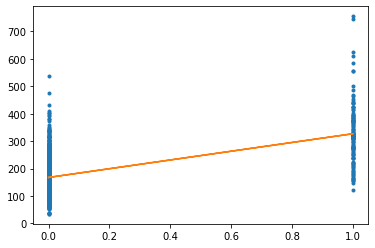

feature  BsmtQual_Fa
--------
p_coef  -0.12872541129366064
p_value  8.018265786606537e-07


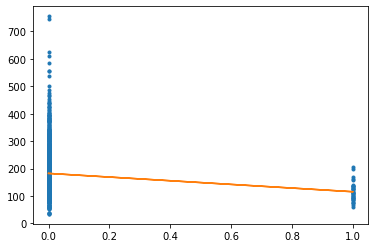

feature  BsmtQual_Gd
--------
p_coef  0.23482172845401858
p_value  9.69967195109226e-20


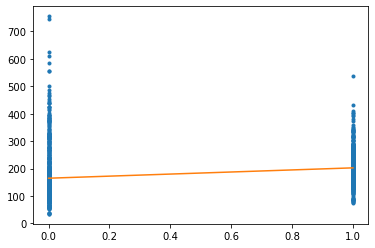

feature  BsmtQual_TA
--------
p_coef  -0.4523935323501031
p_value  1.4667902438137903e-74


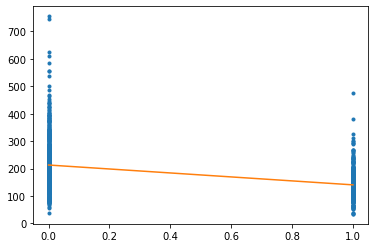

feature  BsmtQual_unknow
--------
p_coef  -0.15282922324994463
p_value  4.381564599226358e-09


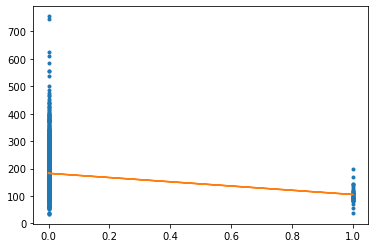

feature  BsmtCond_Fa
--------
p_coef  -0.13273855172329796
p_value  3.578221973637565e-07


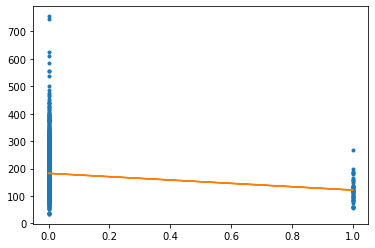

feature  BsmtCond_unknow
--------
p_coef  -0.15282922324994463
p_value  4.381564599226358e-09


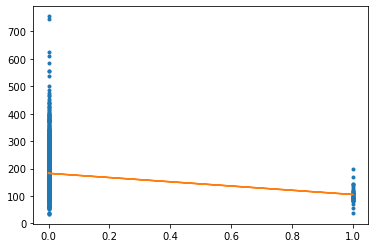

feature  BsmtExposure_Av
--------
p_coef  0.1367933164209502
p_value  1.545359021685937e-07


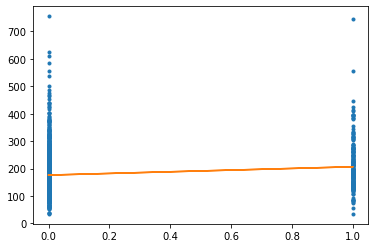

feature  BsmtExposure_Gd
--------
p_coef  0.30729831458669854
p_value  2.66065625179679e-33


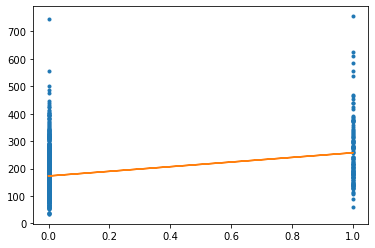

feature  BsmtExposure_No
--------
p_coef  -0.26360041187142064
p_value  1.2428742118654617e-24


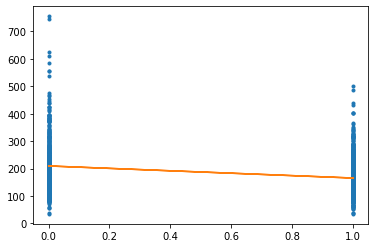

feature  BsmtExposure_unknow
--------
p_coef  -0.1502307048448762
p_value  8.014403944929107e-09


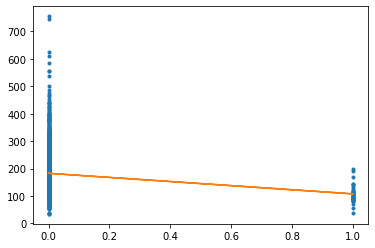

feature  BsmtFinType1_ALQ
--------
p_coef  -0.10262077890522307
p_value  8.560167458684695e-05


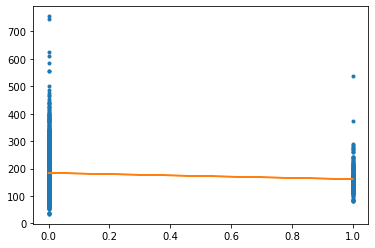

feature  BsmtFinType1_BLQ
--------
p_coef  -0.1329138378257025
p_value  3.4524279272180156e-07


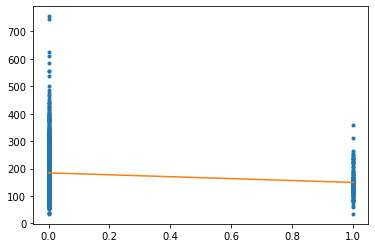

feature  BsmtFinType1_GLQ
--------
p_coef  0.43459734688277724
p_value  2.5449861137815995e-68


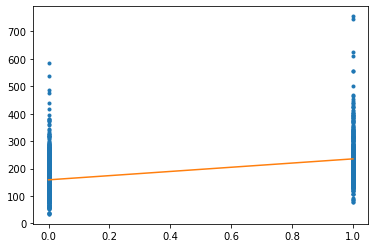

feature  BsmtFinType1_Rec
--------
p_coef  -0.1356666273433359
p_value  1.956237421263163e-07


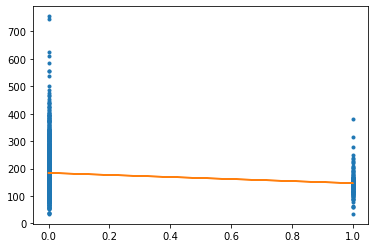

feature  BsmtFinType1_unknow
--------
p_coef  -0.15282922324994463
p_value  4.381564599226358e-09


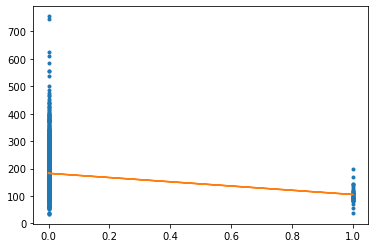

feature  BsmtFinType2_Unf
--------
p_coef  0.11790149415647323
p_value  6.274755969969344e-06


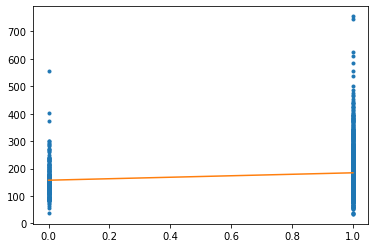

feature  BsmtFinType2_unknow
--------
p_coef  -0.14527420198499913
p_value  2.4643943739310623e-08


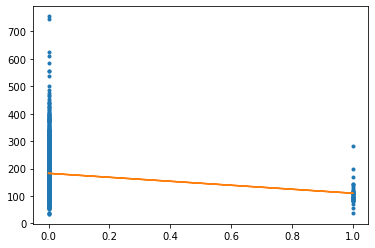

feature  HeatingQC_Ex
--------
p_coef  0.43454323853246696
p_value  2.655183758356968e-68


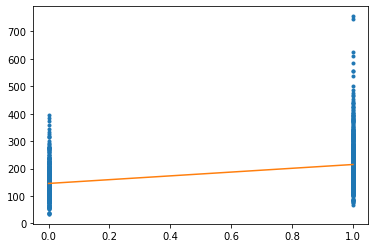

feature  HeatingQC_Fa
--------
p_coef  -0.1337575333426303
p_value  2.90426012339113e-07


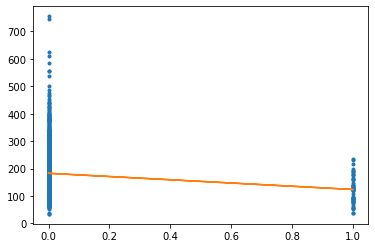

feature  HeatingQC_Gd
--------
p_coef  -0.13472249330663577
p_value  2.380061192327949e-07


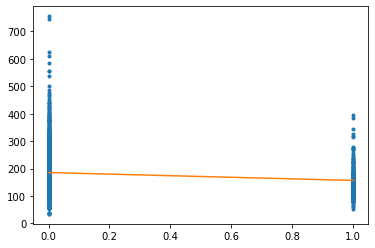

feature  HeatingQC_TA
--------
p_coef  -0.3126770454351807
p_value  1.7764321121507641e-34


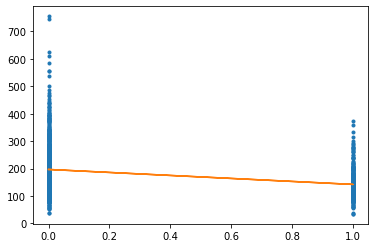

feature  Electrical_FuseA
--------
p_coef  -0.19397792356662547
p_value  7.623441910084123e-14


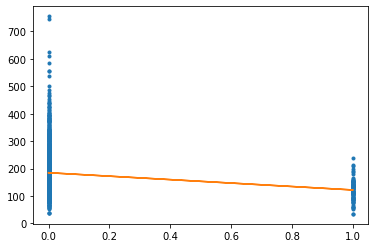

feature  Electrical_FuseF
--------
p_coef  -0.12660098635768127
p_value  1.2172341995053213e-06


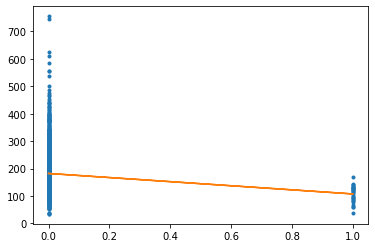

feature  Electrical_SBrkr
--------
p_coef  0.24189604705962817
p_value  6.951959173962046e-21


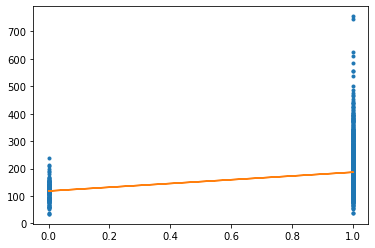

feature  KitchenQual_Ex
--------
p_coef  0.5040936759052951
p_value  6.256631383371697e-95


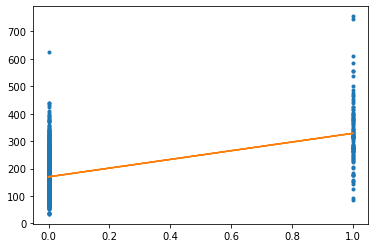

feature  KitchenQual_Fa
--------
p_coef  -0.15719868628269343
p_value  1.5508047884776215e-09


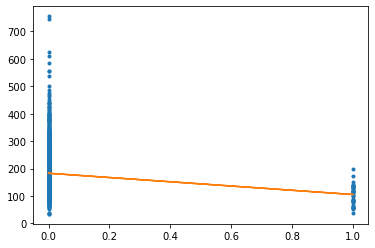

feature  KitchenQual_Gd
--------
p_coef  0.3216411088189493
p_value  1.7212163713049047e-36


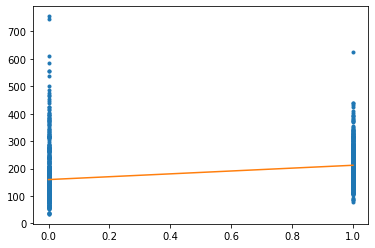

feature  KitchenQual_TA
--------
p_coef  -0.5192978536548851
p_value  1.2856089420578816e-101


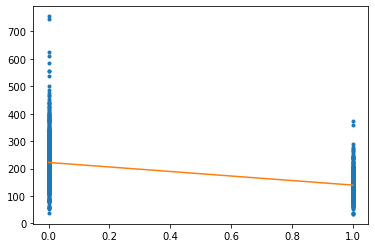

feature  Functional_Typ
--------
p_coef  0.116462040218004
p_value  8.143129270443283e-06


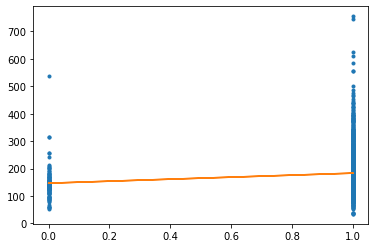

feature  FireplaceQu_Ex
--------
p_coef  0.2552385312288608
p_value  3.8093918083290545e-23


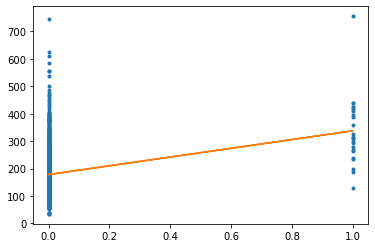

feature  FireplaceQu_Gd
--------
p_coef  0.33932872327044494
p_value  1.1408835171848025e-40


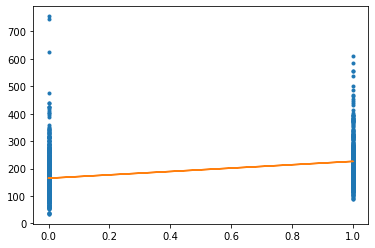

feature  FireplaceQu_TA
--------
p_coef  0.1631466482099496
p_value  3.5979369796718363e-10


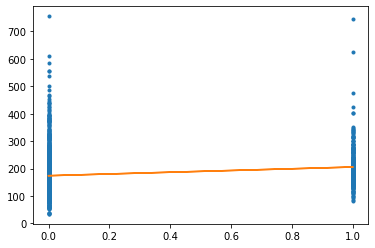

feature  FireplaceQu_unknow
--------
p_coef  -0.4719080685164925
p_value  7.680089360253177e-82


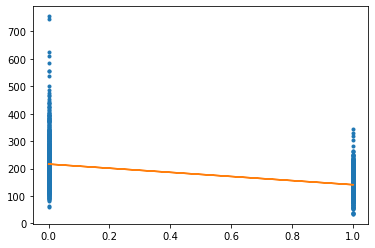

feature  GarageType_Attchd
--------
p_coef  0.33596064720954777
p_value  7.486283069199315e-40


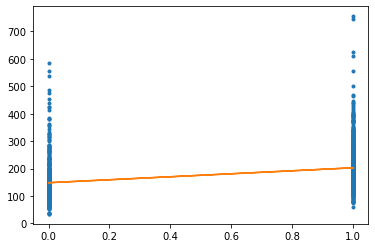

feature  GarageType_BuiltIn
--------
p_coef  0.23544865016730646
p_value  7.705883974693705e-20


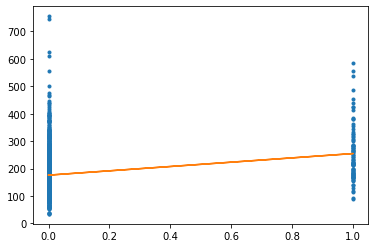

feature  GarageType_Detchd
--------
p_coef  -0.3541407884127017
p_value  2.1987906127518105e-44


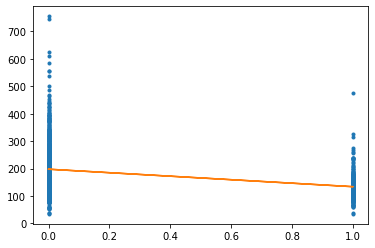

feature  GarageType_unknow
--------
p_coef  -0.23683171182004567
p_value  4.627259402062822e-20


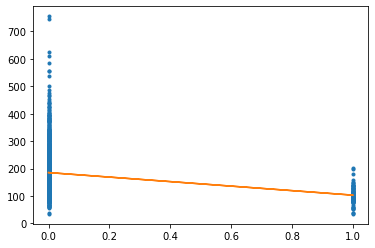

feature  GarageFinish_Fin
--------
p_coef  0.4196779678180175
p_value  2.2742041144979052e-63


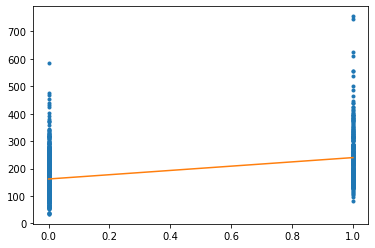

feature  GarageFinish_RFn
--------
p_coef  0.16979152720952193
p_value  6.593059398278521e-11


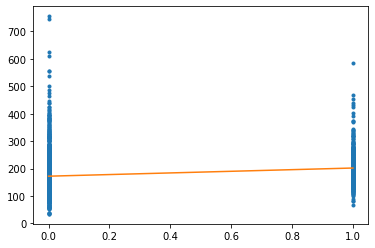

feature  GarageFinish_Unf
--------
p_coef  -0.4106083112916715
p_value  1.765709904533942e-60


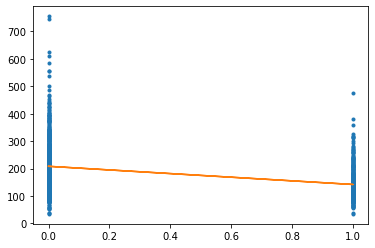

feature  GarageFinish_unknow
--------
p_coef  -0.23683171182004567
p_value  4.627259402062822e-20


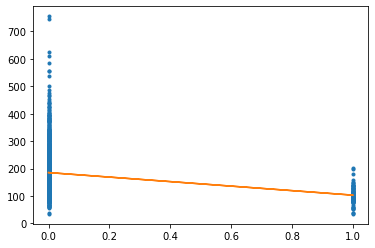

feature  GarageQual_Fa
--------
p_coef  -0.1331423480721318
p_value  3.2948275580047456e-07


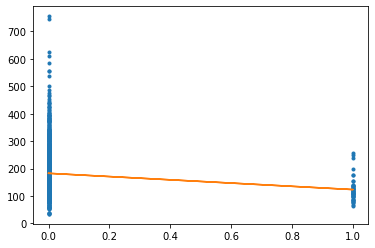

feature  GarageQual_TA
--------
p_coef  0.24534631715662966
p_value  1.863218777974911e-21


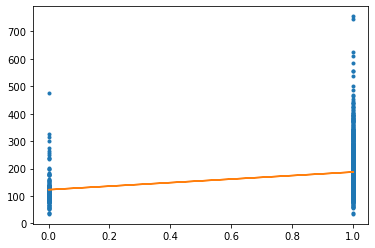

feature  GarageQual_unknow
--------
p_coef  -0.23683171182004567
p_value  4.627259402062822e-20


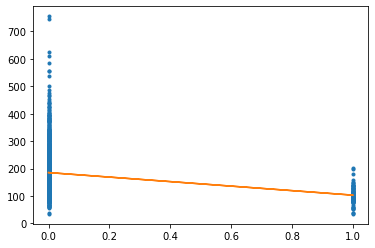

feature  GarageCond_Fa
--------
p_coef  -0.13077383506503001
p_value  5.327445783978943e-07


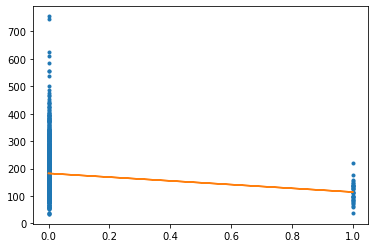

feature  GarageCond_TA
--------
p_coef  0.27587200180506544
p_value  6.523849679026881e-27


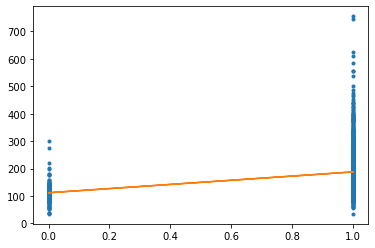

feature  GarageCond_unknow
--------
p_coef  -0.23683171182004567
p_value  4.627259402062822e-20


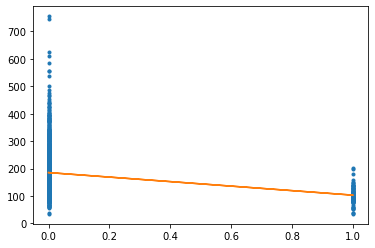

feature  PavedDrive_N
--------
p_coef  -0.21262978253141193
p_value  2.18098097425581e-16


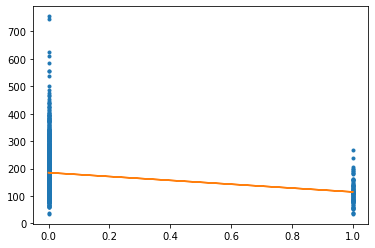

feature  PavedDrive_Y
--------
p_coef  0.23196803451041814
p_value  2.7414143021031745e-19


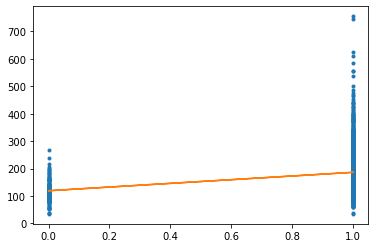

feature  SaleType_New
--------
p_coef  0.35750940508319645
p_value  2.9451467216496274e-45


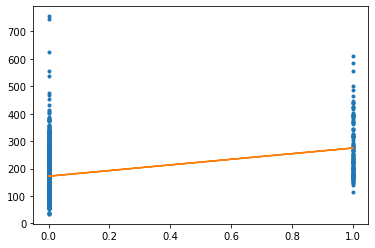

feature  SaleType_WD
--------
p_coef  -0.24259751727294787
p_value  5.3280749505374384e-21


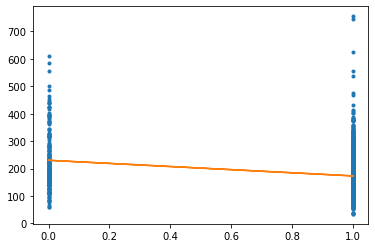

feature  SaleCondition_Abnorml
--------
p_coef  -0.11806923061460149
p_value  6.085845075189089e-06


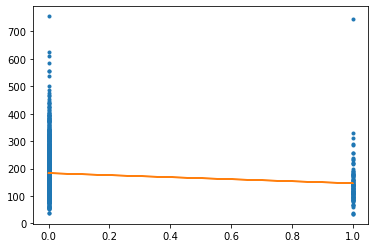

feature  SaleCondition_Normal
--------
p_coef  -0.15398979048536718
p_value  3.3347146907429616e-09


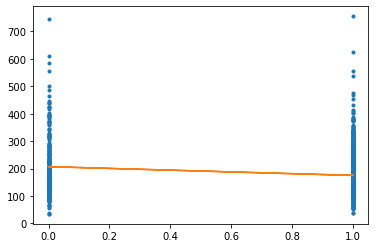

feature  SaleCondition_Partial
--------
p_coef  0.3520598546714335
p_value  7.520572440332955e-44


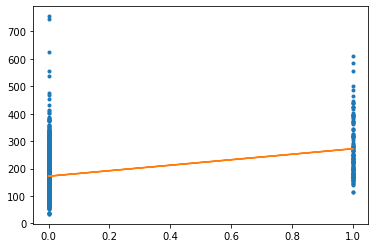




FOR FEATURES WICH HAVE MODERATE RELATIONSHIP
--------------------------------------------
feature  MSSubClass
--------
p_coef  -0.08428413512659519
p_value  0.0012664716847503312


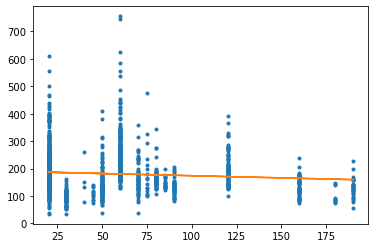

feature  OverallCond
--------
p_coef  -0.07785589404867768
p_value  0.0029123512679174956


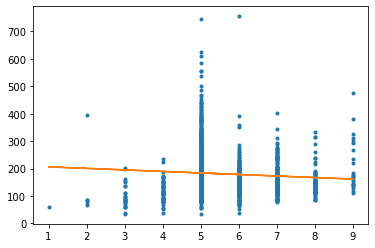

feature  PoolArea
--------
p_coef  0.09240354949187271
p_value  0.00040734896011991486


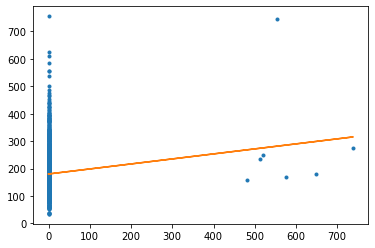

feature  MSZoning_FV
--------
p_coef  0.08994971967036146
p_value  0.0005795528105649701


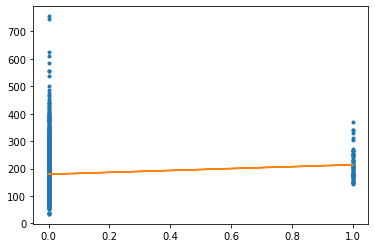

feature  MSZoning_RH
--------
p_coef  -0.06542929310102562
p_value  0.012398724317115816


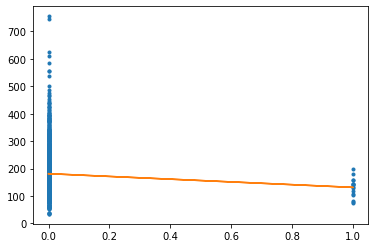

feature  LandContour_Bnk
--------
p_coef  -0.10112449060458731
p_value  0.00010857787443476418


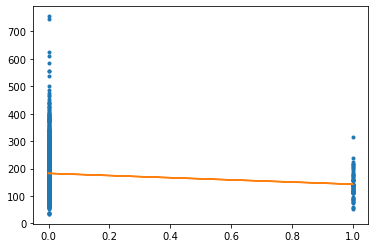

feature  LotConfig_Inside
--------
p_coef  -0.08053786914590598
p_value  0.0020719827477794707


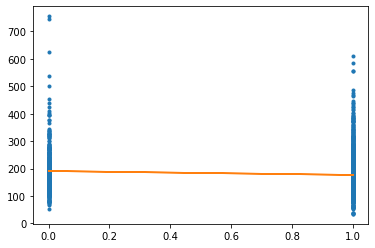

feature  Neighborhood_BrDale
--------
p_coef  -0.10130283618167185
p_value  0.00010556180644894824


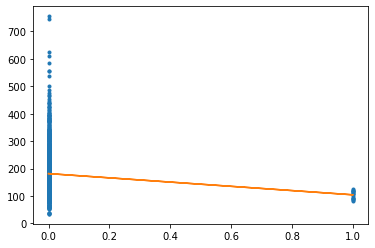

feature  Neighborhood_ClearCr
--------
p_coef  0.05571831053291223
p_value  0.03326882351563423


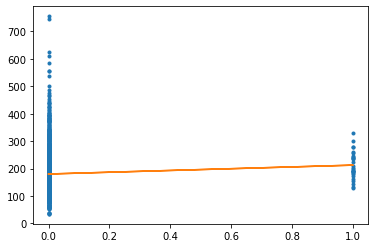

feature  Neighborhood_CollgCr
--------
p_coef  0.07262599312707721
p_value  0.005497717302635493


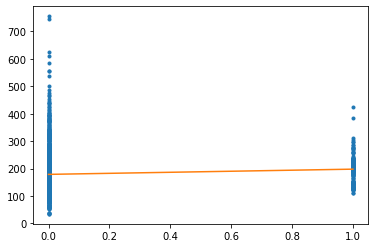

feature  Neighborhood_Crawfor
--------
p_coef  0.07115960252664774
p_value  0.006525733632307605


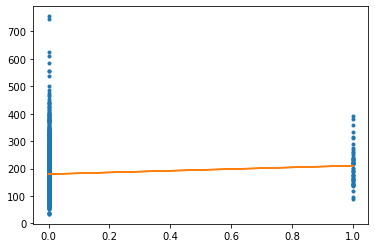

feature  Neighborhood_Mitchel
--------
p_coef  -0.05784505418676325
p_value  0.02709030591378706


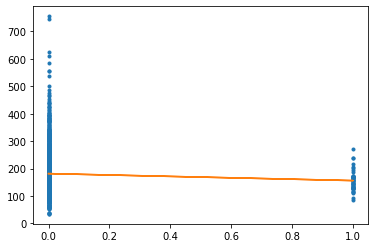

feature  Neighborhood_SWISU
--------
p_coef  -0.06370549244437909
p_value  0.014909423718894825


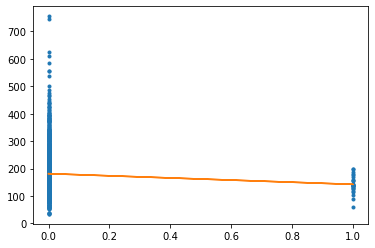

feature  Neighborhood_Veenker
--------
p_coef  0.06347063934055339
p_value  0.015284013379885926


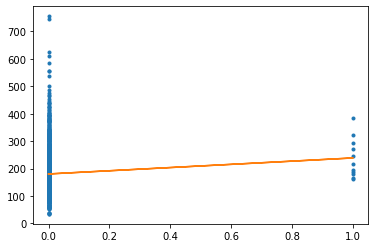

feature  BldgType_2fmCon
--------
p_coef  -0.09734830194128336
p_value  0.00019505331251014937


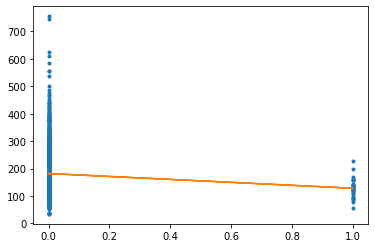

feature  BldgType_Twnhs
--------
p_coef  -0.09873019861048941
p_value  0.00015778907407974524


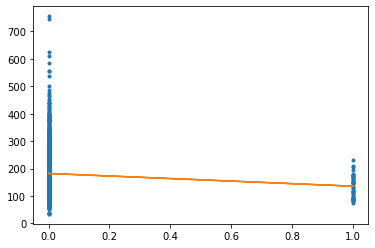

feature  HouseStyle_1.5Unf
--------
p_coef  -0.08768640584636372
p_value  0.0007962779476539839


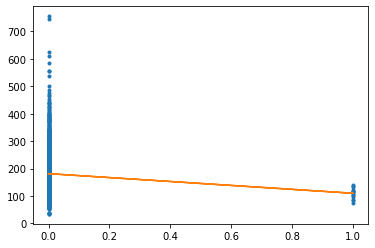

feature  HouseStyle_1Story
--------
p_coef  -0.06181110053588833
p_value  0.01817494075612611


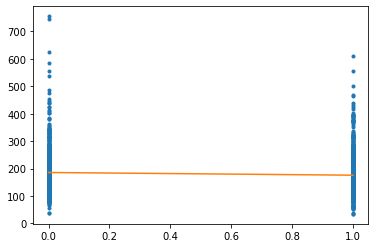

feature  HouseStyle_SFoyer
--------
p_coef  -0.0930898746822511
p_value  0.0003685333163872232


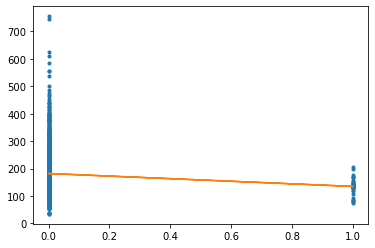

feature  Exterior1st_HdBoard
--------
p_coef  -0.09514764583955283
p_value  0.0002718609965495623


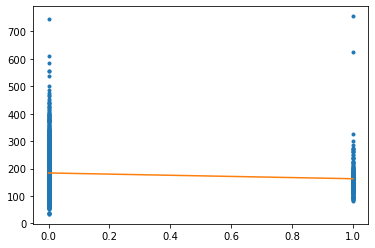

feature  Exterior1st_WdShing
--------
p_coef  -0.05131740614312045
p_value  0.04994349210066954


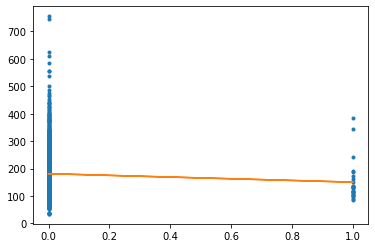

feature  Exterior2nd_AsbShng
--------
p_coef  -0.09922021939101264
p_value  0.00014626570741458776


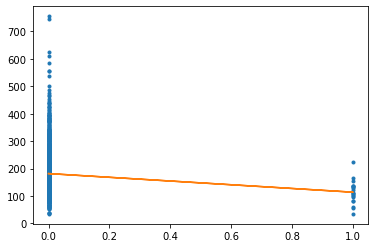

feature  Exterior2nd_HdBoard
--------
p_coef  -0.06786360534380856
p_value  0.009491218916545802


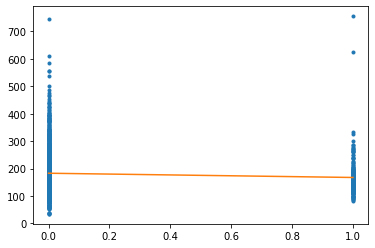

feature  Exterior2nd_ImStucc
--------
p_coef  0.07440111895297474
p_value  0.004449924009678522


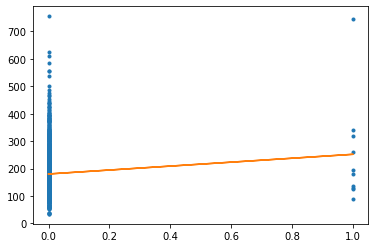

feature  Exterior2nd_Plywood
--------
p_coef  -0.052940868975969856
p_value  0.043119193652604915


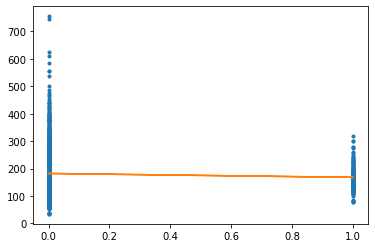

feature  MasVnrType_unknow
--------
p_coef  0.05193302955427022
p_value  0.047256115632923174


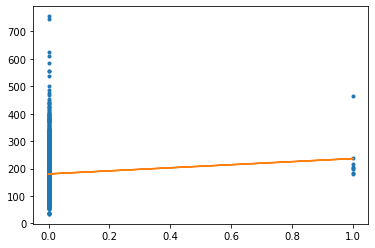

feature  BsmtCond_Gd
--------
p_coef  0.08882400808170247
p_value  0.0006793716983122161


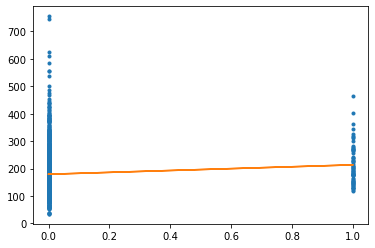

feature  BsmtCond_Po
--------
p_coef  -0.0545287256366241
p_value  0.037223415356518616


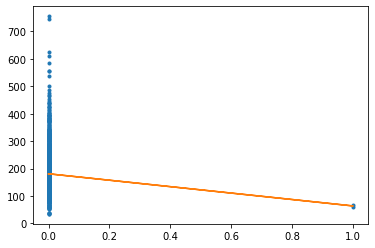

feature  BsmtCond_TA
--------
p_coef  0.10127486495836965
p_value  0.00010602955770174107


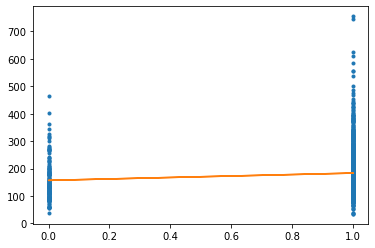

feature  BsmtFinType1_LwQ
--------
p_coef  -0.08457706852755623
p_value  0.0012176443771339048


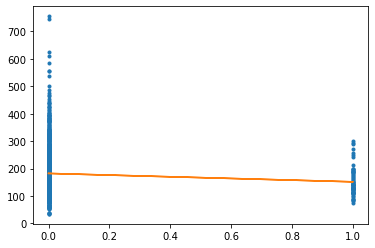

feature  BsmtFinType1_Unf
--------
p_coef  -0.08339914089154482
p_value  0.0014251667387035433


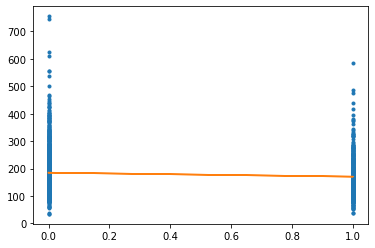

feature  BsmtFinType2_BLQ
--------
p_coef  -0.057102002531656086
p_value  0.029126070587884474


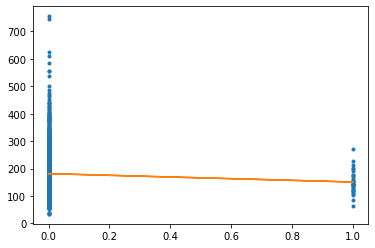

feature  Heating_GasA
--------
p_coef  0.09252891316304189
p_value  0.00039998562653741315


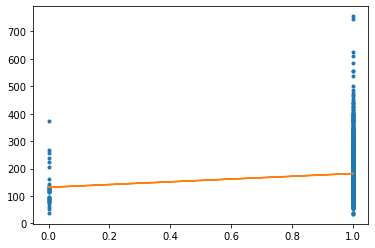

feature  Heating_Grav
--------
p_coef  -0.09233803351104615
p_value  0.00041124723083922556


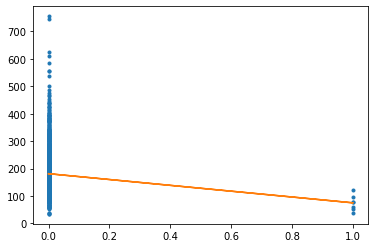

feature  Heating_Wall
--------
p_coef  -0.058622156149097944
p_value  0.025093688709243063


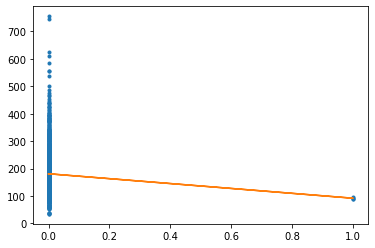

feature  Functional_Maj2
--------
p_coef  -0.07021447788221274
p_value  0.007276746373368094


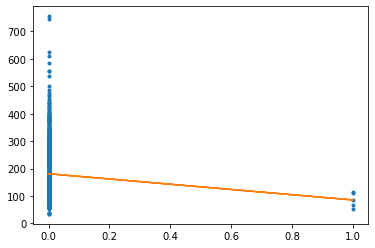

feature  Functional_Min1
--------
p_coef  -0.06405145656743245
p_value  0.014372332930391564


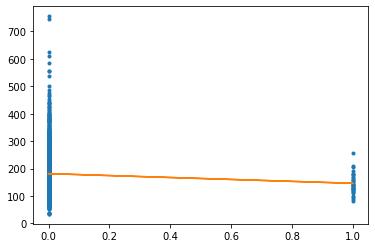

feature  Functional_Min2
--------
p_coef  -0.07132000820499279
p_value  0.006405423057908905


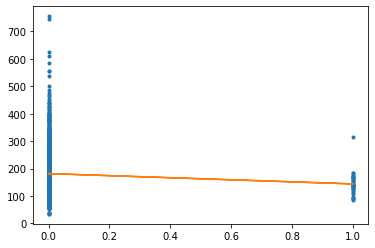

feature  FireplaceQu_Po
--------
p_coef  -0.07591630695524935
p_value  0.0037024120867202442


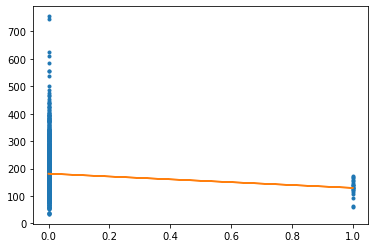

feature  GarageType_CarPort
--------
p_coef  -0.07037062648692732
p_value  0.007147558237279599


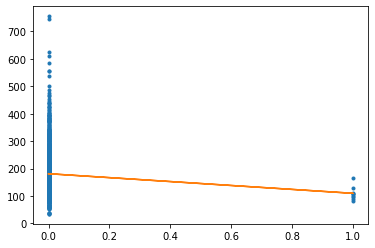

feature  GarageCond_Po
--------
p_coef  -0.06329621903329452
p_value  0.015567544996814226


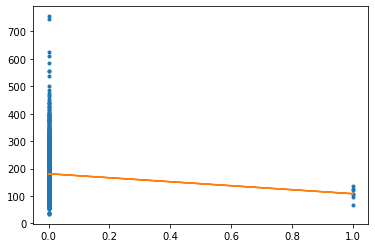

feature  PavedDrive_P
--------
p_coef  -0.08862292093317171
p_value  0.0006988018924944264


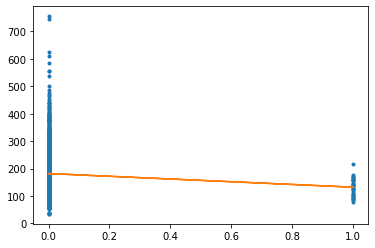

feature  SaleType_COD
--------
p_coef  -0.08104671129791154
p_value  0.0019401938941831709


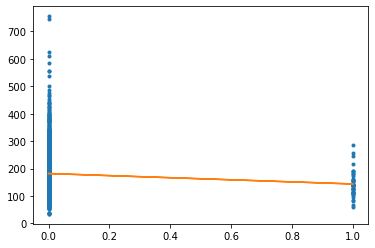




FOR FEATURES WICH HAVE WEAK RELATIONSHIP
----------------------------------------
feature  3SsnPorch
--------
p_coef  0.04458366533574793
p_value  0.0885817035806393


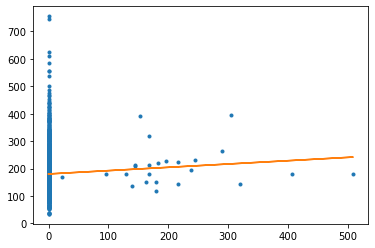

feature  MoSold
--------
p_coef  0.04643224522381911
p_value  0.07612757850609982


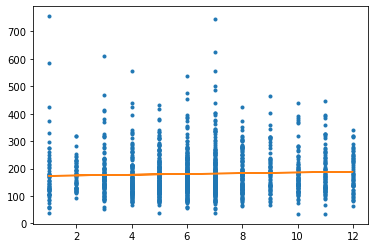

feature  LandContour_Low
--------
p_coef  0.0455282503274953
p_value  0.0820270618317536


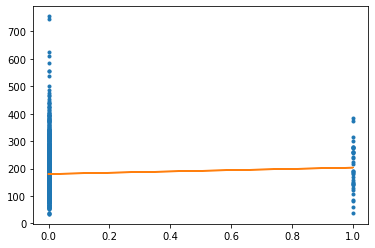

feature  LandSlope_Gtl
--------
p_coef  -0.05111614933705161
p_value  0.050849336921446046


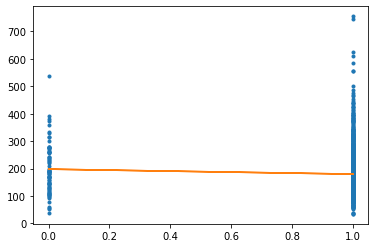

feature  Condition1_PosN
--------
p_coef  0.04954116844794426
p_value  0.05842357283670482


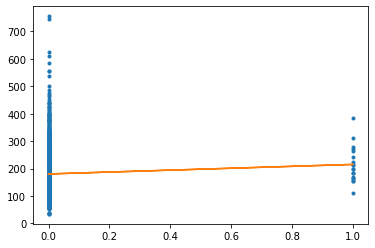

feature  Condition1_RRAe
--------
p_coef  -0.04665127135276236
p_value  0.07475150687375447


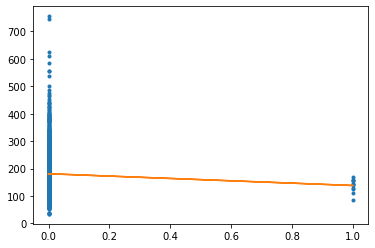

feature  Condition2_Feedr
--------
p_coef  -0.04833482100357337
p_value  0.06483875211290928


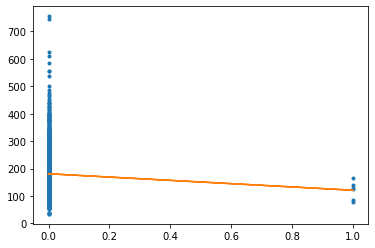

feature  Condition2_PosA
--------
p_coef  0.047497233281444444
p_value  0.06962596446236528


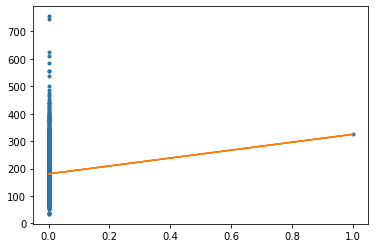

feature  Condition2_PosN
--------
p_coef  0.04848110233569749
p_value  0.06403117724556227


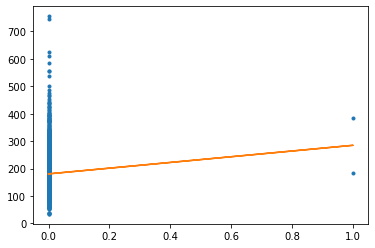

feature  RoofMatl_WdShake
--------
p_coef  0.0446429170044055
p_value  0.08815851140782816


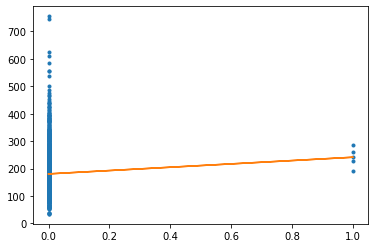

feature  Exterior1st_BrkComm
--------
p_coef  -0.05126412441056306
p_value  0.05018198450300821


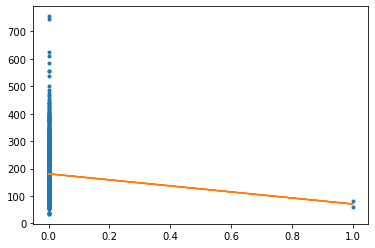

feature  Exterior2nd_Brk Cmn
--------
p_coef  -0.04737690972154201
p_value  0.0703369039871522


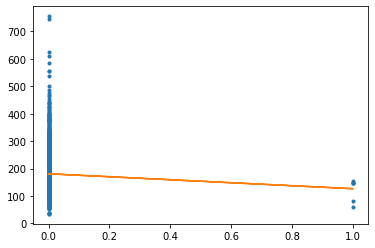

feature  Exterior2nd_Other
--------
p_coef  0.04551926433972624
p_value  0.08208751278245542


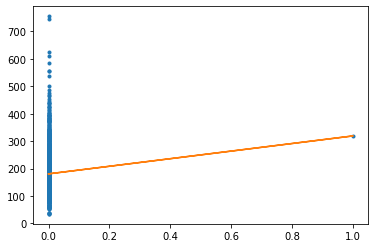

feature  MasVnrType_BrkCmn
--------
p_coef  -0.044393863680548054
p_value  0.0899483421655357


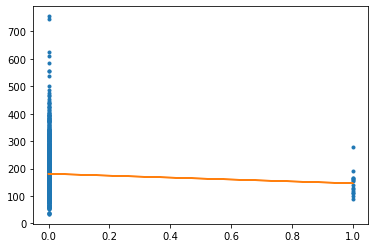

feature  ExterCond_Gd
--------
p_coef  -0.05046730552645428
p_value  0.053863837749816686


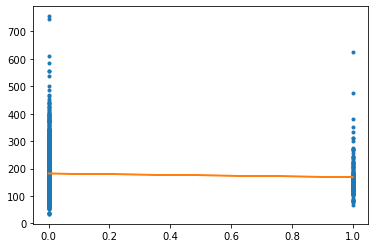

feature  BsmtExposure_Mn
--------
p_coef  0.043493083940889056
p_value  0.09666704058114148


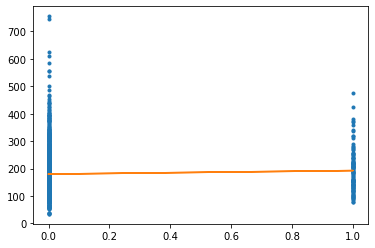

feature  Electrical_FuseP
--------
p_coef  -0.04776061769494804
p_value  0.06809030167682434


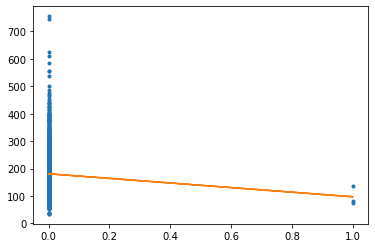

feature  GarageQual_Gd
--------
p_coef  0.043290504724990984
p_value  0.09823194140380462


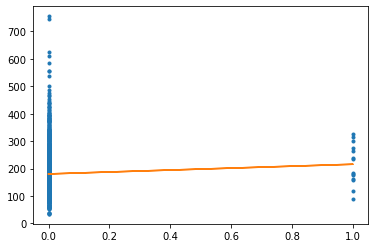

feature  GarageQual_Po
--------
p_coef  -0.046141701431318426
p_value  0.07798475263051959


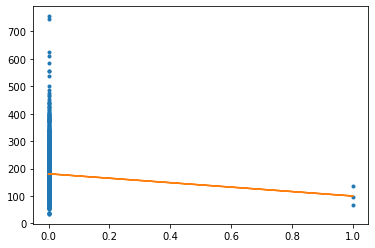

feature  SaleCondition_AdjLand
--------
p_coef  -0.05068563355867175
p_value  0.05283327582639817


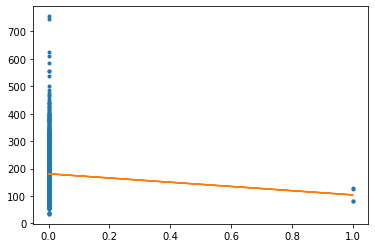

feature  SaleCondition_Family
--------
p_coef  -0.04648019603234434
p_value  0.07582456712071753


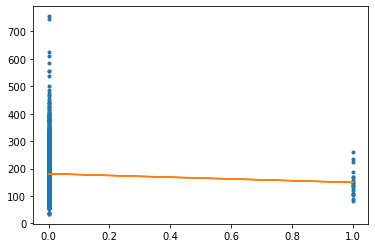




FOR FEATURES WICH HAVE NO RELATIONSHIP
------------------------------------------
feature  BsmtFinSF2
--------
p_coef  -0.011378121450215257
p_value  0.6639986508345731


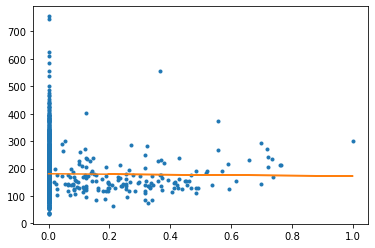

feature  LowQualFinSF
--------
p_coef  -0.025606130000680148
p_value  0.32820730984074636


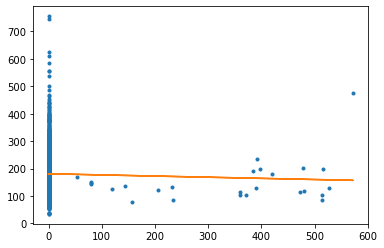

feature  BsmtHalfBath
--------
p_coef  -0.016844154297359294
p_value  0.5201536357280284


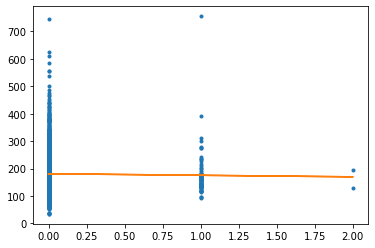

feature  MiscVal
--------
p_coef  -0.021189579640302676
p_value  0.4184863494082921


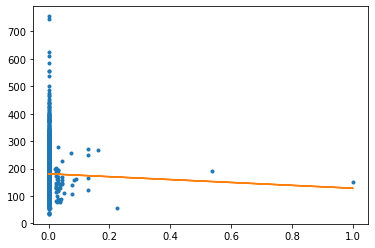

feature  YrSold
--------
p_coef  -0.028922585168730468
p_value  0.2694131932810079


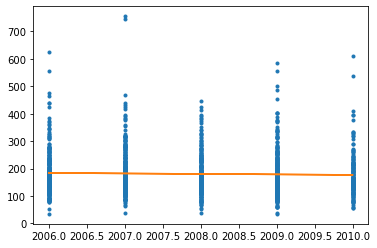

feature  Street_Grvl
--------
p_coef  -0.041035535500049826
p_value  0.11704860406788917


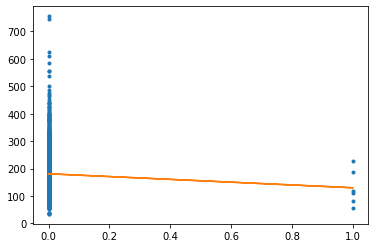

feature  Street_Pave
--------
p_coef  0.04103553550004979
p_value  0.11704860406788917


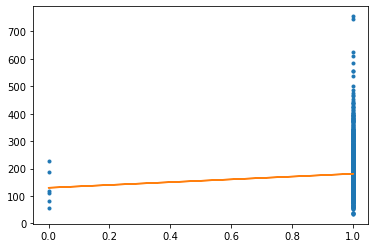

feature  LotShape_IR3
--------
p_coef  0.03672047549953544
p_value  0.16080819023494392


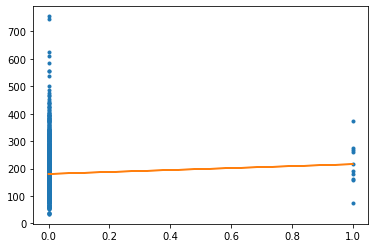

feature  LandContour_Lvl
--------
p_coef  -0.027544579330839154
p_value  0.2929027906400112


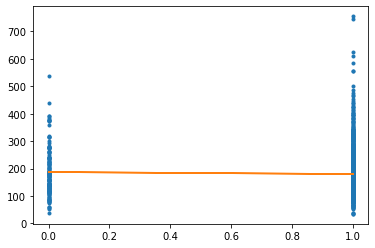

feature  Utilities_AllPub
--------
p_coef  0.014314296147248983
p_value  0.5847167739693384


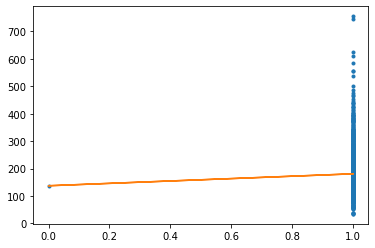

feature  Utilities_NoSeWa
--------
p_coef  -0.01431429614724896
p_value  0.5847167739693384


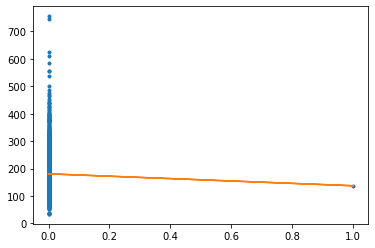

feature  LotConfig_Corner
--------
p_coef  0.004144823294072536
p_value  0.8742688608482646


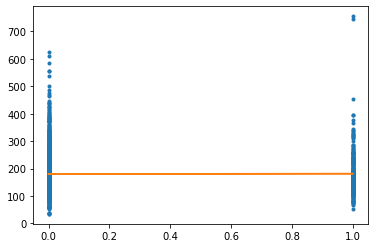

feature  LotConfig_FR2
--------
p_coef  -0.0068588907827759685
p_value  0.7934321095421256


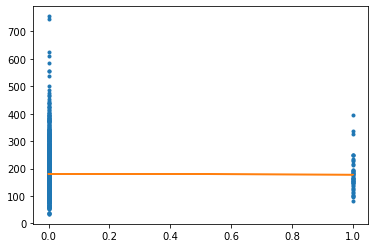

feature  LotConfig_FR3
--------
p_coef  0.01818556247550324
p_value  0.4874742625908078


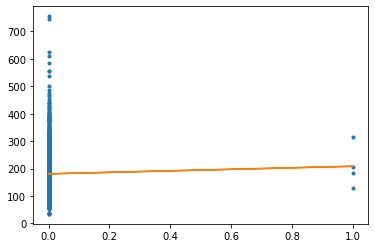

feature  LandSlope_Mod
--------
p_coef  0.0429811599443708
p_value  0.10066052286147514


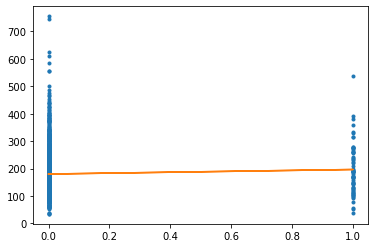

feature  LandSlope_Sev
--------
p_coef  0.027997864142057172
p_value  0.2850290390956411


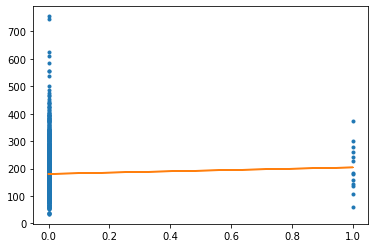

feature  Neighborhood_Blmngtn
--------
p_coef  0.01906564951350561
p_value  0.4666505315213776


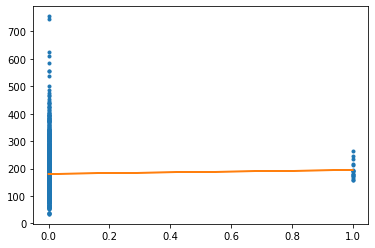

feature  Neighborhood_Blueste
--------
p_coef  -0.020250412762982294
p_value  0.43941365190358345


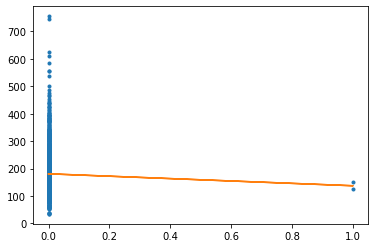

feature  Neighborhood_Gilbert
--------
p_coef  0.035939622294683976
p_value  0.1699021629027166


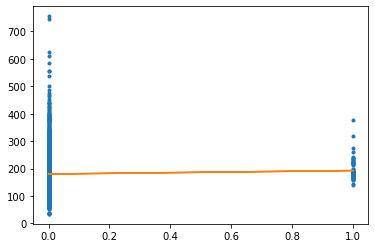

feature  Neighborhood_NPkVill
--------
p_coef  -0.037909739904050374
p_value  0.14767050663638642


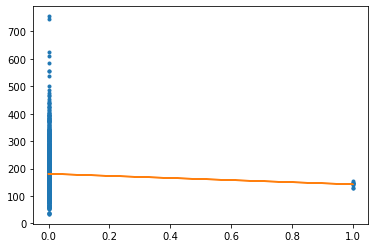

feature  Neighborhood_NWAmes
--------
p_coef  0.023482773020255376
p_value  0.3699160556703009


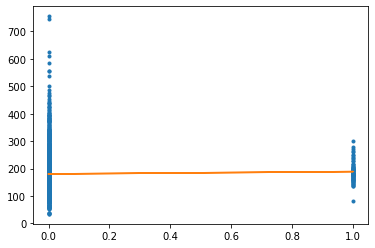

feature  Neighborhood_SawyerW
--------
p_coef  0.014560153318488825
p_value  0.578282202853921


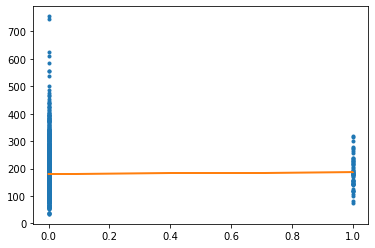

feature  Condition1_PosA
--------
p_coef  0.04201689908541698
p_value  0.1085384714146798


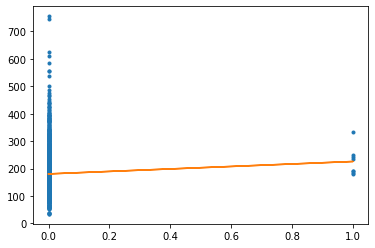

feature  Condition1_RRAn
--------
p_coef  0.0058927117115444355
p_value  0.8220031561219263


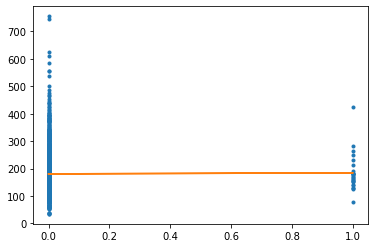

feature  Condition1_RRNe
--------
p_coef  0.004583875135268435
p_value  0.8610792199985275


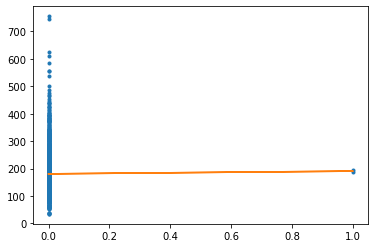

feature  Condition1_RRNn
--------
p_coef  0.023236333124508738
p_value  0.37496134236656536


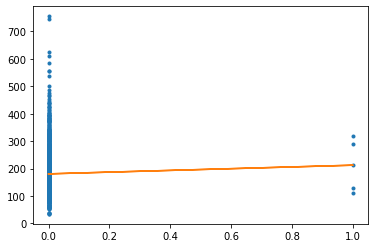

feature  Condition2_Artery
--------
p_coef  -0.03470793247839585
p_value  0.18502138193293802


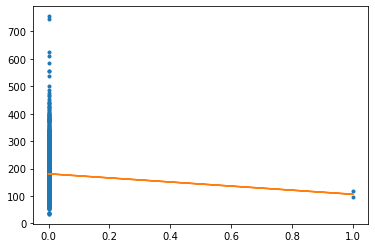

feature  Condition2_Norm
--------
p_coef  0.030676288435637723
p_value  0.24143358397110426


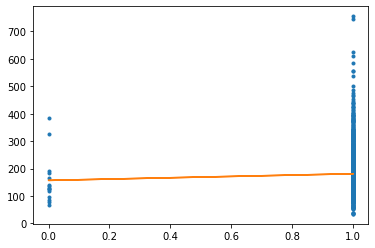

feature  Condition2_RRAe
--------
p_coef  0.002992932092785054
p_value  0.9090300403771862


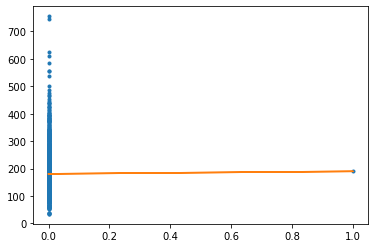

feature  Condition2_RRAn
--------
p_coef  -0.014510444733969327
p_value  0.5795804895999397


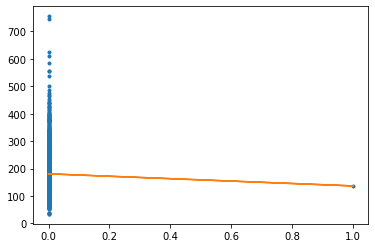

feature  Condition2_RRNn
--------
p_coef  -0.039255055614695236
p_value  0.13381482342701378


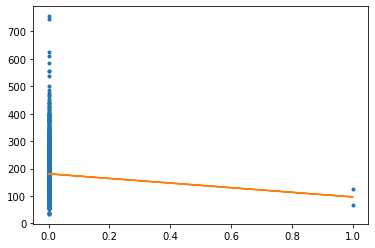

feature  BldgType_TwnhsE
--------
p_coef  0.003804383453308919
p_value  0.8845203529666813


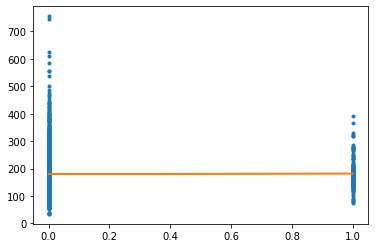

feature  HouseStyle_2.5Fin
--------
p_coef  0.036525722375987384
p_value  0.1630411788363029


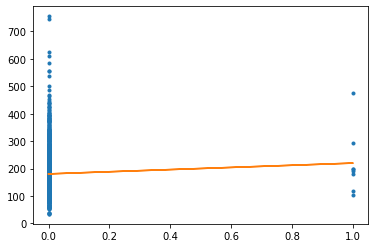

feature  HouseStyle_2.5Unf
--------
p_coef  -0.025855674595624423
p_value  0.32351381970721493


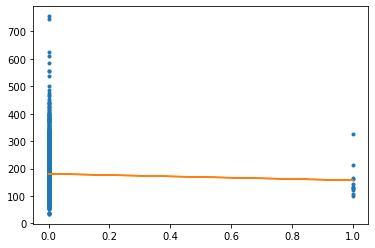

feature  HouseStyle_SLvl
--------
p_coef  -0.0386454334936104
p_value  0.13996361648451133


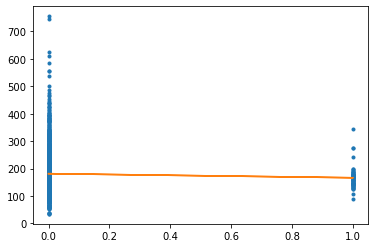

feature  RoofStyle_Flat
--------
p_coef  0.01643347828794214
p_value  0.530379456739671


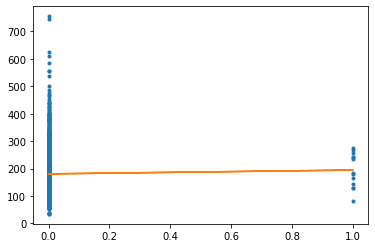

feature  RoofStyle_Gambrel
--------
p_coef  -0.035121434493649045
p_value  0.17983848652314016


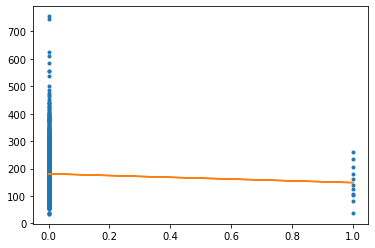

feature  RoofStyle_Mansard
--------
p_coef  -0.00030831909381732396
p_value  0.9906085044169727


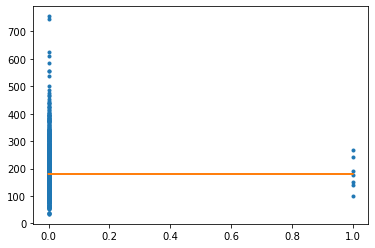

feature  RoofStyle_Shed
--------
p_coef  0.020557102562781884
p_value  0.4325145743746945


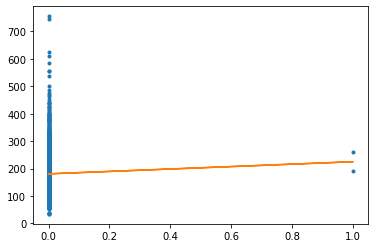

feature  RoofMatl_ClyTile
--------
p_coef  -0.0068969126158057404
p_value  0.7923131339893849


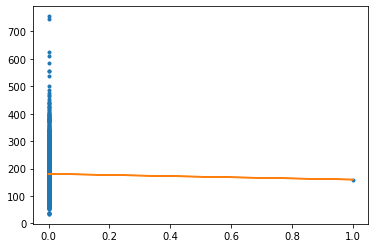

feature  RoofMatl_Membran
--------
p_coef  0.019970498842533133
p_value  0.44576513039897736


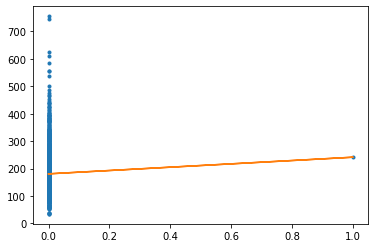

feature  RoofMatl_Metal
--------
p_coef  -0.00030368281007855783
p_value  0.9907497206937822


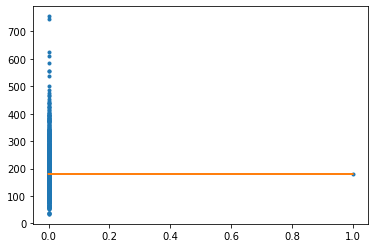

feature  RoofMatl_Roll
--------
p_coef  -0.014479126892392022
p_value  0.5803991485219843


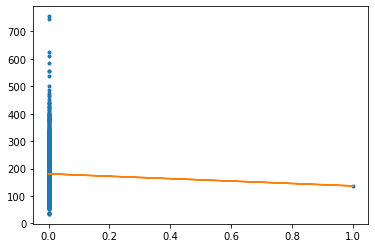

feature  RoofMatl_Tar&Grv
--------
p_coef  0.004920811214208715
p_value  0.8509832429116507


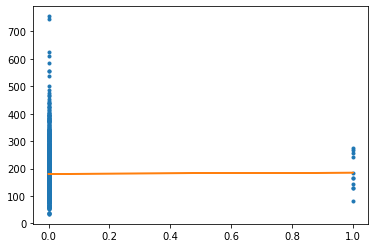

feature  Exterior1st_AsphShn
--------
p_coef  -0.02667660203298748
p_value  0.3083835189825153


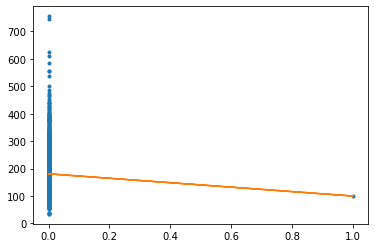

feature  Exterior1st_BrkFace
--------
p_coef  0.032371390691589993
p_value  0.21639402191874954


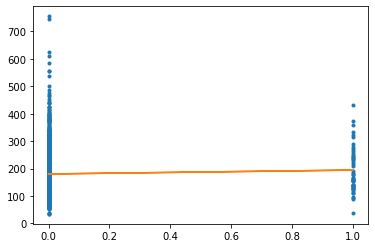

feature  Exterior1st_CBlock
--------
p_coef  -0.025028294581555473
p_value  0.3392438399289361


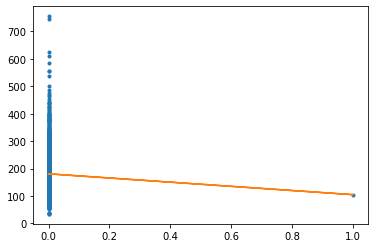

feature  Exterior1st_ImStucc
--------
p_coef  0.026728559393403052
p_value  0.3074418991362615


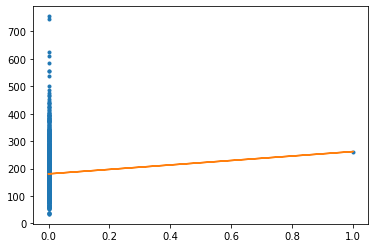

feature  Exterior1st_Plywood
--------
p_coef  -0.01771925649284024
p_value  0.49870734450780524


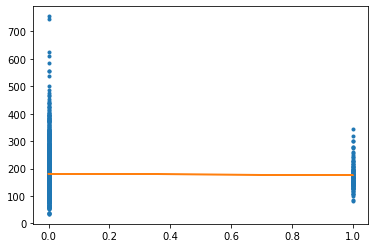

feature  Exterior1st_Stone
--------
p_coef  0.03618055128750293
p_value  0.16705608572648625


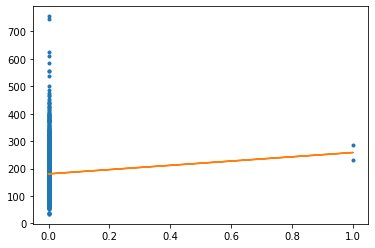

feature  Exterior1st_Stucco
--------
p_coef  -0.029802258156837916
p_value  0.2551120809411086


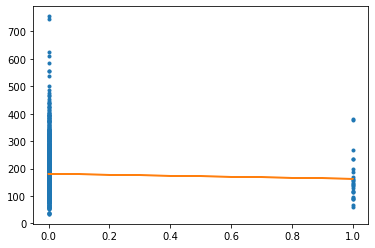

feature  Exterior2nd_AsphShn
--------
p_coef  -0.024524407793441304
p_value  0.3490597986781287


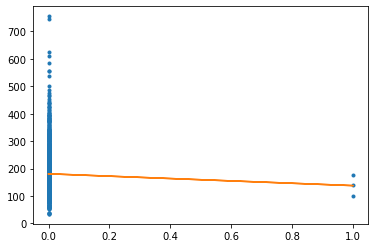

feature  Exterior2nd_BrkFace
--------
p_coef  0.02475899569103643
p_value  0.34446770229361473


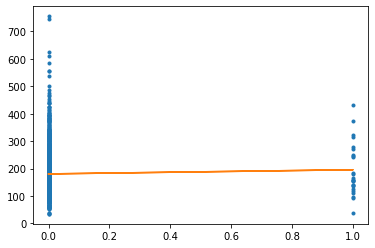

feature  Exterior2nd_CBlock
--------
p_coef  -0.025028294581555473
p_value  0.3392438399289361


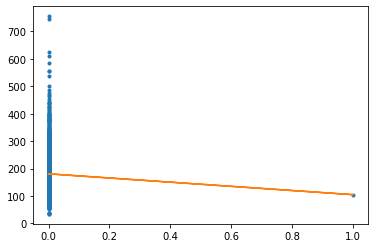

feature  Exterior2nd_Stone
--------
p_coef  -0.016753527668945736
p_value  0.5224014735380291


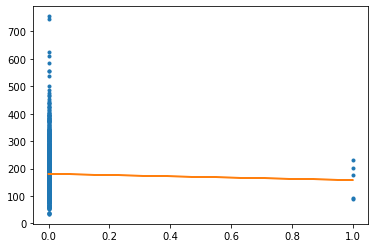

feature  Exterior2nd_Stucco
--------
p_coef  -0.042415692314699154
p_value  0.10522319725414639


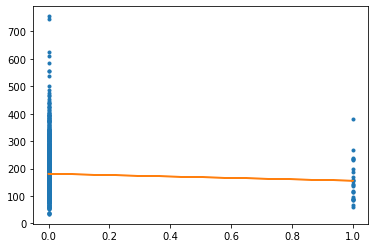

feature  Exterior2nd_Wd Shng
--------
p_coef  -0.04032943564551995
p_value  0.12348910624435222


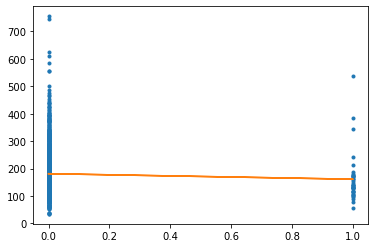

feature  ExterCond_Ex
--------
p_coef  0.01166313221710201
p_value  0.6561166227694873


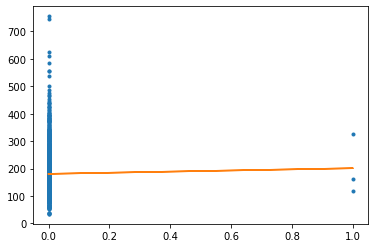

feature  ExterCond_Po
--------
p_coef  -0.03442364705471771
p_value  0.18864816045175248


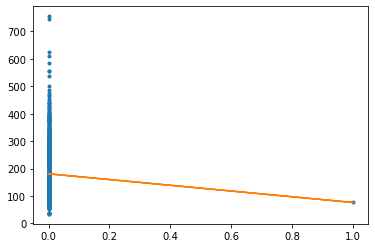

feature  Foundation_Stone
--------
p_coef  -0.012102630775853286
p_value  0.6440370656221419


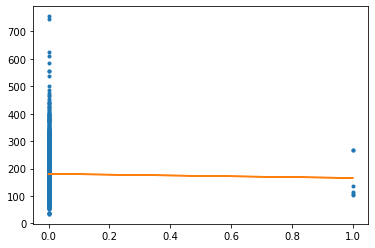

feature  Foundation_Wood
--------
p_coef  0.0027114775829149983
p_value  0.9175527650464534


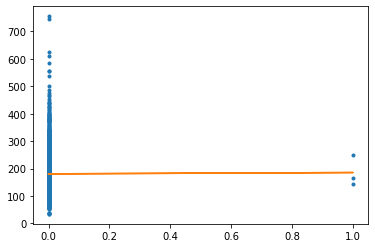

feature  BsmtFinType2_ALQ
--------
p_coef  0.041961566284397046
p_value  0.10900491978405841


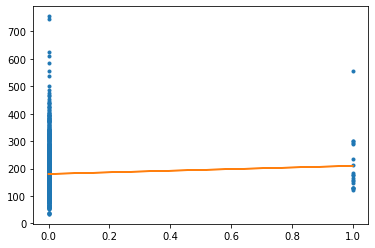

feature  BsmtFinType2_GLQ
--------
p_coef  7.551406179757066e-05
p_value  0.9976997682914682


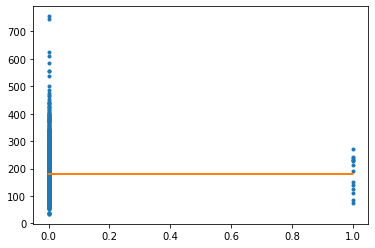

feature  BsmtFinType2_LwQ
--------
p_coef  -0.03760394773113771
p_value  0.15096760242139903


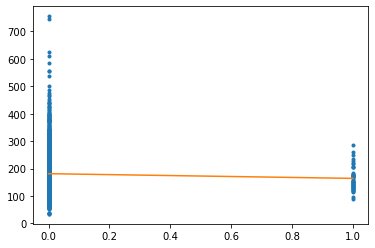

feature  BsmtFinType2_Rec
--------
p_coef  -0.039493936531656025
p_value  0.13146314195187397


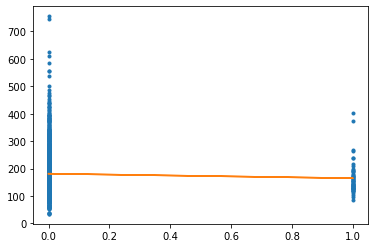

feature  Heating_Floor
--------
p_coef  -0.035742293015862237
p_value  0.17226012328655485


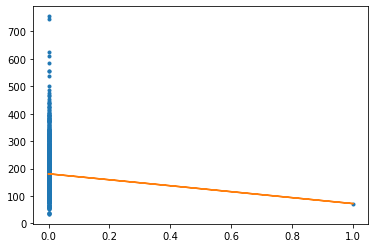

feature  Heating_GasW
--------
p_coef  -0.020102599035433613
p_value  0.4427611787811376


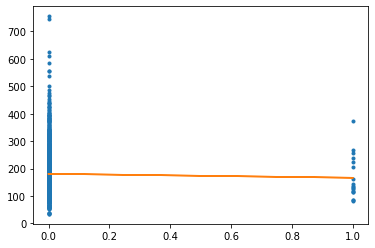

feature  Heating_OthW
--------
p_coef  -0.025730279106727816
p_value  0.32586679749929676


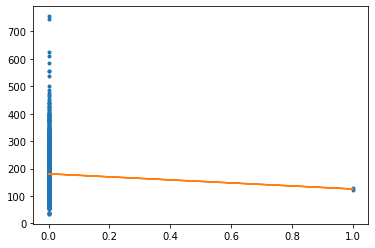

feature  HeatingQC_Po
--------
p_coef  -0.030962201406710688
p_value  0.23707311374946366


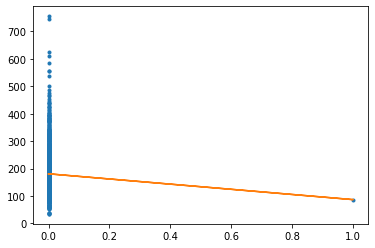

feature  Electrical_Mix
--------
p_coef  -0.03755543121243805
p_value  0.15149582608733997


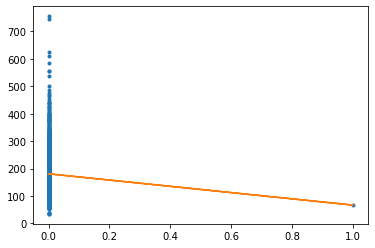

feature  Electrical_unknow
--------
p_coef  -0.004424451438658031
p_value  0.8658642238833446


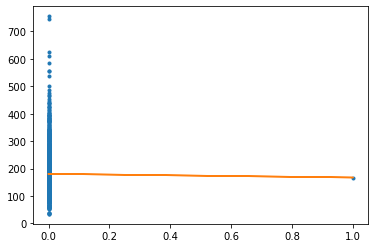

feature  Functional_Maj1
--------
p_coef  -0.03341995349143352
p_value  0.20187161486301464


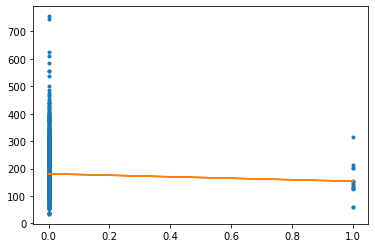

feature  Functional_Mod
--------
p_coef  -0.0160725412713806
p_value  0.5394502238732652


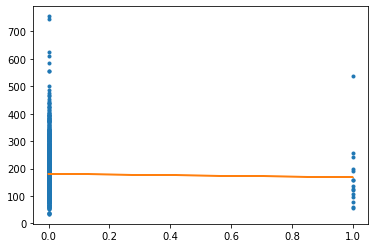

feature  Functional_Sev
--------
p_coef  -0.017116418814683124
p_value  0.5134306710714353


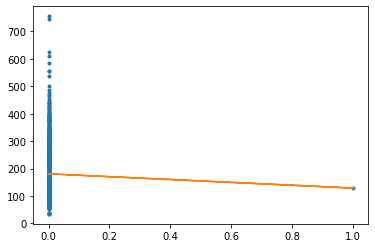

feature  FireplaceQu_Fa
--------
p_coef  -0.026085813898165007
p_value  0.31922423337551725


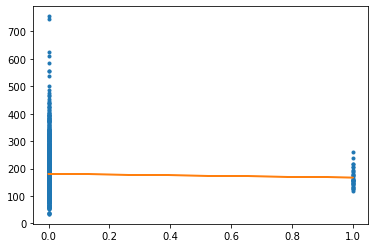

feature  GarageType_2Types
--------
p_coef  -0.02397376065437425
p_value  0.35999055859474866


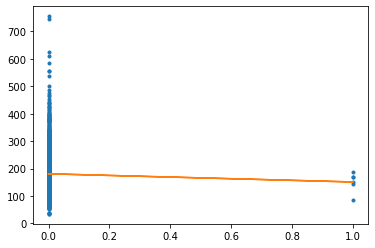

feature  GarageType_Basment
--------
p_coef  -0.02942496852213696
p_value  0.2611798832180398


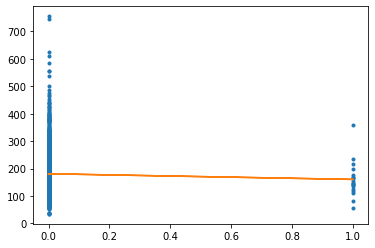

feature  GarageQual_Ex
--------
p_coef  0.034327959907916185
p_value  0.18988059738730037


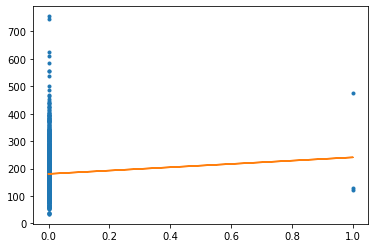

feature  GarageCond_Ex
--------
p_coef  -0.026546429413243013
p_value  0.3107509878374145


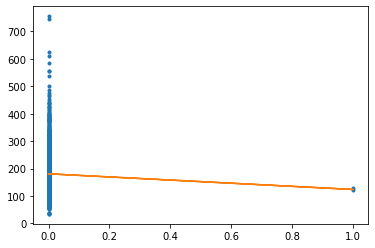

feature  GarageCond_Gd
--------
p_coef  -0.000982975978289872
p_value  0.9700645742473607


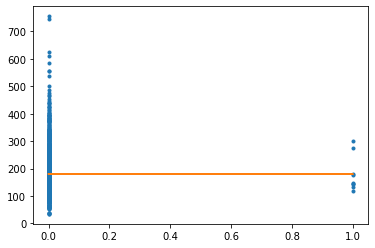

feature  SaleType_CWD
--------
p_coef  0.019588066467574456
p_value  0.4545267122894363


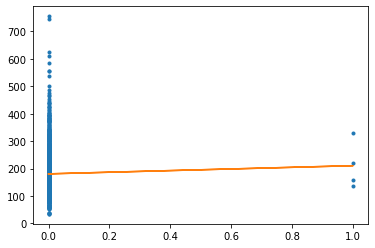

feature  SaleType_Con
--------
p_coef  0.04135727608882842
p_value  0.1142027111523226


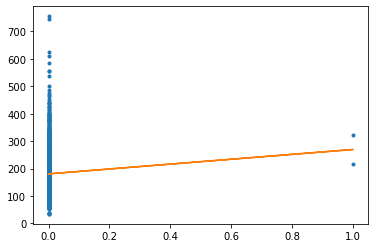

feature  SaleType_ConLD
--------
p_coef  -0.04179084064107932
p_value  0.11045410217550186


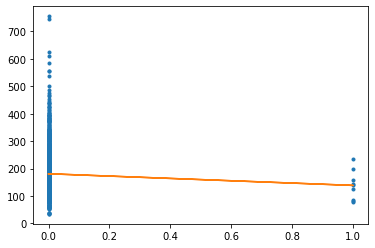

feature  SaleType_ConLI
--------
p_coef  0.014371054765972275
p_value  0.5832283382021348


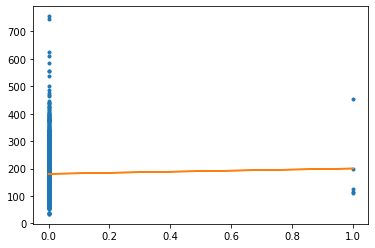

feature  SaleType_ConLw
--------
p_coef  -0.027475125928901747
p_value  0.2941219911059679


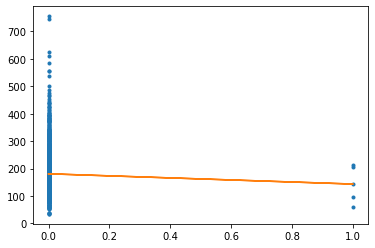

feature  SaleType_Oth
--------
p_coef  -0.03489499491751531
p_value  0.18266320040396128


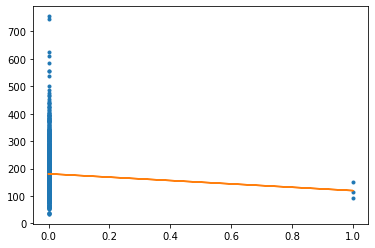

feature  SaleCondition_Alloca
--------
p_coef  -0.015525374015420017
p_value  0.553347580980062


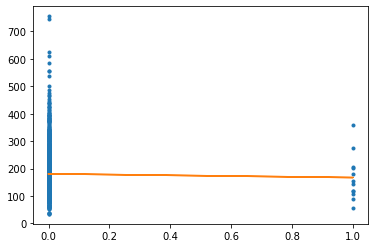

In [22]:
# AFTER CLASSIFY P_VALUE ABOVE, WE WILL PLOT EACH FEATURES AGAINST TARGET BY CLASS AND OUTPUT p_VALUE AND COEFF
print("FOR FEATURES WICH HAVE STRONG RELATIONSHIP")
print("------------------------------------------")
for i in strong:
    p_coef, p_value = stats.pearsonr(X[i], y)
    print("feature ",i)
    print('--------')
    print('p_coef ',p_coef)
    print('p_value ',p_value)
    plot(X[[i]], y)
print('\n\n')
print("FOR FEATURES WICH HAVE MODERATE RELATIONSHIP")
print("--------------------------------------------")
for i in moderate:
    p_coef, p_value = stats.pearsonr(X[i], y)
    print("feature ",i)
    print('--------')
    print('p_coef ',p_coef)
    print('p_value ',p_value)
    plot(X[[i]], y)
print('\n\n')
print("FOR FEATURES WICH HAVE WEAK RELATIONSHIP")
print("----------------------------------------")
for i in weak:
    p_coef, p_value = stats.pearsonr(X[i], y)
    print("feature ",i)
    print('--------')
    print('p_coef ',p_coef)
    print('p_value ',p_value)
    plot(X[[i]], y)
print('\n\n')
print("FOR FEATURES WICH HAVE NO RELATIONSHIP")
print("------------------------------------------")
for i in no:
    p_coef, p_value = stats.pearsonr(X[i], y)
    print("feature ",i)
    print('--------')
    print('p_coef ',p_coef)
    print('p_value ',p_value)
    plot(X[[i]], y)

In [19]:
# here we will choose features that will be used to predict data
best_feat = strong+moderate
print(best_feat)
X = train[best_feat]
y = train[target]

['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'CentralAir', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'MSZoning_C (all)', 'MSZoning_RL', 'MSZoning_RM', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_Reg', 'LandContour_HLS', 'LotConfig_CulDSac', 'Neighborhood_BrkSide', 'Neighborhood_Edwards', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_NAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_Sawyer', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Condition1_Artery', 'Condition1_Feedr', 'Condition1_Norm', 'BldgType_1Fam', 'BldgType_Duplex', 'HouseStyle_1.5Fin', 'HouseStyle_2Story', 'RoofStyle_Gable', 'RoofStyle_Hip', 'RoofMatl_CompShg', '

# split data into train, validation and test sets

In [20]:
train_set = train[:1022]
valid_set = train[1022:1241]
test_set = train[1241:]

x_train, y_train = train_set[best_feat].values, train_set[target].values
x_valid, y_valid = valid_set[best_feat].values, valid_set[target].values
x_test, y_test = test_set[best_feat].values, test_set[target].values
print(x_valid.shape)
print(y_valid.shape)
print(x_train.shape)

(219, 178)
(219,)
(1022, 178)


# built a model

1) Linear Regression

In [21]:
lr = LinearRegression()
lr.fit(x_train, y_train)
print(lr.score(x_valid, y_valid))
print(lr.score(x_test, y_test))
w = lr.coef_
b = lr.intercept_
print(len(w))
print(x_train.shape, x_valid.shape)
print(y_train.shape, y_valid.shape)

0.8442946789331963
0.6590100059770435
178
(1022, 178) (219, 178)
(1022,) (219,)


In [27]:
# here i will apply gradient descent to try to minimise the cost J and fit with the best parameters
cpt=0
for w, b in gradient_desc(x_train, y_train, w, b, 0.001, 50):
    cpt+=1
    lr.fit(x_train, y_train)
    lr.coef_ = w
    lr.intercept_ = b
    print(b)
    pred_valid = lr.predict(x_valid)
    print('MSE : ', cpt, ' ',mse(pred_valid, y_valid))


𝛛/𝛛wⁱ :  [ 0.02348337  0.         -0.41291585 -0.28767123 -0.27592955 -0.20547945
 -0.00587084  0.         -0.00782779 -0.15264188 -0.01565558 -0.05088063
 -0.01565558 -0.25636008 -0.32876712 -0.16829746 -0.17221135  0.05088063
 -0.33072407 -0.3776908  -0.28180039 -0.36203523 -0.13894325 -0.37964775
 -0.12524462  0.07827789 -0.03913894 -0.00391389 -0.13111546  0.11154599
  0.00195695  0.00978474 -0.14285714  0.02152642  0.01956947  0.00978474
 -0.00978474 -0.01174168 -0.00195695  0.04500978 -0.02152642 -0.05283757
  0.05283757 -0.01369863 -0.02348337  0.01369863 -0.00587084 -0.00978474
  0.0332681  -0.12915851 -0.10958904  0.0332681   0.01174168 -0.02935421
  0.05088063 -0.09001957 -0.19960861  0.          0.         -0.00587084
 -0.02739726 -0.07436399  0.0332681  -0.00391389 -0.02935421 -0.03913894
  0.03522505 -0.1369863   0.18199609 -0.02544031 -0.03131115  0.00195695
 -0.04109589  0.08414873  0.01565558 -0.18982387  0.04109589  0.18395303
 -0.29941292  0.         -0.07827789  0.00

-1906393.2408898913
MSE :  4   5.0202440021419876e+26


OverflowError: Python int too large to convert to C long

In [24]:
print(lr.score(x_test, y_test))
print(mse(y_test, lr.predict(x_test)))

0.6466401068271745
3.328679753368407e-09


In [22]:
poly = PolynomialFeatures(degree=2, include_bias=False)
x_poly_train = poly.fit_transform(x_train)
x_poly_valid = poly.fit_transform(x_valid)
x_poly_test = poly.fit_transform(x_test)
lr.fit(x_poly_train, y_train)
pred = lr.predict(x_poly_valid)
print(mse(y_valid, pred))


10038.89082235233


In [24]:
alphas=[i for i in range(9490000, 9491000, 100)] # i will try differents values of alpha
MSE_valid = [] # list will content MSE of valid set
MSE_test = [] # list will content MSE of test set
score_valid = [] #list will content score of valid set
score_test = [] # list will content score of test set
for i in alphas:
    ridge = Ridge(alpha=i)
    ridge.fit(x_poly_train, y_train)
    pred_valid=ridge.predict(x_poly_valid)
    pred_test = ridge.predict(x_poly_test)
    MSE_valid.append(mse(pred_valid, y_valid))
    MSE_test.append(mse(pred_test, y_test))
    score_valid.append(ridge.score(x_poly_valid, y_valid))
    score_test.append(ridge.score(x_poly_test, y_test))

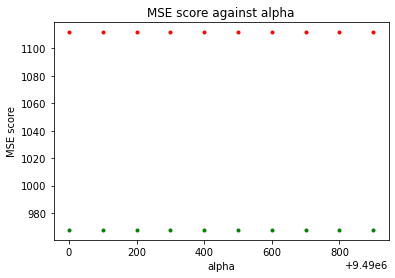

In [25]:
MSE_valid = np.array(MSE_valid)
MSE_test = np.array(MSE_test)
alphas = np.array(alphas)
plt.plot(alphas, MSE_valid, '.', color='red', label='valid set')
plt.plot(alphas, MSE_test, '.', color='green', label='test set')
plt.xlabel('alpha')
plt.ylabel('MSE score')
plt.title("MSE score against alpha")
plt.show()

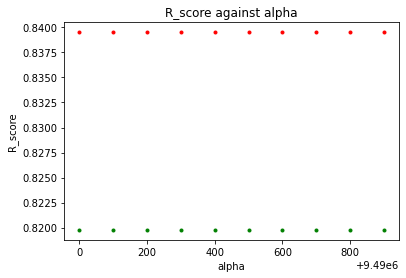

In [26]:
score_valid = np.array(score_valid)
score_test = np.array(score_test)
plt.plot(alphas, score_valid, '.', color='red')
plt.plot(alphas, score_test, '.', color='green')
plt.xlabel('alpha')
plt.ylabel('R_score')
plt.title('R_score against alpha')
plt.show()

In [53]:
df = pd.DataFrame({'MSE valid':MSE_valid,'MSE test':MSE_test,
                   'score valid':score_valid, 'score test':score_test,
                   'alphas':alphas})
df['MSE valid'].min()
print(df[df['score valid']==df['score valid'].max()])
print(df[df['score test']==df['score test'].max()])
print(df)

      MSE valid      MSE test  score valid  score test   alphas
0  1.950144e-09  1.697751e-09     0.839517    0.819773  9490000
      MSE valid      MSE test  score valid  score test   alphas
9  1.950151e-09  1.697743e-09     0.839517    0.819774  9490900
      MSE valid      MSE test  score valid  score test   alphas
0  1.950144e-09  1.697751e-09     0.839517    0.819773  9490000
1  1.950145e-09  1.697750e-09     0.839517    0.819773  9490100
2  1.950146e-09  1.697750e-09     0.839517    0.819773  9490200
3  1.950146e-09  1.697749e-09     0.839517    0.819774  9490300
4  1.950147e-09  1.697748e-09     0.839517    0.819774  9490400
5  1.950148e-09  1.697747e-09     0.839517    0.819774  9490500
6  1.950149e-09  1.697746e-09     0.839517    0.819774  9490600
7  1.950149e-09  1.697745e-09     0.839517    0.819774  9490700
8  1.950150e-09  1.697744e-09     0.839517    0.819774  9490800
9  1.950151e-09  1.697743e-09     0.839517    0.819774  9490900


In [44]:
print(df)
df.to_csv('evaluation3.csv', mode='a', index=False)

       MSE valid      MSE test  score valid  score test   alphas
0   1.946503e-09  1.702644e-09     0.839817    0.819254  9000000
1   1.946503e-09  1.702643e-09     0.839817    0.819254  9000100
2   1.946504e-09  1.702642e-09     0.839817    0.819254  9000200
3   1.946505e-09  1.702641e-09     0.839817    0.819254  9000300
4   1.946506e-09  1.702640e-09     0.839817    0.819254  9000400
..           ...           ...          ...         ...      ...
95  1.946574e-09  1.702548e-09     0.839811    0.819264  9009500
96  1.946575e-09  1.702547e-09     0.839811    0.819264  9009600
97  1.946575e-09  1.702546e-09     0.839811    0.819264  9009700
98  1.946576e-09  1.702545e-09     0.839811    0.819264  9009800
99  1.946577e-09  1.702544e-09     0.839811    0.819264  9009900

[100 rows x 5 columns]


In [76]:
print(ridge.score(x_poly_valid, y_valid))

0.8460880248677458


# Analyse scores and alpha to make decision

In [77]:
# after saving the evaluation of scores, we will analyse to make decision
evalu = pd.read_csv('evaluation1.csv')
print(evalu)
evalu['valid-test'] = evalu['score valid'] - evalu['score test']
print(evalu)

        MSE valid      MSE test  score valid  score test   alphas
0    2.007398e-09  3.497844e-09     0.834806    0.628682   201000
1    2.006513e-09  3.494870e-09     0.834879    0.628998   202000
2    2.005634e-09  3.491918e-09     0.834951    0.629311   203000
3    2.004761e-09  3.488989e-09     0.835023    0.629622   204000
4    2.003894e-09  3.486083e-09     0.835094    0.629931   205000
..            ...           ...          ...         ...      ...
494  1.869773e-09  2.147659e-09     0.846131    0.772013  8950000
495  1.869905e-09  2.147229e-09     0.846120    0.772058  8960000
496  1.870036e-09  2.146799e-09     0.846110    0.772104  8970000
497  1.870168e-09  2.146370e-09     0.846099    0.772150  8980000
498  1.870299e-09  2.145942e-09     0.846088    0.772195  8990000

[499 rows x 5 columns]
        MSE valid      MSE test  score valid  score test   alphas  valid-test
0    2.007398e-09  3.497844e-09     0.834806    0.628682   201000    0.206124
1    2.006513e-09  3.494870e

In [78]:
print('For MSE')
print('--------')
print('>> output the minimun of MSE valid : ')
print(evalu[evalu['MSE valid']==evalu['MSE valid'].min()])
print()
print('>> output the minimum of MSE test : ')
print(evalu[evalu['MSE test']==evalu['MSE test'].min()])

print('\n\nFor score')
print('--------')
print('>> output the maximum of score valid : ')
print(evalu[evalu['score valid']==evalu['score valid'].max()])
print()
print('>> output the maximum of score test : ')
print(evalu[evalu['score test']==evalu['score test'].max()])

For MSE
--------
>> output the minimun of MSE valid : 
        MSE valid      MSE test  score valid  score test   alphas  valid-test
149  1.814485e-09  2.363291e-09     0.850681    0.749122  5000000    0.101559

>> output the minimum of MSE test : 
        MSE valid      MSE test  score valid  score test   alphas  valid-test
498  1.870299e-09  2.145942e-09     0.846088    0.772195  8990000    0.073893


For score
--------
>> output the maximum of score valid : 
        MSE valid      MSE test  score valid  score test   alphas  valid-test
149  1.814485e-09  2.363291e-09     0.850681    0.749122  5000000    0.101559

>> output the maximum of score test : 
        MSE valid      MSE test  score valid  score test   alphas  valid-test
498  1.870299e-09  2.145942e-09     0.846088    0.772195  8990000    0.073893


In [34]:
# here above, we see that max score for valid set are in alpha=5000000
# and max score for test set are in alpha=6990000
# so we will try to find alpha in [5000000, 6990000]
# eval2 is a dataframe that have data from alpha=5000000 to 6990000
print(len(lr.coef_))

17765


# try with xgboost

In [181]:
from xgboost import XGBRegressor
learning_rate = [0.01]
n_estimate = [600]
score_val = []
score_test = []
param = []
for i in learning_rate:
    for j in n_estimate:
        xgb = XGBRegressor(max_depth=4, learning_rate=i, n_estimators=j)
        xgb.fit(x_poly_train, y_train)
        rmse_val = m.sqrt(mse(xgb.predict(x_poly_valid), y_valid))
        rmse_test = m.sqrt(mse(xgb.predict(x_poly_test), y_test))
        score_val.append(rmse_val)
        score_test.append(rmse_test)
        param.append([i, j])

In [182]:
print(param)
lear_rate = []
n_estim = []
for i in param:
    lear_rate.append(i[0])
    n_estim.append(i[1])

[[0.01, 600]]


In [184]:
df_xgb = pd.DataFrame({'score valid':score_val, 'score test':score_test, 
                       'learning late':lear_rate, 'n_estomators':n_estim,
                       'max_depth':4})
print(df_xgb)

   score valid  score test  learning late  n_estomators  max_depth
0    32.331303   24.930952           0.01           600          4


In [185]:
#0.03 and 450
print(df_xgb)
df_xgb.to_csv('eval_xgb_depth2', index=False, header=False, mode='a')

   score valid  score test  learning late  n_estomators  max_depth
0    32.331303   24.930952           0.01           600          4


In [ ]:
pred_xgb = xgb.predict(x_poly_test)

In [23]:
# so we decide to use alpha=2,166,490, MSE = 1.8035200618040162e-09 and score = 0.8515834710076079
# so now I will try to end up with test set
x_poly_test = poly.fit_transform(x_test)
ridge = Ridge(alpha=9490900)
ridge.fit(x_poly_train, y_train)
pred_valid = ridge.predict(x_poly_valid)
pred_test = ridge.predict(x_poly_test)
print('MSE valid ', mse(pred_valid, y_valid))
print('score valid ', ridge.score(x_poly_valid, y_valid))

print('\n')
print('MSE test ', mse(pred_test, y_test))
print('score test ', ridge.score(x_poly_test, y_test))
print(pred_test)

MSE valid  1111.6346915948452
score valid  0.8395168351025388


MSE test  967.7557160157066
score test  0.8197741500232185
[257.01602627 198.5508516  380.15898527 201.19129873 202.11833582
 210.33460766 141.51149615 158.76232244 126.85423365 276.38222532
 198.30225263 112.07936731 277.61469294 183.45544087 135.49274175
 328.01645365  85.77434808 200.99042548 153.04489489 192.86482527
 124.38751561 152.508183   170.76358537 139.13029432 180.39717382
 114.86389197 332.11735143 371.23603169 144.6358967  227.03191406
 167.67671198 129.62932353 193.03046656 162.9049069  147.84156793
 158.34261161 190.96169401 211.82228599  60.59264598 201.65665679
 194.35136979 127.63596796 152.59934134 189.83578625 129.98252089
 171.38109526 166.3118236  279.74963853 313.44959859 131.68747292
 109.08036585 142.81285615 200.98071771 104.74218362 116.85468543
 152.11578572 144.54792874 448.20986291 160.67017488 239.29813441
 180.00894168 310.2624112  240.60585227 137.4394934  369.2536224
 211.03021521 143.39

# now we will predict the test set in test.csv

In [124]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [125]:
test = test.drop(['Id', 'Alley','PoolQC', 'Fence', 'MiscFeature'], axis=1)

In [126]:
obj, num = colType(test)
print(feat_to_scale)

['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'MiscVal']


In [127]:
k=0
for i in feat_to_scale:
    test[i] = test[i]/max_[k]
    k+=1

In [128]:
test = replaceNaN_byType(test, obj, num)
test = dummies(test, obj, 'CentralAir')
test = YN_to_10(test, 'CentralAir')

In [129]:
X_test = test[best_feat]

In [130]:
print(X_test)
print(train)
print(test)

      LotFrontage   LotArea  OverallQual  YearBuilt  YearRemodAdd  MasVnrArea  \
0            80.0  0.053994            5       1961          1961     0.00000   
1            81.0  0.066283            6       1958          1958     0.06750   
2            74.0  0.064252            5       1997          1998     0.00000   
3            78.0  0.046356            6       1998          1998     0.01250   
4            43.0  0.023253            8       1992          1992     0.00000   
...           ...       ...          ...        ...           ...         ...   
1454         21.0  0.008994            4       1970          1970     0.00000   
1455         21.0  0.008799            4       1970          1970     0.00000   
1456        160.0  0.092917            5       1960          1996     0.00000   
1457         62.0  0.048508            5       1992          1992     0.00000   
1458         74.0  0.044726            7       1993          1994     0.05875   

      BsmtFinSF1  BsmtUnfSF

In [131]:
X_poly_test = poly.fit_transform(X_test)

In [134]:
pred_test = xgb.predict(X_poly_test)

In [135]:
print(pred_test)

[126.077385 157.20334  180.28249  ... 168.94409  129.76057  242.3675  ]


In [136]:
print(y_train)

[208.5  181.5  223.5  ... 213.49 176.   194.  ]


In [137]:
pred_test = pred_test*1000

In [138]:
print(pred_test)

[126077.38 157203.34 180282.48 ... 168944.1  129760.58 242367.5 ]


In [140]:
test1 = pd.read_csv('test.csv')

In [141]:
subm = pd.DataFrame({'Id':test1['Id'], 'SalePrice':pred_test})

In [142]:
print(subm)

        Id      SalePrice
0     1461  126077.382812
1     1462  157203.343750
2     1463  180282.484375
3     1464  198226.921875
4     1465  186591.328125
...    ...            ...
1454  2915   81066.015625
1455  2916   74430.890625
1456  2917  168944.093750
1457  2918  129760.578125
1458  2919  242367.500000

[1459 rows x 2 columns]


In [143]:
subm.to_csv('submission.csv', index=False)